In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.stats import mode, pearsonr
from scipy.optimize import curve_fit
from statsmodels.robust import mad
from numpy.random import normal

# Include the utils functions
import os
import sys
sys.path.insert(0, os.path.abspath('./'))
from utils import *

import warnings
warnings.filterwarnings('ignore')

boxcar_window_size = 3001
matched_filter_window_length = (3000./3600)
matched_filter_depth = 1./np.pi
matched_filter_fwhm = 1./3600
detection_threshold = 5.
matched_filter_num_fwhm = 15

Gamma_min = 0.5
Gamma_max = 100
P_min = 0.1

# For the pre-detection of vortices calculations
num_sig = 5.

max_b_over_Dact = 1.
min_full_Vobs_sigma = 3.

max_sol = 66.
med_sol = 395.
min_sol = 30.

dr="/Users/bjackson/Downloads/ps_bundle/data_calibrated"
dr_wind = '/Users/bjackson/Downloads/twins_bundle/data_derived'
# dr="/Users/brian/Downloads/ps_bundle/data_calibrated"
# dr_wind = '/Users/brian/Downloads/twins_bundle/data_derived'

aspect_ratio = 16./9 # On HD projectors nowadays, this is the aspect ratio.
                     # so I make my figures using that ratio so they show up nicely in presentations.
BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"

def line(x, m, b):
    return m*x + b

476.0
0.13307 0.2084205 0.562825
66.0
395.0
30.0
[0.510427]


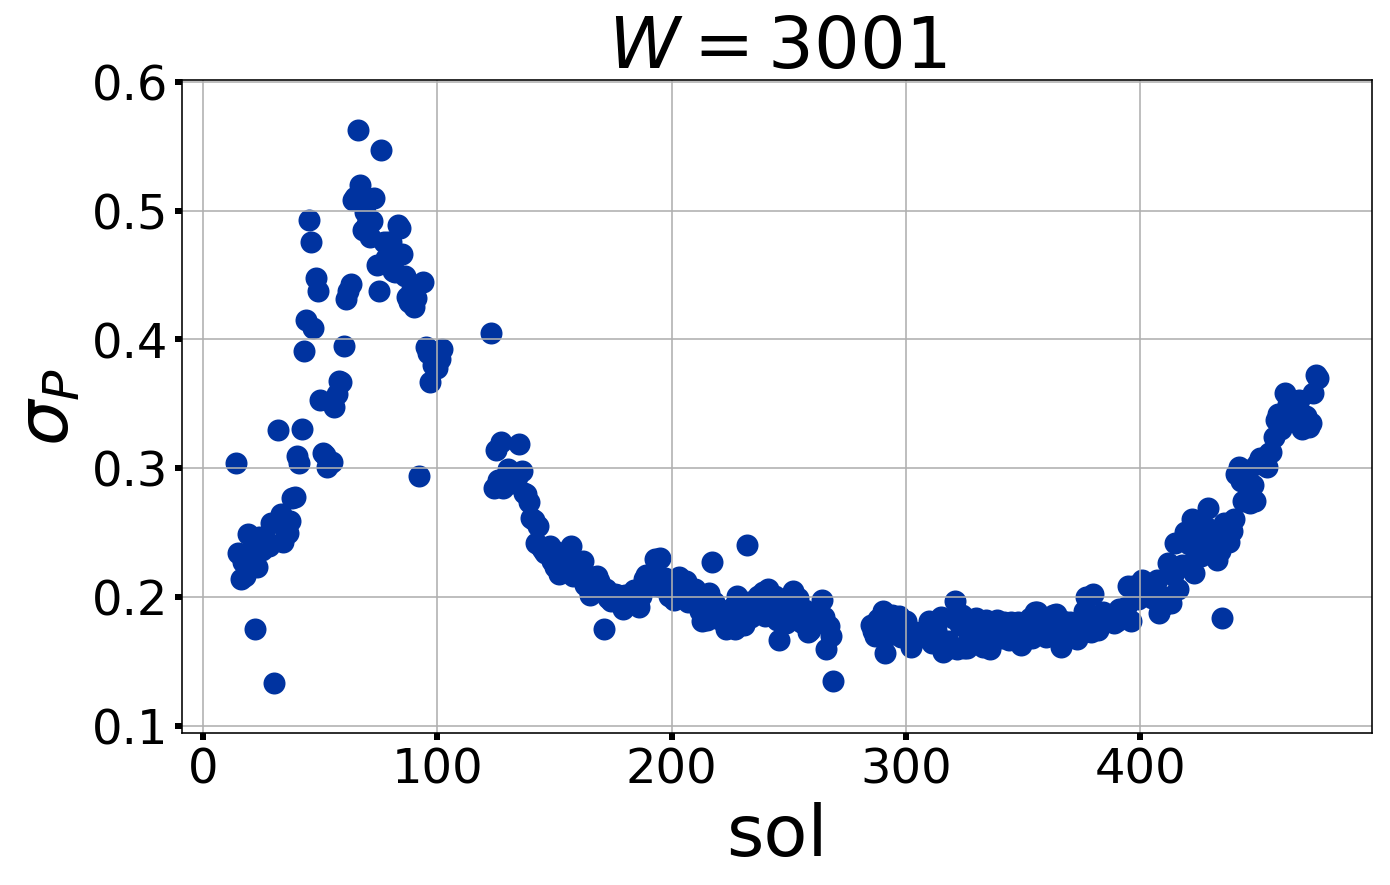

In [4]:
# 2020 Aug 5 - Cycle through all available sols and figure out which ones have the largest and smallest scatters
sols = range(14, 477)

new_filename = "filtered_pressure_scatter.csv"
# f = open(new_filename, "w")
# f.write("# sol, scatter\n")

# stds = np.array([])
# for cur_sol in sols:
# for cur_sol in [66]:
#     try:
#         LTST, LTST_and_sol, sol_data = retrieve_data(cur_sol, dr=dr)

#         pressure_filter, st = boxcar_filter(LTST, LTST_and_sol, sol_data, boxcar_window_size)
#     pressure_filter = savgol_filter(sol_data["PRESSURE"], boxcar_window_size, 0, mode='interp')

#         plt.plot(LTST_and_sol, (sol_data["PRESSURE"] - pressure_filter), marker='.', ls='')
#         plt.plot(LTST_and_sol, sol_data["PRESSURE"], marker='.', ls='')
#         plt.plot(LTST_and_sol, pressure_filter, marker='.', ls='')
    
#     plt.plot(LTST_and_sol[ind], np.ones_like(LTST_and_sol[ind])*np.nanmedian(sol_data["PRESSURE"]), marker='o')
#         plt.plot(LTST_and_sol, pressure_filter, marker='.', ls='')

#     cur_std = np.nanstd(sol_data['PRESSURE'] - pressure_filter)
#     write_str = "%i, %g" % (cur_sol, cur_std)
#     print(write_str)
#         f.write(write_str + "\n")

#         stds = np.append(stds, cur_std)

#     except:
#         print(cur_sol)
#         pass

# f.close()

data = np.genfromtxt(new_filename, delimiter=',', comments='#', names=True)

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)
ax.scatter(data['sol'], data['scatter'], color=BoiseState_blue, s=100)

print(data['sol'][-1])

ax.grid(True)
ax.set_title(r'$W = $%i' % boxcar_window_size, fontsize=36)
ax.set_xlabel("sol", fontsize=36)
ax.set_ylabel(r'$\sigma_P$', fontsize=36)
ax.tick_params(labelsize=24)

print(np.min(data['scatter']), np.median(data['scatter']), np.max(data['scatter']))
print(data['sol'][np.argmax(data['scatter'])])
print(data['sol'][np.argmin(np.abs(data['scatter'] - np.median(data['scatter'])))])
print(data['sol'][np.argmin(data['scatter'])])
print(data['scatter'][data['sol'] == 65])

max_sol = int(data['sol'][np.argmax(data['scatter'])])
med_sol = int(data['sol'][np.argmin(np.abs(data['scatter'] - np.median(data['scatter'])))])
min_sol = int(data['sol'][np.argmin(data['scatter'])])

# fig.savefig(new_filename.replace("csv", "png"), dpi=500, bbox_inches='tight')

0.9843920333989177


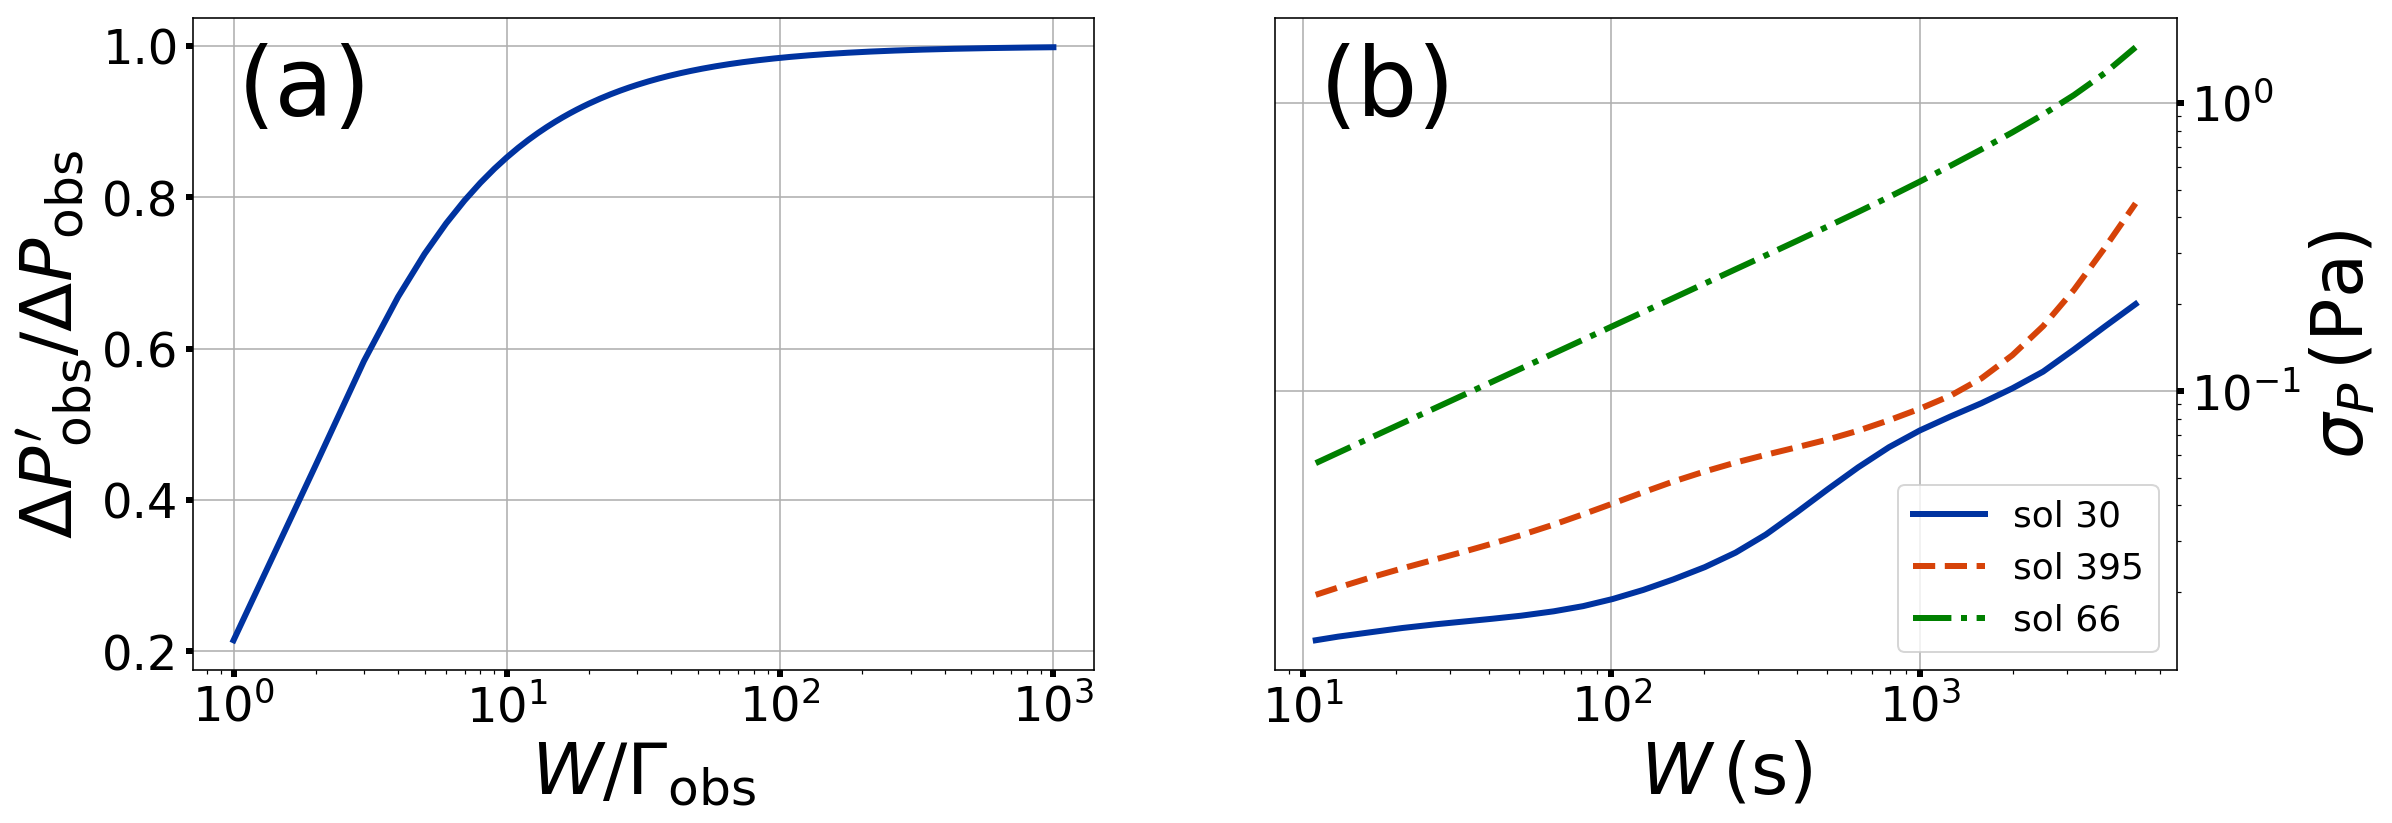

In [11]:
fig = plt.figure(figsize=(10*aspect_ratio, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# plt.setp(ax2.get_yticklabels(), visible=False)

# This calculation reflects the change in Delta P from the Savitsky-Golay filter

x = np.linspace(1, 1000, 1000)
f = 1. - np.arctan(x)/x
ax1.semilogx(x, f, color=BoiseState_blue, lw=3)
print(f[np.argmin(np.abs(x - 100.))])

ax1.set_xlabel(r'$W/\Gamma_{\rm obs}$', fontsize=36)
ax1.set_ylabel(r'$\Delta P_{\rm obs}^\prime/\Delta P_{\rm obs}$', fontsize=36)
ax1.grid(True)
ax1.tick_params(labelsize=24)
ax1.text(0.05, 0.85, "(a)", fontsize=48, transform=ax1.transAxes)

### (b) ###

sol = min_sol
LTST, LTST_and_sol, sol_data = retrieve_data(sol, dr=dr)
LTST_and_sol -= 24.*sol

delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])
min_window_size = np.log10(10./3600)
max_window_size = np.log10(5000./3600)
window_lengths_int = np.ceil((10**(np.arange(min_window_size, max_window_size + 0.1, 0.1))/delta_t)) // 2 * 2 + 1 
window_lengths = window_lengths_int*delta_t*3600.

stds = np.array([])
for i in range(len(window_lengths)):
    pressure_filter = savgol_filter(sol_data['PRESSURE'], window_lengths_int[i], 0, mode='nearest')
    stds = np.append(stds, np.std(sol_data['PRESSURE'] - pressure_filter))
ax2.loglog(window_lengths, stds, color=BoiseState_blue, lw=3, label="sol %i" % min_sol)

sol = med_sol
LTST, LTST_and_sol, sol_data = retrieve_data(sol, dr=dr)
LTST_and_sol -= 24.*sol
stds = np.array([])
for i in range(len(window_lengths)):
    pressure_filter = savgol_filter(sol_data['PRESSURE'], window_lengths_int[i], 0, mode='nearest')
    stds = np.append(stds, np.std(sol_data['PRESSURE'] - pressure_filter))
ax2.loglog(window_lengths, stds, color=BoiseState_orange, lw=3, ls='--', label="sol %i" % med_sol)

sol = max_sol
LTST, LTST_and_sol, sol_data = retrieve_data(sol, dr=dr, nans_in_gaps=False)
LTST_and_sol -= 24.*sol
stds = np.array([])
for i in range(len(window_lengths)):
    pressure_filter = savgol_filter(sol_data['PRESSURE'], window_lengths_int[i], 0, mode='nearest')
    stds = np.append(stds, np.std(sol_data['PRESSURE'] - pressure_filter))
ax2.loglog(window_lengths, stds, color='green', lw=3, ls='-.', label="sol %i" % max_sol)

ax2.legend(loc="lower right", fontsize=18)

ax2.set_xlabel(r'$W\,\left( {\rm s} \right)$', fontsize=36)
ax2.set_ylabel(r'$\sigma_P\,\left( {\rm Pa} \right)$', fontsize=36)
ax2.grid(True)
ax2.tick_params(labelsize=24)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.text(0.05, 0.85, "(b)", fontsize=48, transform=ax2.transAxes)
 
fig.savefig("../figures/Pobsprime-sigmaP_vs_W.png", dpi=500, bbox_inches="tight")

[]


ValueError: attempt to get argmin of an empty sequence

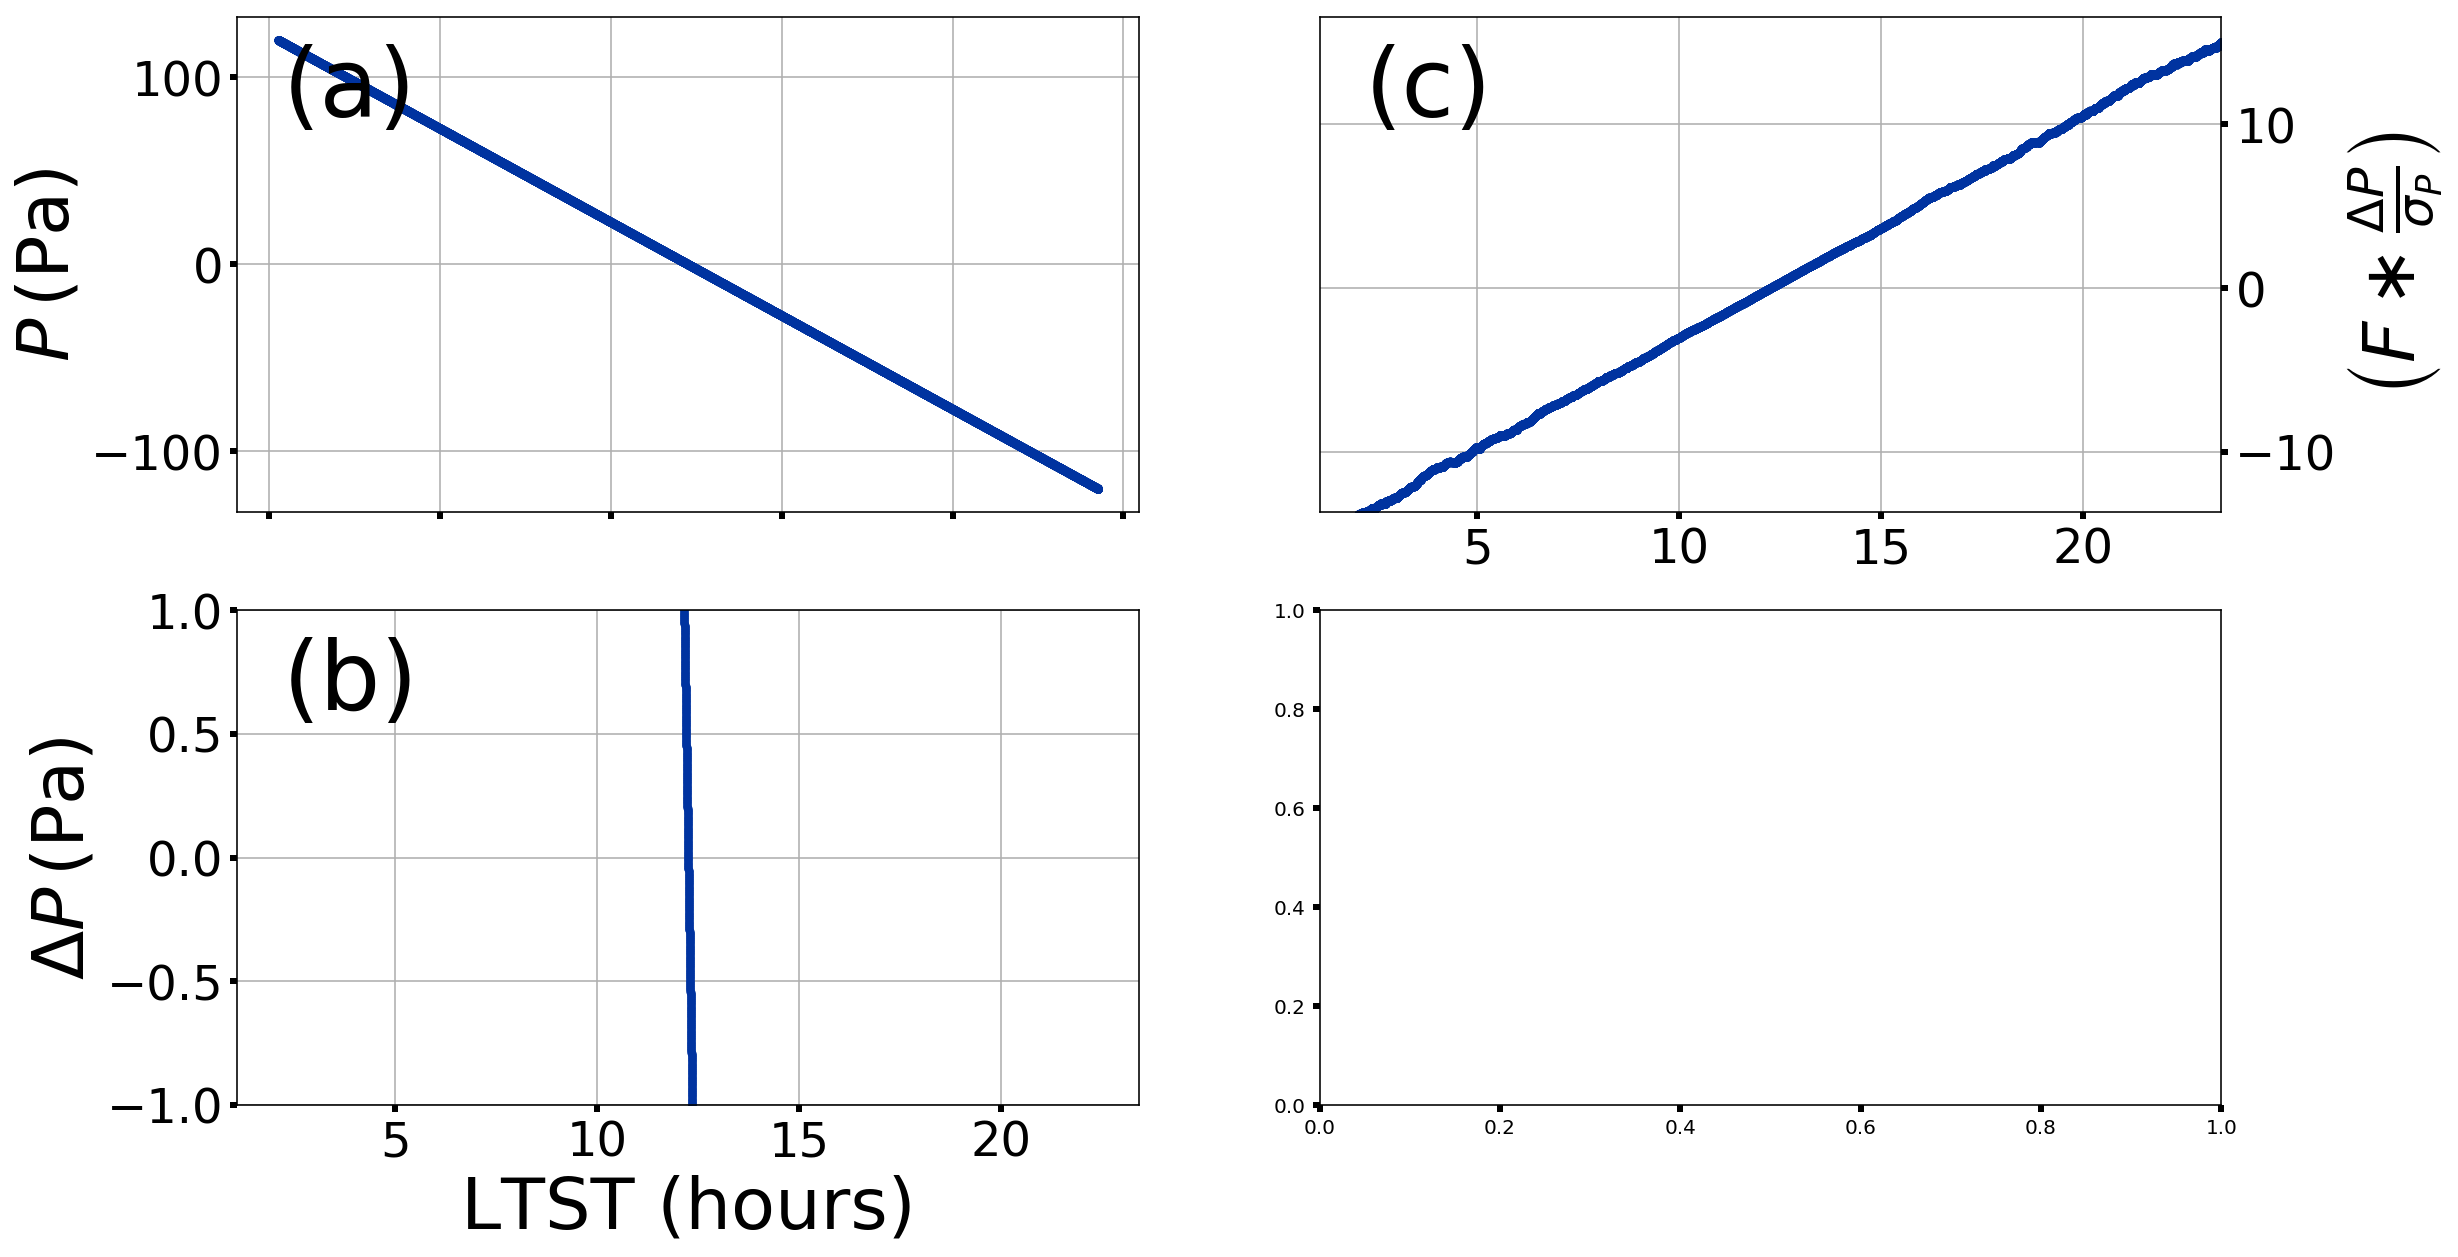

In [5]:
# The sol with the deepest vortex, as reported by Spiga et al. (2020)
# sol = 65
sol = 323
LTST, LTST_and_sol, sol_data = retrieve_data(sol, dr=dr)
LTST_and_sol -= 24.*sol
    
delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])

# Generate synthetic data
baseline = 0.
slope = -10.
t0 = np.median(LTST_and_sol)
sol_data['PRESSURE'] = modified_lorentzian(LTST_and_sol, 
baseline, slope, t0, matched_filter_depth, matched_filter_fwhm) +\
    normal(scale=matched_filter_depth/5., size=LTST_and_sol.shape)

fig = plt.figure(figsize=(10*aspect_ratio, 10))

### Raw Data ###

ind = (LTST_and_sol > np.min(LTST_and_sol) + boxcar_window_size*delta_t) &\
        (LTST_and_sol < np.max(LTST_and_sol) - boxcar_window_size*delta_t)

ax1 = fig.add_subplot(221)
ax1.plot(LTST_and_sol, sol_data['PRESSURE'], marker='.', ls='', color=BoiseState_blue)
ax1.text(0.05, 0.8, "(a)", fontsize=48, transform=ax1.transAxes)
ax1.grid(True)
ax1.tick_params(labelsize=24, labelbottom=False)
ax1.set_ylabel(r'$P\,\left({\rm Pa}\right)$', fontsize=36)

### Filtered Data ###

ax2 = fig.add_subplot(223)
filtered_pressure, st = boxcar_filter(LTST, LTST_and_sol, sol_data, boxcar_window_size)

ax2.plot(LTST_and_sol, filtered_pressure, marker='.', ls='', color=BoiseState_blue)
ax2.text(0.05, 0.8, "(b)", fontsize=48, transform=ax2.transAxes)
ax2.grid(True)
ax2.tick_params(labelsize=24)
ax2.set_xlabel("LTST (hours)", fontsize=36)
ax2.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

ax2.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
# ax2.set_ylim([0.9*np.min(filtered_pressure[ind]), 1.1*np.max(filtered_pressure[ind])])
ax2.set_ylim([-1, 1])

### Matched Filter ###

# Convolve with Lorentzian

convolution = apply_lorentzian_matched_filter(LTST_and_sol, filtered_pressure, st, 
                                              matched_filter_fwhm, matched_filter_depth, boxcar_window_size)
med = np.nanmedian(convolution)
md = mad(convolution)

ax3 = fig.add_subplot(222)
ax3.plot(LTST_and_sol, convolution, color=BoiseState_blue, ls='', marker='.')
ax3.axhline(med + detection_threshold*md, color=BoiseState_orange, ls='--', lw=6, zorder=-1)
ax3.text(0.05, 0.8, "(c)", fontsize=48, transform=ax3.transAxes)
ax3.grid(True)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.tick_params(labelsize=24, labelleft=False, labelright=True)

ax3.set_ylabel(r'$\left( F \ast \frac{\Delta P}{\sigma_P} \right)$', fontsize=36)
# ax3.set_xlabel("LTST (hours)", fontsize=36)
ax3.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
ax3.set_ylim([0.9*np.min(convolution[ind]), 1.1*np.max(convolution[ind])])

### Fit Vortex ###
ax4 = fig.add_subplot(224)

ex, pk_wds = find_vortices(LTST_and_sol, convolution, detection_threshold=detection_threshold)
print(ex)
for cur_ex in ex:
    ax2.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
    ax3.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
    
# Take largest one
# mx_ind = np.argmax(convolution[ex])
mx_ind = np.argmin(convolution[ex])
# mx_ind = np.argmin(np.abs(convolution[ex] - np.median(convolution[ex])))
# mx_ind = 7
mx_width = int(pk_wds[mx_ind])

# Use original, unfiltered data
vortex = np.array([LTST_and_sol[ex[mx_ind] - matched_filter_num_fwhm*mx_width:
                                ex[mx_ind] + matched_filter_num_fwhm*mx_width], 
                   sol_data['PRESSURE'][ex[mx_ind] - matched_filter_num_fwhm*mx_width:
                                        ex[mx_ind] + matched_filter_num_fwhm*mx_width]])

errs = st[ex[mx_ind] - matched_filter_num_fwhm*mx_width: ex[mx_ind] + matched_filter_num_fwhm*mx_width]

init_params = determine_init_params(vortex)
bounds = determine_bounds(vortex, init_params)

popt, uncertainties = fit_vortex(vortex, init_params, bounds, rescale_uncertainties=True, zoomed_in=None)

ax4.errorbar((vortex[0] - popt[2])*3600, vortex[1] - popt[0], yerr=errs, ls='', marker='o', color=BoiseState_blue)
ax4.plot((vortex[0] - popt[2])*3600, modified_lorentzian(vortex[0], *popt) - popt[0], 
         lw=3, color=BoiseState_orange, zorder=-1)

ax4.text(0.05, 0.05, "(d)", fontsize=48, transform=ax4.transAxes)
ax4.text(0.525, 0.1, ("$\\Delta P_{\\rm obs} = $(%.2g$\\pm$%.1g) Pa \n $\\Gamma_{\\rm obs} = $(%.2g$\\pm$%.1g) s" %\
                       (popt[3], uncertainties[3], popt[4]*3600, uncertainties[4]*3600)), 
         fontsize=20, transform=ax4.transAxes)
ax4.grid(True)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.tick_params(labelsize=24, labelleft=False, labelright=True)
ax4.set_xlabel(r'$t - t_0\,\left( {\rm s} \right)$', fontsize=36)
ax4.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

print((np.max(convolution[ex]) - med)/md)

# fig.savefig("../figures/data_conditioning_and_fit.png", dpi=500, bbox_inches='tight')

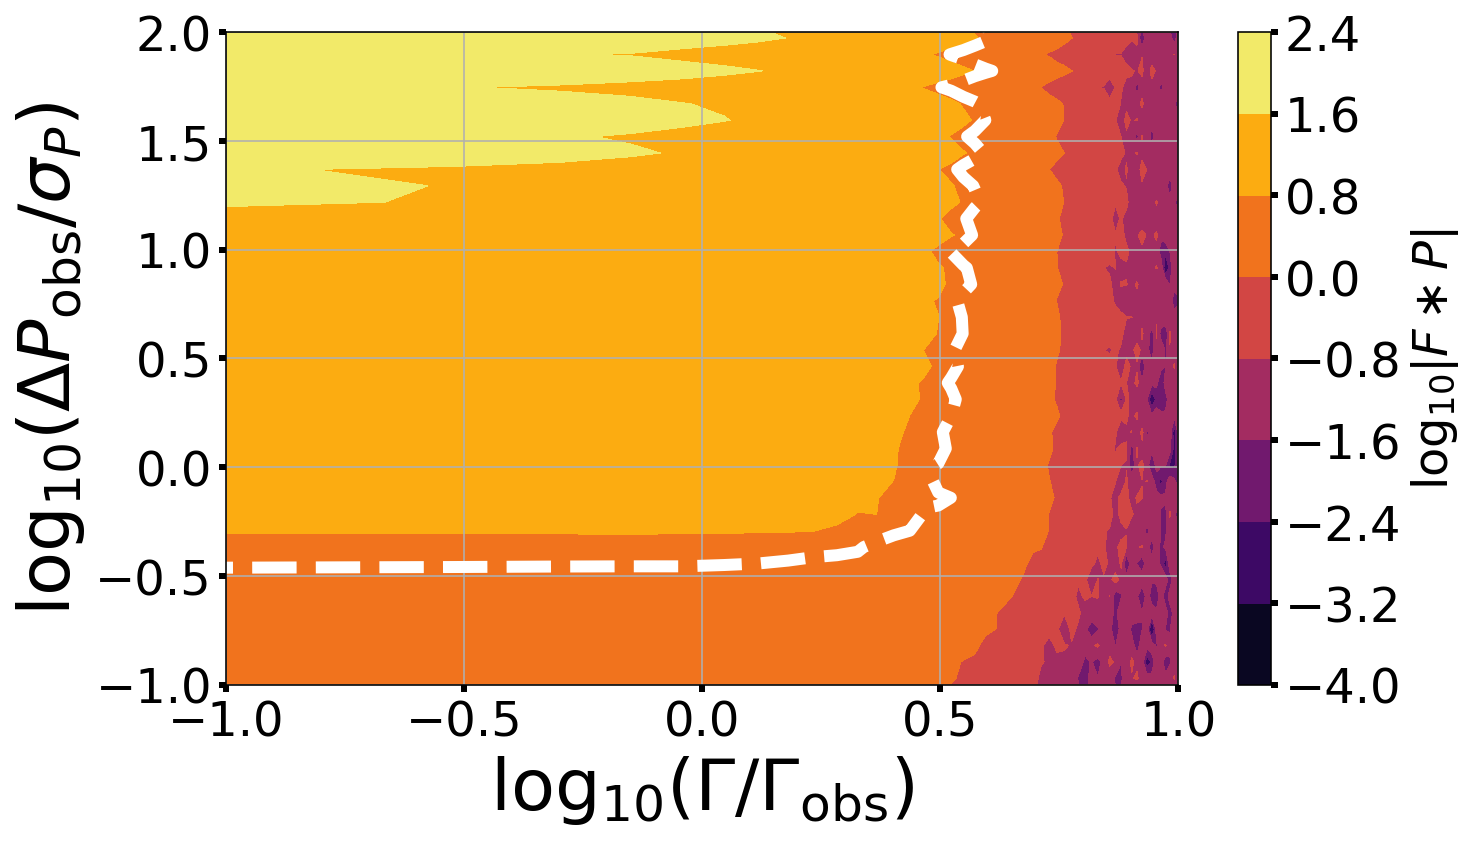

In [4]:
# sol = 65
sol = 323
LTST, LTST_and_sol, sol_data = retrieve_data(sol, dr=dr, filename_stem="calib")
LTST_and_sol -= 24.*sol
    
delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])

# Generate synthetic data
baseline = 0.
slope = 0.
t0 = np.median(LTST_and_sol)

time = np.arange(-20.*matched_filter_fwhm, 20.*matched_filter_fwhm, delta_t) + t0

num_factors = 50
num_simulations = 200
noise_factors = 10**(np.linspace(2.2, -1.5, num_factors))
width_factors = np.linspace(0.1, 10., num_factors)

recovery = np.zeros([num_simulations, num_factors, num_factors])
for i in range(num_simulations):
    for j in range(num_factors):
        for k in range(num_factors):
            data = modified_lorentzian(time, baseline, slope, t0, matched_filter_depth, matched_filter_fwhm) +\
            normal(scale=matched_filter_depth/noise_factors[k], size=time.shape)
            
            convolution =\
                apply_lorentzian_matched_filter(time, data, matched_filter_depth/noise_factors[k], 
                                                matched_filter_fwhm*width_factors[j], matched_filter_depth)
            # What convolution do you get for the peak?
            ind = np.argmin(np.abs(time - t0))
            
            med = np.median(convolution)
            md = mad(convolution)
            recovery[i,j,k] = (convolution[ind] - med)/md
            
X, Y = np.meshgrid(np.log10(width_factors), np.log10(noise_factors))
fig = plt.figure(figsize=(6*aspect_ratio, 6))
# ax = fig.add_subplot(111)

# cp = ax.contourf(X, Y, np.log10(np.mean(recovery, axis=0)))
# fig.colorbar(cp) # Add a colorbar to a plot

CS = plt.contour(X, Y, np.log10(np.abs(np.mean(recovery, axis=0))), 
                 levels = [np.log10(5)], linewidths=(6,), colors=('white'), linestyles=("--"))
# CS = plt.contourf(X, Y, np.log10(np.mean(recovery, axis=0)), 
#                   np.array([np.log10(1), np.log10(3), np.log10(5), 
#                             np.log10(10), np.log10(30), np.log10(50), 
#                             np.log10(100), np.log10(300)]), cmap='inferno')
CS = plt.contourf(X, Y, np.log10(np.abs(np.mean(recovery, axis=0))), cmap='inferno')

CB = plt.colorbar(CS, extend='both')
CB.ax.tick_params(labelsize=24) 
CB.set_label(r'$\log_{10} | F\ast P |$', fontsize=24)
plt.ylim([-1, 2])

plt.tick_params(labelsize=24)
plt.xlabel(r'$\log_{10} \left( \Gamma/\Gamma_{\rm obs} \right)$', fontsize=36)
plt.ylabel(r'$\log_{10} \left( \Delta P_{\rm obs}/\sigma_P \right)$', fontsize=36)

plt.grid(True)

# plt.semilogx(1/noise_factors, np.mean(recovery[:,:,0], axis=0))
# plt.semilogx(matched_filter_depth/noise_factors, np.mean(recovery[:,:,1], axis=0))
# plt.semilogx(matched_filter_depth/noise_factors, np.mean(recovery[:,:,2], axis=0))

# sol_data['PRESSURE'] = modified_lorentzian(LTST_and_sol, 
#                                            baseline, slope, t0, matched_filter_depth, matched_filter_fwhm) +\
#     normal(scale=matched_filter_depth/5., size=LTST_and_sol.shape)

# fig.savefig("../figures/vortex_recovery.png", dpi=500, bbox_inches="tight")

In [10]:
# The sol with the deepest vortex, as reported by Spiga et al. (2020)
# sol = 65
# sol = 323
sol = med_sol
# sol = 18

print(sol)

LTST, LTST_and_sol, sol_data = retrieve_data(sol, dr=dr)
LTST_and_sol -= 24.*sol
  
delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])

fig = plt.figure(figsize=(10*aspect_ratio, 10))

### Raw Data ###

ind = (LTST_and_sol > np.min(LTST_and_sol) + boxcar_window_size*delta_t) &\
        (LTST_and_sol < np.max(LTST_and_sol) - boxcar_window_size*delta_t)

ax1 = fig.add_subplot(221)
ax1.plot(LTST_and_sol, sol_data['PRESSURE'], marker='.', ls='', color=BoiseState_blue)
ax1.text(0.05, 0.05, "(a)", fontsize=48, transform=ax1.transAxes)
ax1.grid(True)
ax1.tick_params(labelsize=24, labelbottom=False)
ax1.set_ylabel(r'$P\,\left({\rm Pa}\right)$', fontsize=36)

### Filtered Data ###

ax2 = fig.add_subplot(223, sharex=ax1)

pressure_filter, st = boxcar_filter(LTST, LTST_and_sol, sol_data, boxcar_window_size)
filtered_pressure = sol_data["PRESSURE"] - pressure_filter

ax2.plot(LTST_and_sol, filtered_pressure, marker='.', ls='', color=BoiseState_blue)
ax2.text(0.05, 0.05, "(b)", fontsize=48, transform=ax2.transAxes)
ax2.grid(True)
ax2.tick_params(labelsize=24)
ax2.set_xlabel("LTST (hours)", fontsize=36)
ax2.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

ax2.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
ax2.set_ylim([0.9*np.min(filtered_pressure[ind]), 1.1*np.max(filtered_pressure[ind])])
# ax2.set_ylim([-1, 1])

### Matched Filter ###

# Convolve with Lorentzian

convolution = apply_lorentzian_matched_filter(LTST_and_sol, filtered_pressure, st, 
                                                      matched_filter_fwhm, matched_filter_depth, boxcar_window_size)
med = np.median(convolution)
md = mad(convolution)

convolution -= med
convolution /= md

ax3 = fig.add_subplot(222)
ax3.plot(LTST_and_sol, convolution, color=BoiseState_blue, ls='', marker='.')
ax3.axhline(detection_threshold, color=BoiseState_orange, ls='--', lw=6, zorder=-1)
ax3.text(0.05, 0.8, "(c)", fontsize=48, transform=ax3.transAxes)
ax3.grid(True)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.tick_params(labelsize=24, labelleft=False, labelright=True)

ax3.set_ylabel(r'$\left( F \ast \Delta P \right)$', fontsize=36)
# ax3.set_xlabel("LTST (hours)", fontsize=36)
ax3.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
# ax3.set_xlim([8., 10.])
ax3.set_ylim([0.9*np.min(convolution[ind]), 1.1*np.max(convolution[ind])])

### Fit Vortex ###
ax4 = fig.add_subplot(224)

ex, pk_wds = find_vortices(LTST_and_sol, convolution, detection_threshold=detection_threshold)
print(len(ex))
for cur_ex in ex:
    ax1.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
    ax2.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
    ax3.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
    
# Take largest one
mx_ind = np.argmax(convolution[ex])

# Take the smallest one
# mx_ind = np.argmin(convolution[ex])

# mx_ind = np.argmin(np.abs(convolution[ex] - np.median(convolution[ex])))
# mx_ind = 7
mx_width = np.max([2, int(pk_wds[mx_ind])])

# Use original, unfiltered data
vortex = np.array([LTST_and_sol[ex[mx_ind] - matched_filter_num_fwhm*mx_width:
                                ex[mx_ind] + matched_filter_num_fwhm*mx_width], 
                   sol_data['PRESSURE'][ex[mx_ind] - matched_filter_num_fwhm*mx_width:
                                        ex[mx_ind] + matched_filter_num_fwhm*mx_width]])

errs = st[ex[mx_ind] - matched_filter_num_fwhm*mx_width: ex[mx_ind] + matched_filter_num_fwhm*mx_width]

init_params = determine_init_params(vortex)
bounds = determine_bounds(vortex, init_params)

popt, uncertainties = fit_vortex(vortex, init_params, bounds, rescale_uncertainties=True, zoomed_in=None)
print(popt[2])

ax4.errorbar((vortex[0] - popt[2])*3600, vortex[1] - popt[0], 
             yerr=errs, ls='', marker='o', color=BoiseState_blue)
ax4.plot((vortex[0] - popt[2])*3600, modified_lorentzian(vortex[0], *popt) - popt[0], 
         lw=3, color=BoiseState_orange)

# ax4.text(0.05, 0.05, "(d), %g" % matched_filter_num_fwhm, fontsize=48, transform=ax4.transAxes)
ax4.text(0.05, 0.05, "(d)", fontsize=48, transform=ax4.transAxes)
ax4.text(0.525, 0.1, ("$\\Delta P_{\\rm obs} = $(%.1f$\\pm$%.1f) Pa \n $\\Gamma_{\\rm obs} = $(%.1f$\\pm$%.1f) s" %\
                       (popt[3], uncertainties[3], popt[4]*3600, uncertainties[4]*3600)), 
         fontsize=20, transform=ax4.transAxes)
ax4.grid(True)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.tick_params(labelsize=24, labelleft=False, labelright=True)
ax4.set_xlabel(r'$t - t_0\,\left( {\rm s} \right)$', fontsize=36)
ax4.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

# fig.savefig("../figures/data_conditioning_and_fit.png", dpi=500, bbox_inches='tight')

395
0.9999999980209395


In [2]:
# 2020 Aug 8 - Next find all the vortices

# 2020 Sep 9 - Commented everything out

# plt.ioff() # turn off showing plot

# new_filename = "all_vortices.csv"
# f = open(new_filename, "w")
# # f = open(new_filename, "a")
# f.write("# vortex_number, sol, t0, t0_unc, DeltaP, DeltaP_unc, Gamma, Gamma_unc, "+\
#         "intercept, intercept_unc, slope, slope_unc, convolution\n")

# failed_filename = "all_the_sols_we_cannot_see.txt"
# # sols = np.genfromtxt(failed_filename, dtype='i', comments="#")
# ff = open(failed_filename, "w")

# # sols = range(14, 477)
# # sols = range(21, 23)

# # for cur_sol in sols[2:3]:
# for cur_sol in sols:
# # for cur_sol in [341]:
    
#     try:

#         LTST, LTST_and_sol, sol_data = retrieve_data(cur_sol, dr=dr)
#         LTST_and_sol -= 24.*cur_sol

#         delta_ts = (LTST_and_sol[1:] - LTST_and_sol[0:-1])
#         ind = delta_ts > 0.
#         delta_t = mode(delta_ts[ind])[0][0]

#         fig = plt.figure(figsize=(10*aspect_ratio, 10))
#         fig.suptitle("sol " + str(cur_sol), fontsize=36)

#         ### Raw Data ###

#         ind = (LTST_and_sol > np.min(LTST_and_sol) + boxcar_window_size*delta_t) &\
#                 (LTST_and_sol < np.max(LTST_and_sol) - boxcar_window_size*delta_t)

#         ax1 = fig.add_subplot(221)
#         ax1.plot(LTST_and_sol, sol_data['PRESSURE'], marker='.', ls='', color=BoiseState_blue)
#         ax1.text(0.05, 0.05, "(a)", fontsize=48, transform=ax1.transAxes)
#         ax1.grid(True)
#         ax1.tick_params(labelsize=24, labelbottom=False)
#         ax1.set_ylabel(r'$P\,\left({\rm Pa}\right)$', fontsize=36)

#         ### Filtered Data ###

#         ax2 = fig.add_subplot(223, sharex=ax1)

#         pressure_filter, st = boxcar_filter(LTST, LTST_and_sol, sol_data, boxcar_window_size)
#         filtered_pressure = sol_data["PRESSURE"] - pressure_filter

#         ax2.plot(LTST_and_sol, filtered_pressure, marker='.', ls='', color=BoiseState_blue)
#         ax2.text(0.05, 0.05, "(b)", fontsize=48, transform=ax2.transAxes)
#         ax2.grid(True)
#         ax2.tick_params(labelsize=24)
#         ax2.set_xlabel("LTST (hours)", fontsize=36)
#         ax2.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

#         ax2.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
#         ax2.set_ylim([0.9*np.min(filtered_pressure[ind]), 1.1*np.max(filtered_pressure[ind])])
#         # ax2.set_ylim([-1, 1])

#         ### Matched Filter ###

#         # Convolve with Lorentzian

#         convolution = apply_lorentzian_matched_filter(LTST_and_sol, filtered_pressure, st, 
#                                                       matched_filter_fwhm, matched_filter_depth, boxcar_window_size)
#         med = np.median(convolution)
#         md = mad(convolution)

#         convolution -= med
#         convolution /= md

#         ax3 = fig.add_subplot(222)
#         ax3.plot(LTST_and_sol, convolution, color=BoiseState_blue, ls='', marker='.')
#         ax3.axhline(detection_threshold, color=BoiseState_orange, ls='--', lw=6, zorder=-1)
#         ax3.text(0.05, 0.8, "(c)", fontsize=48, transform=ax3.transAxes)
#         ax3.grid(True)
#         ax3.yaxis.set_label_position("right")
#         ax3.yaxis.tick_right()
#         ax3.tick_params(labelsize=24, labelleft=False, labelright=True)

#         ax3.set_ylabel(r'$\left( F \ast \Delta P \right)$', fontsize=36)
#         # ax3.set_xlabel("LTST (hours)", fontsize=36)
#         ax3.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
#         # ax3.set_xlim([8., 10.])
#         ax3.set_ylim([0.9*np.min(convolution[ind]), 1.1*np.max(convolution[ind])])

#         ### Fit Vortex ###
#         ax4 = fig.add_subplot(224)

#         ex, pk_wds = find_vortices(LTST_and_sol, convolution, detection_threshold=detection_threshold)

#         if(len(ex) > 0):

#             # Make a new directory
#             new_dir_name = "data_conditioning_figures/sol_" + str(cur_sol)
#             if not os.path.exists(new_dir_name):
#                 os.mkdir(new_dir_name)

#             # Sort vortices from weakest to strongest
#             srt = np.argsort(convolution[ex])
#             srt_ex = ex[srt]
#             srt_pk_wds = pk_wds[srt]

#             # 2020 Aug 10 - Sol 67 has an enormous increase in pressure, followed by a spike.
#             # This structure fools the fitting routine into seeing a lot of vortices.
#             # The easiest way to fix this is to ignore that region for that sol.
#             if((cur_sol == 67) or (cur_sol == 84)):
#                 drop_ind = ~(LTST_and_sol[srt_ex] > 18.)
#                 srt_ex = srt_ex[drop_ind]
#                 srt_pk_wds = srt_pk_wds[drop_ind]

#             for i in range(len(srt_ex)):

#                 mx_width = np.max([2, int(srt_pk_wds[i])])
#                 # Make sure that the mx_width doesn't go overboard
#                 mx_width = np.min([mx_width, int(300/15)])

#                 ax1.axvline(LTST_and_sol[srt_ex[i]], color=BoiseState_orange, zorder=-1, ls='--')
#                 ax2.axvline(LTST_and_sol[srt_ex[i]], color=BoiseState_orange, zorder=-1, ls='--')
#                 ax3.axvline(LTST_and_sol[srt_ex[i]], color=BoiseState_orange, zorder=-1, ls='--')

#             # Use original, unfiltered data
#                 vortex = np.array([LTST_and_sol[srt_ex[i] - matched_filter_num_fwhm*mx_width:
#                                                 srt_ex[i] + matched_filter_num_fwhm*mx_width], 
#                                    sol_data['PRESSURE'][srt_ex[i] - matched_filter_num_fwhm*mx_width:
#                                                         srt_ex[i] + matched_filter_num_fwhm*mx_width]])

#                 errs = st[srt_ex[i] - matched_filter_num_fwhm*mx_width: srt_ex[i] + matched_filter_num_fwhm*mx_width]

#                 # Sometimes the uncertainties go hay-wire. In those cases, impose a reasonable upper limit.
#                 if(np.any(errs > 10.)):
#                     errs = np.ones_like(errs)*1. # Pa

#                 init_params = determine_init_params(vortex)
#                 bounds = determine_bounds(vortex, init_params)

#                 popt, uncertainties = fit_vortex(vortex, init_params, bounds, rescale_uncertainties=True, zoomed_in=None)

#                 write_str = "%i, %i, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g" %\
#                     (i, cur_sol, popt[2], uncertainties[2], popt[3], uncertainties[3], 
#                      popt[4]*3600., uncertainties[4]*3600, 
#                      popt[0], uncertainties[0], popt[1], uncertainties[1], convolution[srt_ex[i]],)
#                 print(write_str)
#                 f.write(write_str + "\n")

#                 fig2 = plt.figure(figsize=(10*aspect_ratio, 10))
#                 fig2.suptitle("sol " + str(cur_sol) + ", vortex_number " + str(i), fontsize=36)

#                 axind = fig2.add_subplot(111)
#                 axind.errorbar((vortex[0] - popt[2])*3600, vortex[1] - popt[0], 
#                                yerr=errs, ls='', marker='o', color=BoiseState_blue)
#                 axind.plot((vortex[0] - popt[2])*3600, modified_lorentzian(vortex[0], *popt) - popt[0], 
#                            lw=3, color=BoiseState_orange)

#                 solution_str = ("$\\Delta P_{\\rm obs} = (%.1f\\pm%.1f)\\,{\\rm Pa}$ \n" +\
#                     "$\\Gamma_{\\rm obs} = (%.1f\\pm%.1f)\\,{\\rm s}$ \n "+\
#                     "$t_0 = %.4f\\,{\\rm hrs}\\pm%.3f\\,{\\rm s}$") %\
#                 (popt[3], uncertainties[3], popt[4]*3600, uncertainties[4]*3600, popt[2], uncertainties[2]*3600)

#                 axind.text(0.525, 0.1, solution_str, fontsize=20, transform=axind.transAxes)

#                 axind.grid(True)
#                 axind.tick_params(labelsize=24)
#                 axind.set_xlabel(r'$t - t_0\,\left( {\rm s} \right)$', fontsize=36)
#                 axind.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

#                 fig2name = new_dir_name + "/sol_%s_vortex_number_%i.png" % (cur_sol, i)
#                 fig2.savefig(fig2name, dpi=500, bbox_inches="tight")

#             # Since the vortices are sorted biggest to smallest, the last one is the largest.
#             ax4.errorbar((vortex[0] - popt[2])*3600, vortex[1] - popt[0], 
#                          yerr=errs, ls='', marker='o', color=BoiseState_blue)
#             ax4.plot((vortex[0] - popt[2])*3600, modified_lorentzian(vortex[0], *popt) - popt[0], 
#                      lw=3, color=BoiseState_orange)

#             # ax4.text(0.05, 0.05, "(d), %g" % matched_filter_num_fwhm, fontsize=48, transform=ax4.transAxes)
#             ax4.text(0.05, 0.05, "(d)", fontsize=48, transform=ax4.transAxes)
#             ax4.text(0.525, 0.1, ("$\\Delta P_{\\rm obs} = $(%.1f$\\pm$%.1f) Pa \n $\\Gamma_{\\rm obs} = $(%.1f$\\pm$%.1f) s" %\
#                                    (popt[3], uncertainties[3], popt[4]*3600, uncertainties[4]*3600)), 
#                      fontsize=20, transform=ax4.transAxes)
#             ax4.grid(True)
#             ax4.yaxis.set_label_position("right")
#             ax4.yaxis.tick_right()
#             ax4.tick_params(labelsize=24, labelleft=False, labelright=True)
#             ax4.set_xlabel(r'$t - t_0\,\left( {\rm s} \right)$', fontsize=36)
#             ax4.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

#         figname = "data_conditioning_figures/data_conditioning_sol_%s.png" % cur_sol
#         fig.savefig(figname, dpi=500, bbox_inches='tight')

#     except:
#         e = sys.exc_info()
#         print( e )
#         print("Broken sol: ", cur_sol)
#         ff.write(str(cur_sol) + "\n")
#         pass

# f.close()
# ff.close()

number of original vortices:  1034
number of culled vortices:  990
Gammaobs_quantile, DeltaPobs_quantile:  5.991664999999999 1.1151550000000001


(0.1, 10)

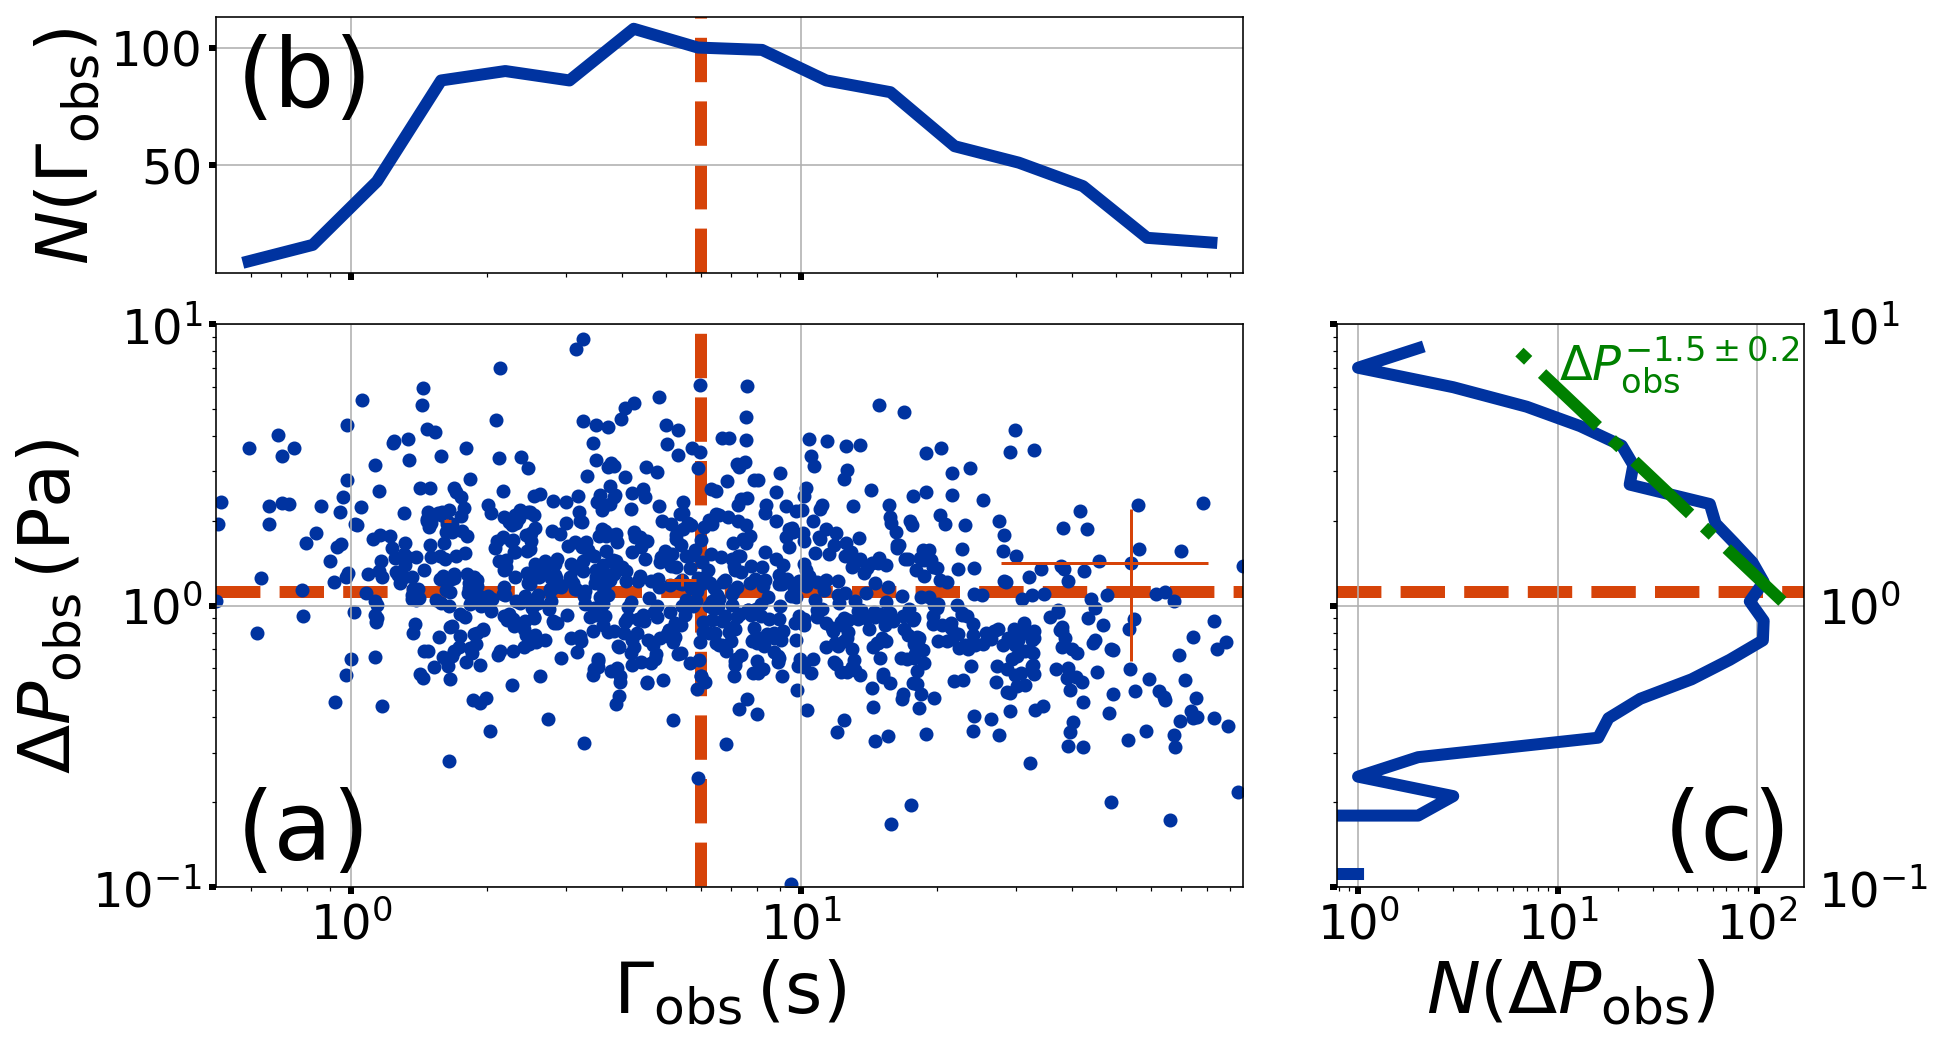

In [7]:
filename = "all_vortices.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)
print("number of original vortices: ", len(data))

fig = plt.figure(figsize=(8*aspect_ratio, 8))
ax = fig.add_subplot(111)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)
x = data['Gamma'][ind]
y = data['DeltaP'][ind]
xerr = data['Gamma_unc'][ind]
yerr = data['DeltaP_unc'][ind]

Gammaobs_quantile = np.quantile(x, 0.5)
DeltaPobs_quantile = np.quantile(y, 0.5)
print("number of culled vortices: ", len(x))

print("Gammaobs_quantile, DeltaPobs_quantile: ", Gammaobs_quantile, DeltaPobs_quantile)

# print(len(x), len(data['Gamma']), len(data['Gamma']) - len(x))
# print(np.max(y), data['DeltaP_unc'][ind][np.argmax(y)], data['sol'][ind][np.argmax(y)])
# print(np.max(x), data['Gamma_unc'][ind][np.argmax(x)], data['sol'][ind][np.argmax(x)])
# print(Gammaobs_quantile, data['Gamma_unc'][ind][np.argmin(np.abs(Gammaobs_quantile - x))])
# print(DeltaPobs_quantile, data['DeltaP_unc'][ind][np.argmin(np.abs(DeltaPobs_quantile - y))])

### Create axes ###

ax = plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
ax_Gammahist = plt.subplot2grid((3,3), (0,0), colspan=2, sharex=ax)
ax_DeltaPhist = plt.subplot2grid((3,3), (1,2), rowspan=2, sharey=ax)

### Make scatterplot ###

ax.loglog(x, y, marker='o', ls='', color=BoiseState_blue, lw=6, zorder=0)
err_ind = np.argmax(np.sqrt(xerr**2 + yerr**2))
ax.errorbar(x[err_ind], y[err_ind], xerr=xerr[err_ind], yerr=yerr[err_ind], color=BoiseState_orange)
err_ind = np.argmin(np.sqrt(xerr**2 + yerr**2))
ax.errorbar(x[err_ind], y[err_ind], xerr=xerr[err_ind], yerr=yerr[err_ind], color=BoiseState_orange)
err_ind = np.argsort(np.sqrt(xerr**2 + yerr**2))[len(np.sqrt(xerr**2 + yerr**2))//2]
ax.errorbar(x[err_ind], y[err_ind], xerr=xerr[err_ind], yerr=yerr[err_ind], color=BoiseState_orange)

ax.axvline(Gammaobs_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)
ax.axhline(DeltaPobs_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

### Make Gammaobs histogram ###

Gammaobs_hst, bin_edges = np.histogram(np.log10(x), bins='auto')
Gammaobs_bins = 0.5*(bin_edges[1:] + bin_edges[0:-1])
ax_Gammahist.semilogx(10.**Gammaobs_bins, Gammaobs_hst, lw=6, color=BoiseState_blue)

ax_Gammahist.axvline(Gammaobs_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

### Make table of histogram values ###
tablefile = "Gamma_obs_histogram_table.csv"
f = open(tablefile, "w")
f.write("# Gamma_obs\n")
f.write("# bin_edges, histogram\n")
fmt1 = "%g, %g\n"
fmt2 = "%g, \n"
for i in range(len(bin_edges)):
    if(i < len(bin_edges) - 1):
        f.write(fmt1 % (bin_edges[i], Gammaobs_hst[i]))
    else:
        f.write(fmt2 % bin_edges[i])
        
f.close()

### Make Delta Pobs histogram ###

Pobs_hst, bin_edges = np.histogram(np.log10(y), bins='auto')
Pobs_bins = 0.5*(bin_edges[1:] + bin_edges[0:-1])

ax_DeltaPhist.semilogx(Pobs_hst, 10.**Pobs_bins, lw=6, color=BoiseState_blue)

ax_DeltaPhist.axhline(DeltaPobs_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

### Make table of histogram values ###
tablefile = "DeltaP_obs_histogram_table.csv"
f = open(tablefile, "w")
f.write("# DeltaP_obs\n")
f.write("# bin_edges, histogram\n")
fmt1 = "%g, %g\n"
fmt2 = "%g, \n"
for i in range(len(bin_edges)):
    if(i < len(bin_edges) - 1):
        f.write(fmt1 % (bin_edges[i], Pobs_hst[i]))
    else:
        f.write(fmt2 % bin_edges[i])
        
f.close()

### Fit Delta Pobs hist with power-law ###

mx_ind = np.argmin(np.abs(DeltaPobs_quantile - 10.**Pobs_bins))
err = np.sqrt(Pobs_hst)/(np.log(10.)*Pobs_hst)

# err = np.ones_like(hst)
popt, pcov = curve_fit(line, Pobs_bins[mx_ind:], np.log10(Pobs_hst[mx_ind:]), sigma=err[mx_ind:])
uncertainties = np.diag(np.sqrt(pcov))
ax_DeltaPhist.semilogx(10.**np.polyval(popt, Pobs_bins[mx_ind:]), 10.**Pobs_bins[mx_ind:], 
                       ls='-.', lw=6, color='green')

### Tweak and label axes

ax_DeltaPhist.text(0.475, 0.9, r'$\Delta P_{\rm obs}^{%.2g\pm%.1g}$' % (popt[0], uncertainties[0]), 
                   fontsize=24, transform=ax_DeltaPhist.transAxes, color='green')

ax.grid(True)
ax_Gammahist.grid(True)
ax_DeltaPhist.grid(True)
ax.tick_params(labelsize=24)
ax_Gammahist.tick_params(labelbottom=False, labelsize=24)
ax_DeltaPhist.tick_params(labelleft=False, labelright=True, labelsize=24)

ax.set_xlabel(r'$\Gamma_{\rm obs}\,\left( {\rm s} \right)$', fontsize=36)
ax.set_ylabel(r'$\Delta P_{\rm obs}\,\left( {\rm Pa} \right)$', fontsize=36)
ax_DeltaPhist.set_xlabel(r'$N\left(\Delta P_{\rm obs}\right)$', fontsize=36)
ax_Gammahist.set_ylabel(r'$N\left(\Gamma_{\rm obs}\right)$', fontsize=36)

ax.text(0.02, 0.05, "(a)", fontsize=48, transform=ax.transAxes)
ax_Gammahist.text(0.02, 0.65, "(b)", fontsize=48, transform=ax_Gammahist.transAxes)
ax_DeltaPhist.text(0.7, 0.05, "(c)", fontsize=48, transform=ax_DeltaPhist.transAxes)

ax.set_xlim([np.min(x), np.max(x)])
ax.set_ylim([0.1, 10])

# fig.savefig("../figures/DeltaPobs_vs_Gammaobs.png", dpi=500, bbox_inches="tight")

number of original vortices:  1034
number of culled vortices:  990
Gammaobs_quantile, DeltaPobs_quantile:  5.991664999999999 1.1151550000000001


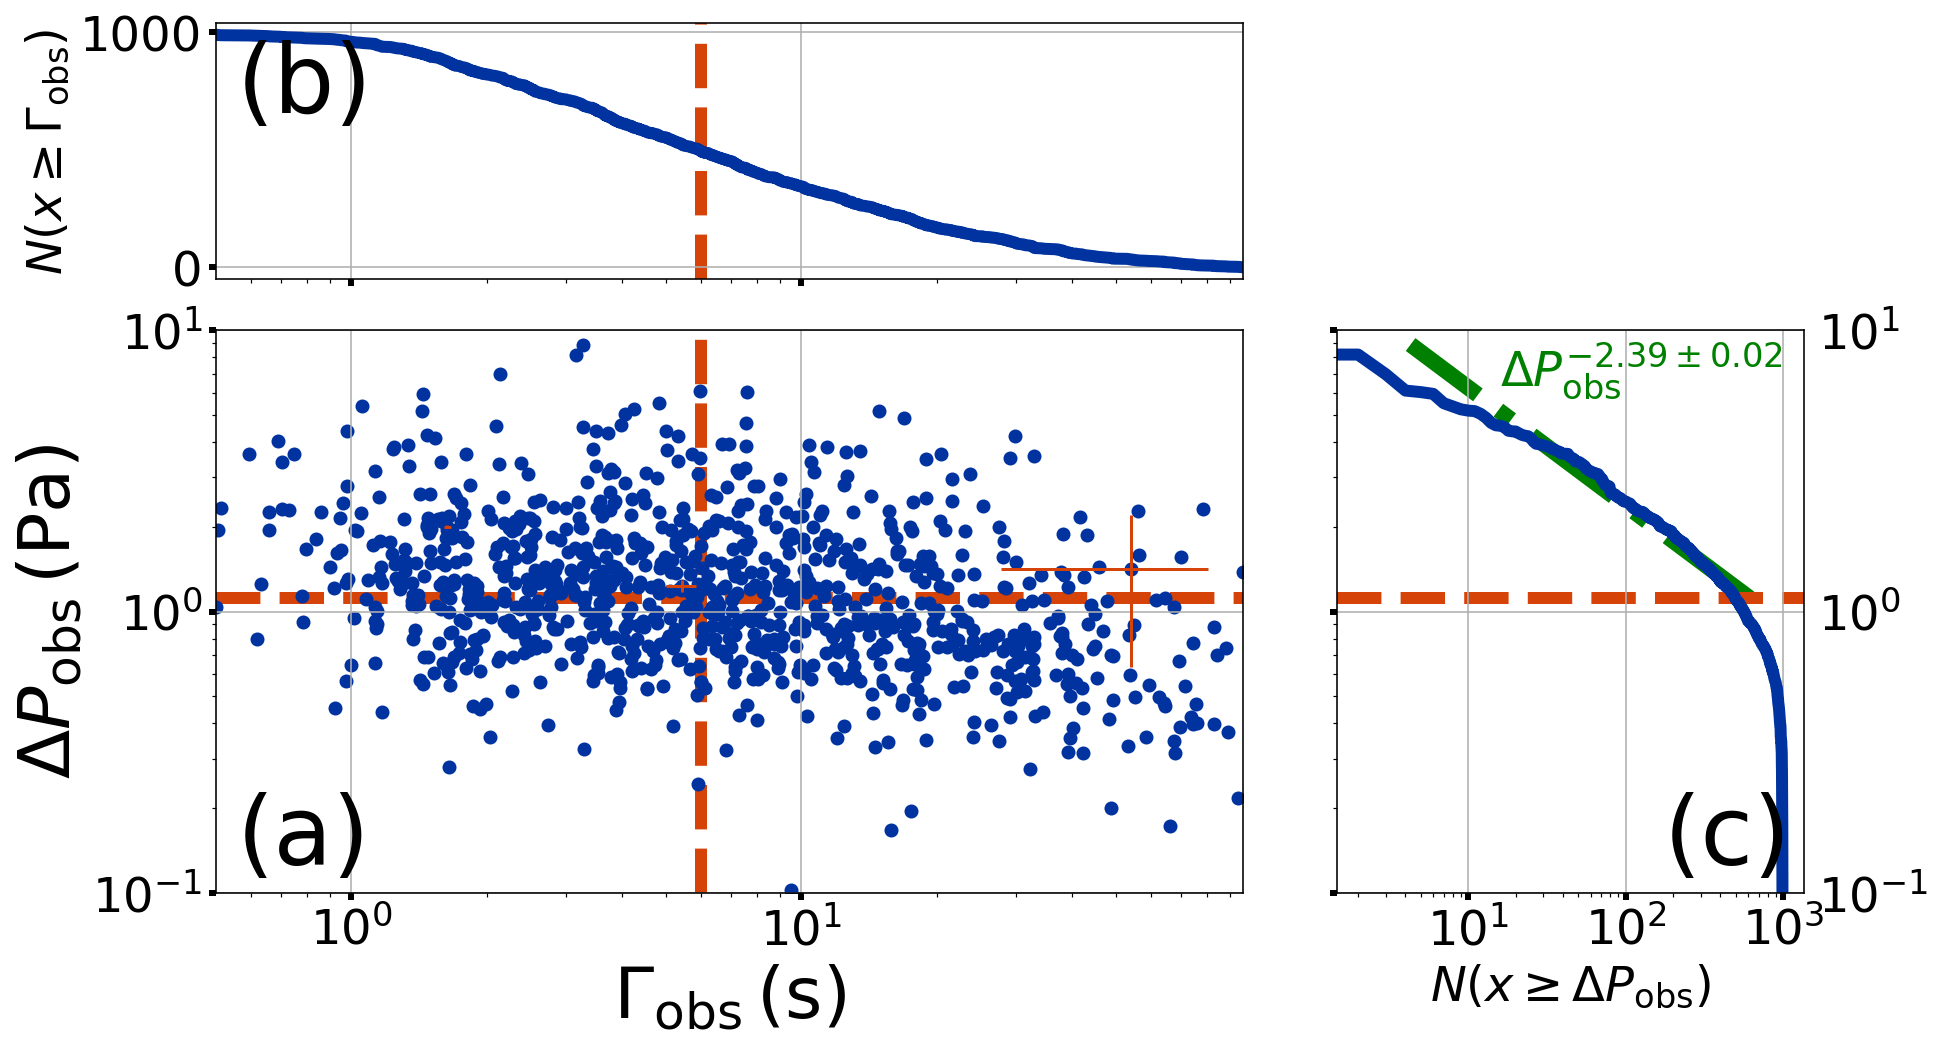

In [4]:
# Change to cumulative histogram
filename = "all_vortices.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

print("number of original vortices: ", len(data))

fig = plt.figure(figsize=(8*aspect_ratio, 8))
ax = fig.add_subplot(111)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)
x = data['Gamma'][ind]
y = data['DeltaP'][ind]
xerr = data['Gamma_unc'][ind]
yerr = data['DeltaP_unc'][ind]

Gammaobs_quantile = np.quantile(x, 0.5)
DeltaPobs_quantile = np.quantile(y, 0.5)
print("number of culled vortices: ", len(x))

print("Gammaobs_quantile, DeltaPobs_quantile: ", Gammaobs_quantile, DeltaPobs_quantile)

### Create axes ###

ax = plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
ax_Gammahist = plt.subplot2grid((3,3), (0,0), colspan=2, sharex=ax)
ax_DeltaPhist = plt.subplot2grid((3,3), (1,2), rowspan=2, sharey=ax)

### Make scatterplot ###

ax.loglog(x, y, marker='o', ls='', color=BoiseState_blue, lw=6, zorder=0)
err_ind = np.argmax(np.sqrt(xerr**2 + yerr**2))
ax.errorbar(x[err_ind], y[err_ind], xerr=xerr[err_ind], yerr=yerr[err_ind], color=BoiseState_orange)
err_ind = np.argmin(np.sqrt(xerr**2 + yerr**2))
ax.errorbar(x[err_ind], y[err_ind], xerr=xerr[err_ind], yerr=yerr[err_ind], color=BoiseState_orange)
err_ind = np.argsort(np.sqrt(xerr**2 + yerr**2))[len(np.sqrt(xerr**2 + yerr**2))//2]
ax.errorbar(x[err_ind], y[err_ind], xerr=xerr[err_ind], yerr=yerr[err_ind], color=BoiseState_orange)

ax.axvline(Gammaobs_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)
ax.axhline(DeltaPobs_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

### Make Gammaobs histogram ###

srt = np.argsort(x)
log_Gammaobs = np.log10(x)[srt]
hst, _ = np.histogram(log_Gammaobs, bins=[-np.inf, *log_Gammaobs])
log_Gammaobs_cum_hst = len(log_Gammaobs) - np.cumsum(hst)

ax_Gammahist.semilogx(10.**log_Gammaobs, log_Gammaobs_cum_hst, lw=6, color=BoiseState_blue)

### Make table of histogram values ###

# tablefile = "Gamma_obs_histogram_table.csv"
# f = open(tablefile, "w")
# f.write("# Gamma_obs\n")
# f.write("# bin_edges, histogram\n")
# fmt1 = "%g, %g\n"
# fmt2 = "%g, \n"
# for i in range(len(bin_edges)):
#     if(i < len(bin_edges) - 1):
#         f.write(fmt1 % (bin_edges[i], Gammaobs_hst[i]))
#     else:
#         f.write(fmt2 % bin_edges[i])
        
# f.close()

### Make Delta Pobs histogram ###

srt = np.argsort(y)
log_DeltaPobs = np.log10(y)[srt]
hst, _ = np.histogram(log_DeltaPobs, bins=[-np.inf, *log_DeltaPobs])
log_DeltaPobs_cum_hst = len(log_DeltaPobs) - np.cumsum(hst)
err = np.sqrt(np.log10(log_DeltaPobs_cum_hst))/(np.log(10.)*np.log10(log_DeltaPobs_cum_hst))

ax_DeltaPhist.loglog(log_DeltaPobs_cum_hst, 10.**log_DeltaPobs, lw=6, color=BoiseState_blue)
# ax_DeltaPhist.errorbar(log_DeltaPobs_cum_hst, 10.**log_DeltaPobs, 
#                        xerr=err, color=BoiseState_blue)

### Make table of histogram values ###
# tablefile = "DeltaP_obs_histogram_table.csv"
# f = open(tablefile, "w")
# f.write("# DeltaP_obs\n")
# f.write("# bin_edges, histogram\n")
# fmt1 = "%g, %g\n"
# fmt2 = "%g, \n"
# for i in range(len(bin_edges)):
#     if(i < len(bin_edges) - 1):
#         f.write(fmt1 % (bin_edges[i], Pobs_hst[i]))
#     else:
#         f.write(fmt2 % bin_edges[i])
        
# f.close()

### Fit Delta Pobs hist with power-law ###

# mx_ind = np.argmin(np.abs(DeltaPobs_quantile - 10.**Pobs_bins))

# Only fit the values above the 50% quintile
srt = np.argsort(y)
log_DeltaPobs = np.log10(y)[srt]
log_DeltaPobs = log_DeltaPobs[log_DeltaPobs > np.log10(DeltaPobs_quantile)]
hst, _ = np.histogram(log_DeltaPobs, bins=[-np.inf, *log_DeltaPobs])
log_DeltaPobs_cum_hst = len(log_DeltaPobs) - np.cumsum(hst)
err = np.sqrt(np.log10(log_DeltaPobs_cum_hst))/(np.log(10.)*np.log10(log_DeltaPobs_cum_hst))
ind = np.isfinite(err)

popt, pcov = curve_fit(line, log_DeltaPobs[ind], np.log10(log_DeltaPobs_cum_hst[ind]))
uncertainties = np.diag(np.sqrt(pcov))
ax_DeltaPhist.plot(10.**np.polyval(popt, log_DeltaPobs), 10.**log_DeltaPobs, 
                       ls='-.', lw=8, color='green', zorder=-1)

### Tweak and label axes
ax_DeltaPhist.text(0.35, 0.9, r'$\Delta P_{\rm obs}^{%.2f\pm%.2f}$' % (popt[0], uncertainties[0]), 
                   fontsize=24, transform=ax_DeltaPhist.transAxes, color='green')

ax.grid(True)
ax_Gammahist.grid(True)
ax_DeltaPhist.grid(True)
ax.tick_params(labelsize=24)
ax_Gammahist.tick_params(labelbottom=False, labelsize=24)
ax_DeltaPhist.tick_params(labelleft=False, labelright=True, labelsize=24)

ax.set_xlabel(r'$\Gamma_{\rm obs}\,\left( {\rm s} \right)$', fontsize=36)
ax.set_ylabel(r'$\Delta P_{\rm obs}\,\left( {\rm Pa} \right)$', fontsize=36)
ax_DeltaPhist.set_xlabel(r'$N\left(x \geq \Delta P_{\rm obs}\right)$', fontsize=24)
ax_Gammahist.set_ylabel(r'$N\left(x \geq \Gamma_{\rm obs}\right)$', fontsize=24)

ax.text(0.02, 0.05, "(a)", fontsize=48, transform=ax.transAxes)
ax_Gammahist.text(0.02, 0.65, "(b)", fontsize=48, transform=ax_Gammahist.transAxes)
ax_DeltaPhist.text(0.7, 0.05, "(c)", fontsize=48, transform=ax_DeltaPhist.transAxes)

ax.set_xlim([np.min(x), np.max(x)])
ax.set_ylim([0.1, 10])

ax_Gammahist.axvline(Gammaobs_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)
ax_DeltaPhist.axhline(DeltaPobs_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

# fig.savefig("../figures/DeltaPobs_vs_Gammaobs.png", dpi=500, bbox_inches="tight")

saved_popt = popt

[-1.74684654  3.34231275]


Text(0, 0.5, '$N$')

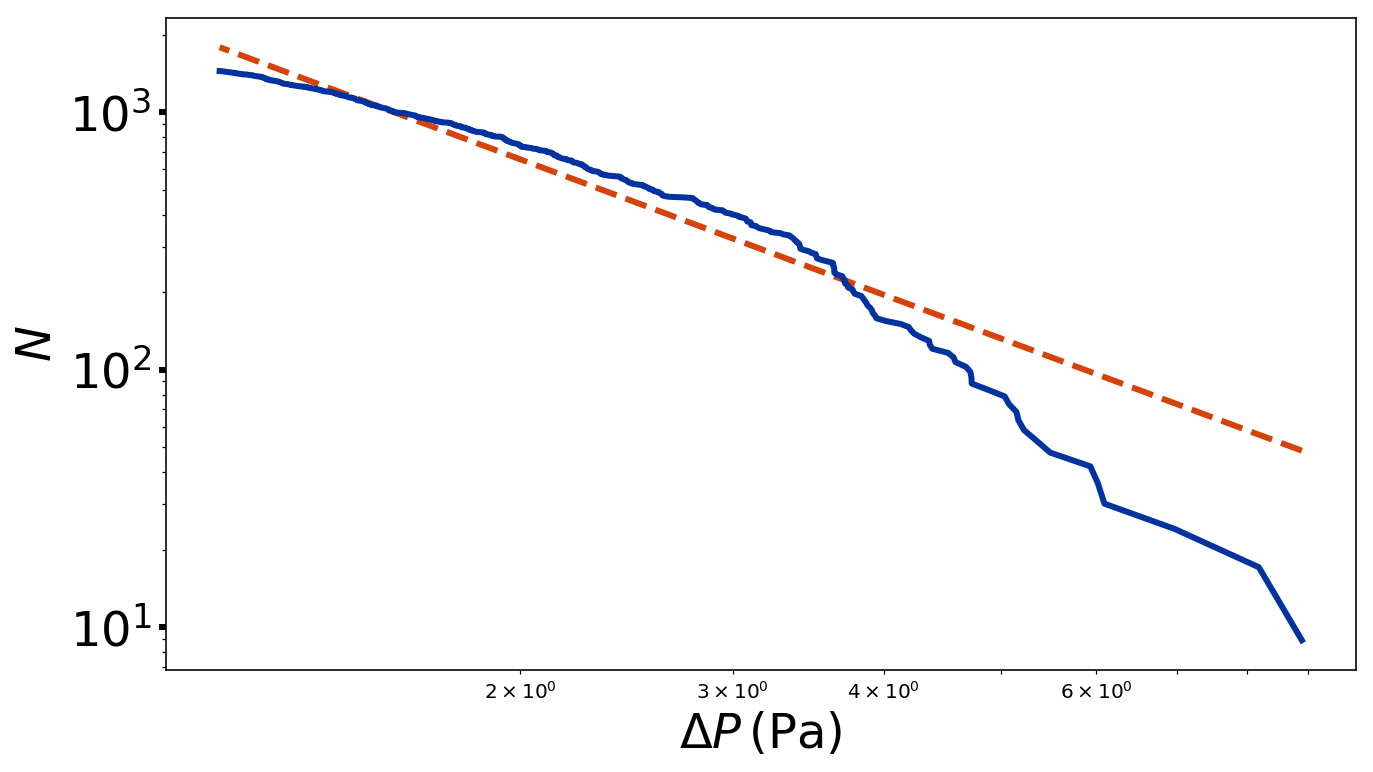

In [92]:
# Cumulative histogram of Delta Pobs
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

filename = "all_vortices_2020Aug9.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)

DeltaP = data['DeltaP'][ind]

DeltaPobs_quantile = np.quantile(DeltaP, 0.5)
ind = DeltaP > DeltaPobs_quantile
DeltaP = DeltaP[ind]

srt = np.argsort(DeltaP)[::-1]
DeltaP = DeltaP[srt]

cum_hst = np.cumsum(DeltaP)
x = DeltaP
y = cum_hst
yerr = np.sqrt(np.log10(y))/(np.log(10.)*np.log10(y))

ax.loglog(x, y, lw=3, color=BoiseState_blue)

# popt, pcov = curve_fit(line, np.log10(x), np.log10(y), sigma=yerr)
# uncertainties = np.sqrt(np.diag(pcov))
# print(popt)
# print(uncertainties)

fit_params = np.polyfit(np.log10(x), np.log10(y), 1)
print(fit_params)
ax.loglog(x, 10**np.polyval(fit_params, np.log10(x)), ls='--', lw=3, color=BoiseState_orange, zorder=-1)

# ax.text(0.05, 0.05, r'$\gamma = %.1f\pm%.1f$' % (popt[0], uncertainties[0]), 
#         transform=ax.transAxes, fontsize=24, color='green')

# ax.text(0.05, 0.15, r'$\gamma - 1 = %.2g$' % (fit_params[0] - 1.), 
#         transform=ax.transAxes, fontsize=24, color=BoiseState_orange)
ax.tick_params(labelsize=24)
ax.set_xlabel(r'$\Delta P\,\left({\rm Pa}\right)$', fontsize=24)
ax.set_ylabel(r'$N$', fontsize=24)

<Figure size 768x432 with 0 Axes>

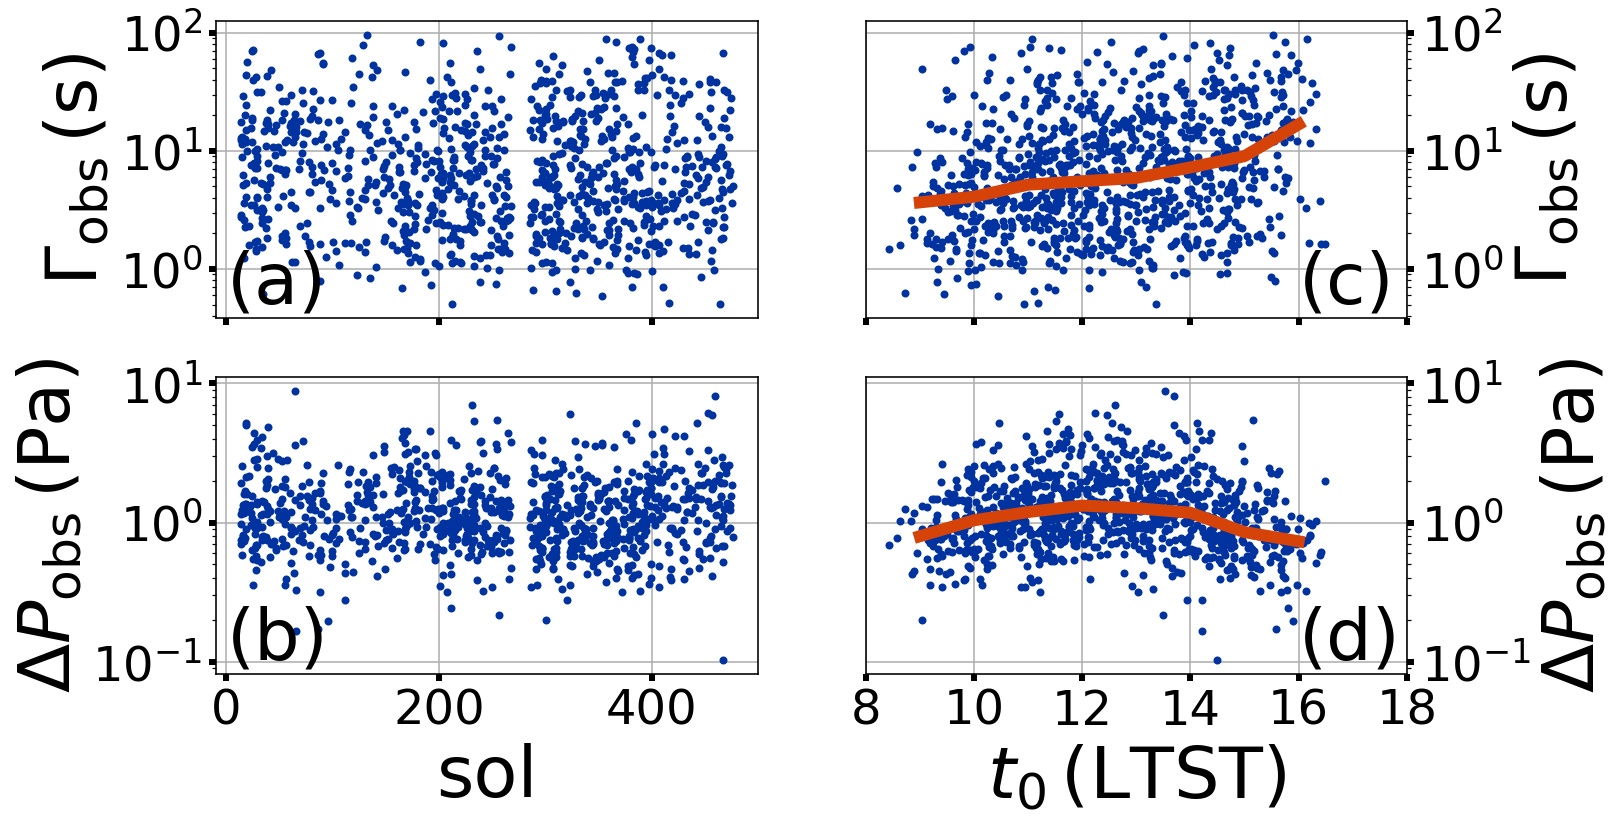

In [62]:
fig = plt.figure(figsize=(6*aspect_ratio, 6), constrained_layout=True)

filename = "all_vortices.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)

### Plot by sol ###

sols = data['sol'][ind]
x = data['Gamma'][ind]
y = data['DeltaP'][ind]
xerr = data['Gamma_unc'][ind]
yerr = data['DeltaP_unc'][ind]

bins = int(max(sols) - min(sols))

fig = plt.figure(figsize=(6*aspect_ratio, 6))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)

ax1.semilogy(sols, x, marker='.', color=BoiseState_blue, ls='')
# rng = np.arange(np.floor(np.min(sols)), np.ceil(np.max(sols)), 1)
# inds = np.digitize(sols, rng)
# unq = np.unique(inds)
# sav_sols = np.array([])
# sols_meds = np.array([])
# for i in range(len(unq)):
#     where_ind = np.where(inds == unq[i])
#     if(len(x[where_ind[0]]) > 0):
#         sav_sols = np.append(sav_sols, sols[where_ind[0]][0])
#         sols_meds = np.append(sols_meds, np.median(np.log10(x[where_ind[0]])))
# ax1.plot(sav_sols, 10.**sols_meds, color=BoiseState_orange, lw=1, alpha=0.5)

ax2.semilogy(sols, y, marker='.', color=BoiseState_blue, ls='')
# sav_sols = np.array([])
# sols_meds = np.array([])
# for i in range(len(unq)):
#     where_ind = np.where(inds == unq[i])
#     if(len(x[where_ind[0]]) > 0):
#         sav_sols = np.append(sav_sols, sols[where_ind[0]][0])
#         sols_meds = np.append(sols_meds, np.median(np.log10(y[where_ind[0]])))
# ax2.plot(sav_sols, 10.**sols_meds, color=BoiseState_orange, lw=1, alpha=0.5)

ax1.grid(True)
ax1.tick_params(labelbottom=False, labelsize=24)
ax1.set_ylabel(r'$\Gamma_{\rm obs}\,\left( {\rm s} \right)$', fontsize=36)

ax2.grid(True)
ax2.tick_params(labelsize=24)
ax2.set_xlabel('sol', fontsize=36)
ax2.set_ylabel(r'$\Delta P_{\rm obs}\,\left( {\rm Pa} \right)$', fontsize=36)

ax1.text(0.02, 0.05, "(a)", fontsize=36, transform=ax1.transAxes)
ax2.text(0.02, 0.05, "(b)", fontsize=36, transform=ax2.transAxes)

### Plot by time-of-day ###

TOD = data['t0'][ind]
x = data['Gamma'][ind]
y = data['DeltaP'][ind]
xerr = data['Gamma_unc'][ind]
yerr = data['DeltaP_unc'][ind]

ax3 = fig.add_subplot(222, sharey=ax1)
ax4 = fig.add_subplot(224, sharex=ax3, sharey=ax2)

ax3.semilogy(TOD, x, marker='.', color=BoiseState_blue, ls='')

### Median by TOD ###

rng = np.arange(np.floor(np.min(TOD)) - 0.5, np.ceil(np.max(TOD)) + 0.5, 1)
sav_TOD = np.array([])
TOD_meds = np.array([])
TOD_mads = np.array([])

# inds = np.digitize(TOD, rng)
# unq = np.unique(inds)
# for i in range(len(unq)):
#     where_ind = np.where(inds == unq[i])
#     if(len(x[where_ind[0]]) > 0):
#         sav_TOD = np.append(sav_TOD, TOD[where_ind[0]][0])
#         TOD_meds = np.append(TOD_meds, np.median(x[where_ind[0]]))
#         TOD_mads = np.append(TOD_mads, mad(x[where_ind[0]])/np.sqrt(len(x[where_ind[0]]) - 1.))
# ax3.semilogy(sav_TOD, TOD_meds, color=BoiseState_orange, lw=6)
# popt, pcov = curve_fit(line, sav_TOD, TOD_meds, sigma=TOD_mads)
# uncertainties = np.sqrt(np.diag(pcov))
# print("np.min(TOD_meds), np.max(TOD_meds): ", np.min(TOD_meds), np.max(TOD_meds))
# print("popt: ", popt)
# print("uncertainties: ", uncertainties)
# print("sav_TOD: ", sav_TOD)

for i in range(len(rng)-1):
    ind = (TOD >= rng[i]) & (TOD < rng[i+1])
    if(len(x[ind]) > 3):
        sav_TOD = np.append(sav_TOD, 0.5*(rng[i] + rng[i+1]))
        TOD_meds = np.append(TOD_meds, np.median(x[ind]))
ax3.semilogy(sav_TOD, TOD_meds, color=BoiseState_orange, lw=6)

Gamma_TOD = sav_TOD
Gamma_meds = TOD_meds

ax4.semilogy(TOD, y, marker='.', color=BoiseState_blue, ls='')

### Median by TOD ###

sav_TOD = np.array([])
TOD_meds = np.array([])
TOD_mads = np.array([])
# for i in range(len(unq)):
#     where_ind = np.where(inds == unq[i])
#     if(len(x[where_ind[0]]) > 0):
#         sav_TOD = np.append(sav_TOD, TOD[where_ind[0]][0])
#         TOD_meds = np.append(TOD_meds, np.median(y[where_ind[0]]))
#         TOD_mads = np.append(TOD_mads, mad(y[where_ind[0]])/np.sqrt(len(y[where_ind[0]]) - 1.))

for i in range(len(rng)-1):
    ind = (TOD >= rng[i]) & (TOD < rng[i+1])
    if(len(x[ind]) > 3):
        sav_TOD = np.append(sav_TOD, 0.5*(rng[i] + rng[i+1]))
        TOD_meds = np.append(TOD_meds, np.median(y[ind]))

ax4.semilogy(sav_TOD, TOD_meds, color=BoiseState_orange, lw=6)

# Checking that the values of Delta P at either end of the TOD plot are statistically equivalent.
mx_ind = np.argmax(TOD_meds)
# print("sav_TOD[mx_ind], TOD_meds[mx_ind], TOD_mads[mx_ind]: ", sav_TOD[mx_ind], TOD_meds[mx_ind], TOD_mads[mx_ind])
# print("TOD_meds[0], TOD_mads[0]: ", TOD_meds[0], TOD_mads[0])
# print("TOD_meds[-1], TOD_mads[-1]: ", TOD_meds[-1], TOD_mads[-1])
# print("(TOD_meds[mx_ind] - np.min(TOD_meds))/np.sqrt(TOD_mads[mx_ind]**2 + np.min(TOD_mads)**2): ", 
#       (TOD_meds[mx_ind] - np.min(TOD_meds))/np.sqrt(TOD_mads[mx_ind]**2 + np.min(TOD_mads)**2))

ax3.grid(True)
ax3.tick_params(labelbottom=False, labelsize=24)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.set_xticks([8, 10, 12, 14, 16, 18])

ax4.grid(True)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.tick_params(labelright=True, labelleft=False, labelsize=24)
ax4.set_xticks([8, 10, 12, 14, 16, 18])

ax3.set_ylabel(r'$\Gamma_{\rm obs}\,\left( {\rm s} \right)$', fontsize=36)
ax4.set_xlabel(r'$t_0\,\left({\rm LTST}\right)$', fontsize=36)
ax4.set_ylabel(r'$\Delta P_{\rm obs}\,\left( {\rm Pa} \right)$', fontsize=36)

ax3.text(0.8, 0.05, "(c)", fontsize=36, transform=ax3.transAxes)
ax4.text(0.8, 0.05, "(d)", fontsize=36, transform=ax4.transAxes)

# ax2.set_yticks([0, 5, 10])
# ax4.set_yticks([0, 5, 10])

fig.savefig("../figures/Gammaobs_DeltaPobs_vs_TOD_and_sol.png", dpi=500, bbox_inches="tight")

In [3]:
# 2020 Dec 4 - Figure out during how many sols were observed by the pressure logger during each hour of the day
#   and what was the average windspeed during each sol and each hour of each sol.
binsize = 1
hourly_bin_edges = np.arange(0, 25, binsize)
print_str = "sol, median_wind"
for cur_edge in hourly_bin_edges[0:-1]:
    print_str += (", %d_median_wind, %d_hour_fraction" % (cur_edge, cur_edge))

text_file = open("sols_hour_median_winds.csv", "w")
# print(print_str)
text_file.write(print_str + "\n")

all_sols = np.arange(14, 477)
for cur_sol in all_sols:
    
    try:
        wind_LTST, wind_LTST_and_sol, wind_data = find_wind(cur_sol, dr_wind=dr_wind)
        daily_med_wind = np.nanmedian(wind_data["HORIZONTAL_WIND_SPEED"])

        print_str = "%d, %g" % (cur_sol, daily_med_wind)

        for cur_edge in hourly_bin_edges[0:-1]:
            ind = (wind_LTST >= cur_edge) & (wind_LTST < cur_edge + binsize)
            
            cur_print_str = ", , "
        
            if(len(wind_LTST[ind]) > 1):
                
                # I'm assuming that I observe through the whole hour.
                mn = np.min(wind_LTST[ind])
                mx = np.max(wind_LTST[ind])

                frac = (mx - mn)/binsize
                hourly_med_wind = np.nanmedian(wind_data["HORIZONTAL_WIND_SPEED"][ind])
                
                cur_print_str = (", %g, %g" % (hourly_med_wind, frac))
            else:
                cur_print_str = (", %g, %g" % (0., 0.))
                
            print_str += cur_print_str
                
#         print(print_str)
        text_file.write(print_str + "\n")
    except:
        pass
    
text_file.close()

31 doesn't have windspeed data!
93 doesn't have windspeed data!
109 doesn't have windspeed data!
110 doesn't have windspeed data!
111 doesn't have windspeed data!
121 doesn't have windspeed data!
122 doesn't have windspeed data!
270 doesn't have windspeed data!
271 doesn't have windspeed data!
272 doesn't have windspeed data!
273 doesn't have windspeed data!
274 doesn't have windspeed data!
275 doesn't have windspeed data!
276 doesn't have windspeed data!
277 doesn't have windspeed data!
278 doesn't have windspeed data!
279 doesn't have windspeed data!
280 doesn't have windspeed data!
281 doesn't have windspeed data!
282 doesn't have windspeed data!
283 doesn't have windspeed data!


<Figure size 768x432 with 0 Axes>

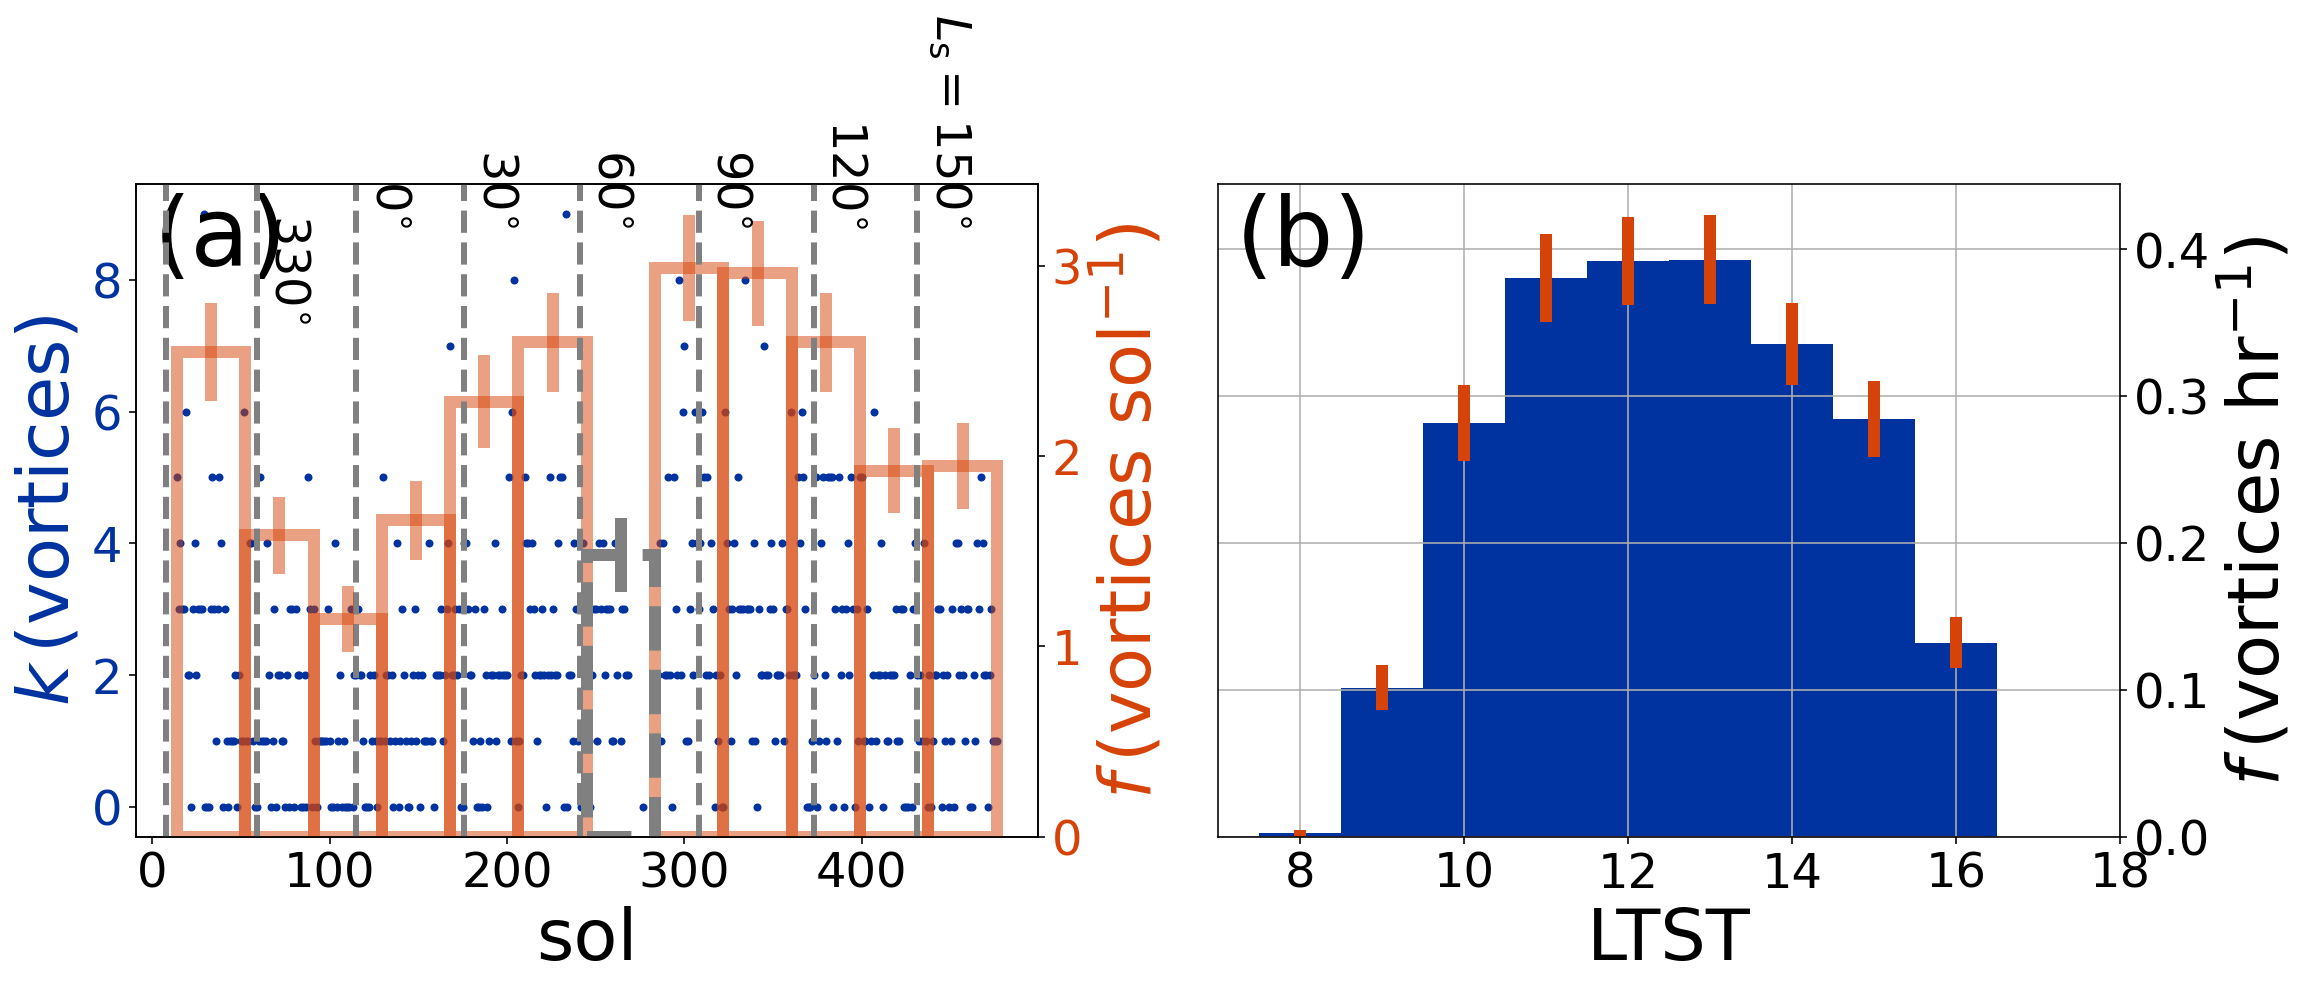

In [2]:
# 2021 Jan 6 (Day 1 of trump's Insurrection) - I recorded the fraction of each hour for each sol during which
#   pressure logger data were recorded.

data_file = np.genfromtxt("sols_hour_median_winds.csv", delimiter=',', names=True)
def hour_frac(hour, sol):
    sol_ind = data_file['sol'] == sol
    hour_key = str(hour) + "_hour_fraction"
    
    return data_file[hour_key][sol_ind]

def how_many_hours(hour):
    # During most sols, all 24 hours are observed completely. But during some, only a fraction of an hour is observed.
    # This routine totals up the fraction of a particular hour was observed across all sols.
    # 
    # For example, on sol 422, 0% of the hour between 1 and 2 LTST was observed. On sol 423, 100% was observed.
    # If these were the only two sols on which that hour was observed, it would have been observed for a total of 
    # 1 hour.
    
    hour_key = str(hour) + "_hour_fraction"
    return np.sum(data_file[hour_key])

fig = plt.figure(figsize=(6*aspect_ratio, 6), constrained_layout=True)

filename = "all_vortices.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)

### Plot by sol ###

sols = data['sol'][ind]
x = data['Gamma'][ind]
y = data['DeltaP'][ind]
xerr = data['Gamma_unc'][ind]
yerr = data['DeltaP_unc'][ind]

bins = np.arange(np.floor(np.min(sols)) - 0.5, np.ceil(np.max(sols)) + 1.5, 1)

# 2021 Mar 19 - Exclude sols during solar conjunction
solar_conjunction_begin = 270
solar_conjunction_end = 283

oind = (bins < solar_conjunction_begin - 0.5) | (bins > solar_conjunction_end + 0.5)
bins = bins[oind]

fig = plt.figure(figsize=(10*aspect_ratio, 6))

ax1 = fig.add_subplot(121)
ax3 = ax1.twinx()
ax2 = fig.add_subplot(122)

hst, bin_edges = np.histogram(sols, bins=bins)
bins = 0.5*(bin_edges[1:] + bin_edges[0:-1])
srt = np.argsort(hst)[::-1]
ax1.plot(bins, hst, marker='.', color=BoiseState_blue, ls='', zorder=1)

# ax1.errorbar(bins, hst, yerr=yerr, color=BoiseState_blue, ls='', zorder=1)

hst, bin_edges = np.histogram(sols, bins='auto')
bins = 0.5*(bin_edges[1:] + bin_edges[0:-1])
binsize = np.median(bins[1:] - bins[0:-1])
yerr = np.sqrt(hst)/binsize

# 2021 Mar 19 - Greying out the bin corresponding to the solar conjunction
oind = (bins + 0.5*binsize >= solar_conjunction_begin) & (bins - 0.5*binsize  <= solar_conjunction_end)
ax3.bar(bins[~oind], hst[~oind]/binsize, width=binsize, edgecolor=BoiseState_orange, color='None', lw=6, alpha=0.5, zorder=-1)
err_ind = hst > 0.
ax3.errorbar(bins[err_ind], hst[err_ind]/binsize, yerr=yerr[err_ind], ls='', color=BoiseState_orange, alpha=0.5, lw=6)

# print("several sols binned: ", binsize)
# print("# per sol: ", np.min(hst/binsize), np.max(hst/binsize))
# yerr = np.sqrt(hst/binsize)
# ax3.errorbar(bins, hst/binsize, yerr=yerr, color=BoiseState_orange, ls='', lw=6, zorder=-1, alpha=0.5)

sol_bin_edges = bin_edges
sol_bins = bins
sol_hst = hst/binsize
sol_hst_err = yerr

ax3.bar(bins[oind], hst[oind]/binsize, width=binsize, edgecolor='grey', color='None', lw=6, ls='--', zorder=-1)
ax3.errorbar(bins[oind], hst[oind]/binsize, yerr=yerr[oind], 
             ls='', color='grey', lw=6)

### Plot by time-of-day ###

TOD = data['t0'][ind]
x = data['Gamma'][ind]
y = data['DeltaP'][ind]
xerr = data['Gamma_unc'][ind]
yerr = data['DeltaP_unc'][ind]

binsize = 1.
bins = np.arange(np.floor(np.min(TOD)) - 0.5*binsize, np.ceil(np.max(TOD)) + 1. + 0.5*binsize, binsize)
# hst, bin_edges = np.histogram(TOD, bins=bins)
# hst, bin_edges, patches = ax2.hist(TOD, bins=bins, color=BoiseState_blue, lw=6)
all_hst, bin_edges = np.histogram(TOD, bins=bins)
hst = np.zeros_like(all_hst)
yerr = np.zeros_like(all_hst)

hst = hst.astype(float)
yerr = yerr.astype(float)
# 2020 Oct 9 - Calculate total number of hours over all days
for i in range(len(bins[:-1])):
    ind = (TOD >= bins[i]) & (TOD < bins[i+1])
    hst[i] = float(len(TOD[ind])/how_many_hours(int(np.floor(bins[i]))))
    yerr[i] = np.sqrt(len(TOD[ind]))/how_many_hours(int(np.floor(bins[i])))
    
# bins = np.arange(8, 17, 1)
bins = 0.5*(bin_edges[1:] + bin_edges[0:-1])

# 2020 Dec 3 - This isn't really a bar graph because I'm dividing through by the total number of hours over the 
#   entire course of the observation.
ax2.bar(bins, hst/binsize, width=binsize, color=BoiseState_blue, lw=6)

# hst, bin_edges, patches = ax2.hist(TOD, bins='auto', color=BoiseState_blue, lw=6)

# print("binned by hour?: ", binsize)
# print("# per sol: ", np.min(hst/binsize), np.max(hst/binsize))

# yerr = np.sqrt(hst)/binsize
# print("hst: ", hst)
# ax2.plot(bins, hst, marker='o', color=BoiseState_blue, ls='', zorder=1)
# print(yerr)
ax2.errorbar(bins, hst/binsize, yerr=yerr, color=BoiseState_orange, ls='', lw=6, marker='')

ax1.tick_params(labelsize=24)
ax1.tick_params(axis='y', labelcolor=BoiseState_blue)
ax2.tick_params(labelsize=24)
ax3.tick_params(labelsize=24)
ax3.tick_params(axis='y', labelcolor=BoiseState_orange)

ax1.set_xlabel('sol', fontsize=36)
ax1.set_ylabel(r'$k\,\left({\rm vortices} \right)$', fontsize=36, color=BoiseState_blue)
ax3.set_ylabel(r'$f\,\left({\rm vortices\ sol^{-1}} \right)$', fontsize=36, color=BoiseState_orange)

ax2.set_xlabel("LTST", fontsize=36)
ax2.set_ylabel(r'$f\,\left({\rm vortices\ hr^{-1}} \right)$', fontsize=36)

ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.grid(True)

ax1.text(0.02, 0.875, "(a)", fontsize=48, transform=ax1.transAxes)
ax2.text(0.02, 0.875, "(b)", fontsize=48, transform=ax2.transAxes)

# Fit slope to either side of the peak
mx_ind = np.argmax(hst)

# Only include bins to the left of the peak that have points in them
# ind = hst[0:mx_ind+1] > 0.
# temp_x = bins[0:mx_ind+1][ind]
# temp_y = hst[0:mx_ind+1][ind]
# temp_yerr = yerr[0:mx_ind+1][ind]/hst[mx_ind]
# fit_params = np.polyfit(temp_x, temp_y, 1)
# ax2.plot(temp_x, np.polyval(fit_params, temp_x), lw=6, ls='--', color='green')
# ax2.text(0.025, 0.7, r'$\frac{dN}{dt} = %.0f\,{\rm hr^{-1}}$' % fit_params[0]*100, 
#          color='green', fontsize=36, transform=ax2.transAxes, rotation=50)

# print(fit_params)
# ax2.plot(temp_x, np.polyval(fit_params, temp_x), color=BoiseState_orange, lw=6, ls='--')

# Only include bins to the right of the peak that have points in them
# ind = hst[mx_ind:] > 0.
# temp_x = bins[mx_ind:][ind]
# temp_y = hst[mx_ind:][ind]
# temp_yerr = yerr[mx_ind:][ind]/hst[mx_ind]
# fit_params = np.polyfit(temp_x, temp_y, 1)
# uncertainties = np.sqrt(np.diag(cov))
# ax2.plot(temp_x, np.polyval(fit_params, temp_x), lw=6, ls='--', color='green')
# ax2.text(0.02, 0.7, r'$%.0f\pm%.0f\,{\rm hr^{-1}}$' % (fit_params[0], uncertainties[0]), 
#          color='green', fontsize=24, transform=ax2.transAxes, rotation=50)

# print(fit_params)
# ax2.plot(temp_x, np.polyval(fit_params, temp_x), color=BoiseState_orange, lw=6, ls='--')

# ax2.set_ylim([0.9, 1.3])

# 2021 Jan 14 - Adding Ls using this website - http://www-mars.lmd.jussieu.fr/mars/time/martian_time.html
#
# How did I calculate these, you ask? As follows:
#   1. Choose desired Ls-values to display - 0, 30, 60, etc. (corresponding to Spiga's spacing)
#   2. Figured out the Mars year and sol when InSight landed using the above website -- MY 34, sol 555
#   3. Calculated the date corresponding to each Ls for the desired year using this website 
#      (http://www-mars.lmd.jussieu.fr/mars/time/mars_date_to_earth_date.html) - 
#      E.g., Ls = 0 during the first year means MY 35 is 2019 Mar 23. Type that date back into the former
#      website to calculate the sol # (sol 1 in MY 35)
#   4. There are 668.59 sols in one Mars year, so since InSight landed in MY 34, 
#      sol 1 in MY 35 is mission sol 668.59 + 1 - 555 = 115.
#
# Check notebook notes from today for the conversions!
ax3.axvline(115, lw=3, ls='--', color='grey', zorder=-1)
ax3.text(121, 3.25, r'$0^{\circ}$',rotation=-90, color='k', fontsize=24)

ax3.axvline(176, lw=3, ls='--', color='grey', zorder=-1)
ax3.text(181, 3.25, r'$30^{\circ}$',rotation=-90, color='k', fontsize=24)

ax3.axvline(241, lw=3, ls='--', color='grey', zorder=-1)
ax3.text(246, 3.25, r'$60^{\circ}$',rotation=-90, color='k', fontsize=24)

ax3.axvline(308, lw=3, ls='--', color='grey', zorder=-1)
ax3.text(313, 3.25, r'$90^{\circ}$',rotation=-90, color='k', fontsize=24)

ax3.axvline(373, lw=3, ls='--', color='grey', zorder=-1)
ax3.text(378, 3.25, r'$120^{\circ}$',rotation=-90, color='k', fontsize=24)

ax3.axvline(431, lw=3, ls='--', color='grey', zorder=-1)
ax3.text(436, 3.25, r'$L_{\rm s} = 150^{\circ}$',rotation=-90, color='k', fontsize=24)

ax3.axvline(8, lw=3, ls='--', color='grey', zorder=-1)
# ax3.text(13, 3.25, r'$300^{\circ}$',rotation=-90, color='k', fontsize=24)

ax3.axvline(59, lw=3, ls='--', color='grey', zorder=-1)
ax3.text(64, 2.75, r'$330^{\circ}$',rotation=-90, color='k', fontsize=24)

# fig.savefig("../figures/sol_and_t0_histograms.png", dpi=500, bbox_inches="tight")

TOD_bins = bins
TOD_hst = hst/binsize
TOD_hst_err = yerr

In [46]:
# 2020 Oct 16 - Find windspeeds during times and sols when vortices are NOT detected

data = np.genfromtxt(filename, delimiter=',', names=True)
# Toss the ones at either end

# ('vortex_number', 'sol', 't0', 't0_unc', 'DeltaP', 'DeltaP_unc', 'Gamma', 'Gamma_unc', 'slope', 'slope_unc', 
# 'intercept', 'intercept_unc', 'U', 'U_unc', 'Diameter', 'Diameter_unc')
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)

all_sols = np.arange(np.min(data['sol'][ind]), np.max(data['sol'][ind]))
# All the sols during which no vortices are detected
all_sols_wo_vortices = all_sols[~np.isin(all_sols, data['sol'][ind])]

# Check which sols without vortices also have data
all_sols_wo_vortices_but_with_data = []
for i in range(len(all_sols_wo_vortices)):
    fn = create_datafilename(all_sols_wo_vortices[i], filename_stem="_model_", dr=dr_wind)
    if(len(fn) > 0):
        all_sols_wo_vortices_but_with_data.append(int(all_sols_wo_vortices[i]))
        
# wind_LTST, wind_LTST_and_sol, wind_data = find_wind(all_sols_wo_vortices[21])

# if(wind_LTST is not None):
#     plt.scatter(wind_LTST, wind_data['HORIZONTAL_WIND_SPEED'])
#     for cur_t0 in data['t0'][ind]:
#         plt.axvline(cur_t0, color=BoiseState_orange, zorder=-1)

#     windspeeds = np.zeros_like(data['t0'][ind])
#     for i in range(len(data['t0'][ind])):
#         windspeeds[i] = wind_data['HORIZONTAL_WIND_SPEED'][np.argmin(np.abs(wind_LTST - data['t0'][ind][i]))]

# plt.scatter(data['t0'][ind], windspeeds)

[22, 23, 30, 32, 40, 43, 48, 58, 59, 62, 67, 70, 75, 77, 80, 84, 85, 87, 90, 94, 98, 100, 101, 102, 104, 107, 113, 120, 123, 124, 127, 131, 136, 139, 144, 145, 151, 155, 159, 164, 172, 174, 175, 183, 184, 186, 189, 206, 222, 232, 234, 242, 247, 260, 262, 264, 269, 284, 293, 317, 321, 322, 341, 369, 370, 371, 375, 384, 390, 396, 404, 412, 424, 425, 426, 428, 437, 439, 445, 449, 452, 461, 462, 471]


Text(0, 0.5, '$N\\left( \\Delta P_{\\rm obs}\\right)$')

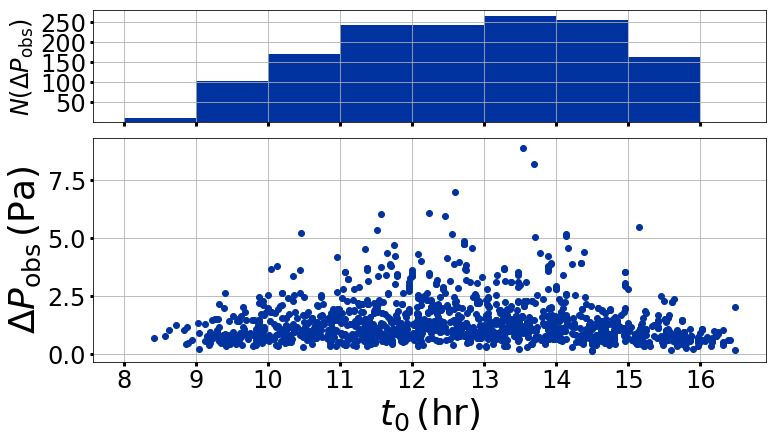

In [3]:
filename = "all_vortices_2020Aug9.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# Toss the ones at either end
ind = (data['Gamma'] > 0.5) & (data['Gamma'] < 300.) & (data['DeltaP'] > 0.1)

TOD = data['t0'][ind]
x = data['Gamma'][ind]
y = data['DeltaP'][ind]
xerr = data['Gamma_unc'][ind]
yerr = data['DeltaP_unc'][ind]

# plot it
fig = plt.figure(figsize=(6*aspect_ratio, 6), constrained_layout=True)

gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[1:, :])
ax2 = fig.add_subplot(gs[0, 0], sharex=ax1)

ax1.plot(TOD, y, marker='o', color=BoiseState_blue, ls='')

bins = np.arange(np.floor(np.min(TOD)), np.ceil(np.max(TOD)), 1)
hst, bin_edges, patches = ax2.hist(TOD, bins=bins, color=BoiseState_blue)

ax1.tick_params(labelsize=24)
ax1.set_xticks(bins)
ax1.grid(True)
ax2.tick_params(labelbottom=False, labelsize=24)
ax2.set_yticks([50, 100, 150, 200, 250])
ax2.grid(True)
ax1.set_xlabel(r'$t_0\,\left({\rm hr}\right)$', fontsize=36)
ax1.set_ylabel(r'$\Delta P_{\rm obs}\,\left( {\rm Pa} \right)$', fontsize=36)
ax2.set_ylabel(r'$N\left( \Delta P_{\rm obs}\right)$', fontsize=24)

sampling:  0.9999999998626663


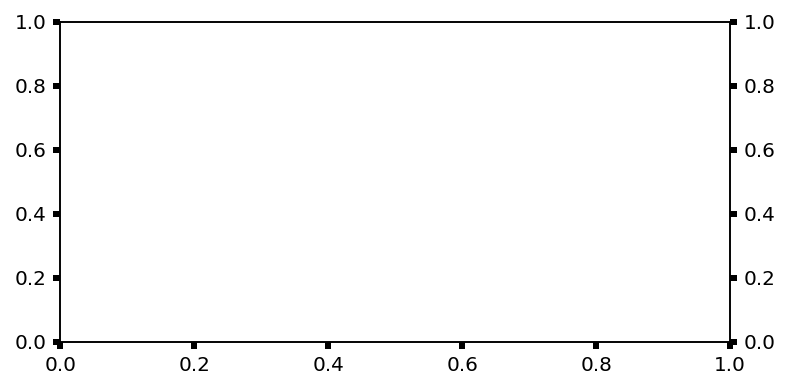

In [3]:
# 2020 Sep 1 - START HERE!

fig = plt.figure(figsize=(6, 10))

filename = "all_vortices_2020Aug9.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)
sols = data['sol'][ind]
t0 = data['t0'][ind]
t0_err = data['t0_unc'][ind]
Gamma = data['Gamma'][ind]
DeltaP = data['DeltaP'][ind]
Gamma_err = data['Gamma_unc'][ind]
DeltaP_err = data['DeltaP_unc'][ind]
slope = data['slope'][ind]
intercept = data['intercept'][ind]

### Maximum Duration ###

mx_Gamma_ind = np.argmax(Gamma)
ax_mx = fig.add_subplot(311)
ax_mx_wind = ax_mx.twinx()
wind_LTST, wind_LTST_and_sol, wind_data = find_wind(sols[mx_Gamma_ind], dr_wind=dr_wind)
wind_LTST_and_sol -= 24.*sols[mx_Gamma_ind]

LTST, LTST_and_sol, sol_data = retrieve_data(sols[mx_Gamma_ind], dr=dr)
LTST_and_sol -= 24.*sols[mx_Gamma_ind]
ind = np.abs(LTST_and_sol - t0[mx_Gamma_ind]) < 5.*Gamma[mx_Gamma_ind]/3600.

time = (LTST_and_sol - t0[mx_Gamma_ind])[ind]
pressure = sol_data["PRESSURE"][ind]
ax_mx.plot(time*3600., pressure - np.polyval([slope[mx_Gamma_ind], intercept[mx_Gamma_ind]], time), 
              color=BoiseState_blue, marker='.', ls='', zorder=1)
ax_mx.axvline(-0.5*Gamma[mx_Gamma_ind], color='green', lw=3, ls='--', zorder=-1)
ax_mx.axvline(0.5*Gamma[mx_Gamma_ind], color='green', lw=3, ls='--', zorder=-1)
ax_mx_wind.plot((wind_LTST_and_sol - t0[mx_Gamma_ind])*3600., wind_data["HORIZONTAL_WIND_SPEED"], lw=3, ls='--', 
                color=BoiseState_orange, zorder=-1)

diameter, diameter_unc, med, md = estimate_diameter(sols[mx_Gamma_ind], t0[mx_Gamma_ind], Gamma[mx_Gamma_ind], 
                                                    Gamma_err[mx_Gamma_ind], dr_wind=dr_wind)
ax_mx_wind.plot([-5.*Gamma[mx_Gamma_ind], -3.*Gamma[mx_Gamma_ind]], 
                [med, med], lw=3, ls='--', color='green', zorder=-1)

ax_mx.set_xlim([-5.*Gamma[mx_Gamma_ind], 5.*Gamma[mx_Gamma_ind]])
ax_mx.set_ylim([-2, 0.5])
ax_mx_wind.set_ylim([0, 20])
ax_mx.tick_params(labelsize=24)
ax_mx.tick_params(axis='y', labelcolor=BoiseState_blue)
ax_mx_wind.tick_params(labelsize=24)
ax_mx_wind.tick_params(axis='y', labelcolor=BoiseState_orange)
# ax_mx.set_xlabel("$t - t_0\,\left({\rm s}\right)$")
ax_mx.set_ylabel(r'$\Delta P\,\left({\rm Pa}\right)$', color=BoiseState_blue, fontsize=24)
ax_mx_wind.set_ylabel(r'$U\,\left({\rm m\ s^{-1}}\right)$', color=BoiseState_orange, fontsize=24)
ax_mx.text(0.85, 0.05, "(a)", fontsize=36, transform=ax_mx.transAxes)
ax_mx.text(0.325, 0.85, r'$D_{\rm obs} = %.0f\pm%.0f\,{\rm m}$' %\
           (med*Gamma[mx_Gamma_ind], 
            med*Gamma[mx_Gamma_ind]*np.sqrt((md/med)**2 + (Gamma_err[mx_Gamma_ind]/Gamma[mx_Gamma_ind])**2)), 
          fontsize=24, transform=ax_mx.transAxes)

print("Gamma +- sigma, U +- sigma, D_obs +- sigma: ", Gamma[mx_Gamma_ind], Gamma_err[mx_Gamma_ind], 
      med, md, 
      med*Gamma[mx_Gamma_ind], 
      med*Gamma[mx_Gamma_ind]*np.sqrt((md/med)**2 + (Gamma_err[mx_Gamma_ind]/Gamma[mx_Gamma_ind])**2))

### Median Duration ###

md_Gamma_ind = np.argmin(np.abs(Gamma - np.median(Gamma)))
ax_md = fig.add_subplot(312)
ax_md_wind = ax_md.twinx()
wind_LTST, wind_LTST_and_sol, wind_data = find_wind(sols[md_Gamma_ind], dr_wind=dr_wind)
wind_LTST_and_sol -= 24.*sols[md_Gamma_ind]

LTST, LTST_and_sol, sol_data = retrieve_data(sols[md_Gamma_ind], dr=dr)
LTST_and_sol -= 24.*sols[md_Gamma_ind]
ind = np.abs(LTST_and_sol - t0[md_Gamma_ind]) < 5.*Gamma[md_Gamma_ind]/3600.

time = (LTST_and_sol - t0[md_Gamma_ind])[ind]
pressure = sol_data["PRESSURE"][ind]
# ax_md.plot(time*3600., pressure - np.polyval([slope[md_Gamma_ind], intercept[md_Gamma_ind]], time), 
#               color=BoiseState_blue, marker='.', ls='')

# ax_md_wind.plot((wind_LTST_and_sol - t0[md_Gamma_ind])*3600., wind_data["HORIZONTAL_WIND_SPEED"], lw=3, ls='--', 
#                 marker='o', color=BoiseState_orange, zorder=-1)

print(wind_data["BMY_AIR_TEMP"])
ax_md_wind.plot((wind_LTST_and_sol - t0[md_Gamma_ind])*3600., wind_data["BMY_AIR_TEMP"], lw=3,  
                marker='o', color='green')

ax_md.axvline(-0.5*Gamma[md_Gamma_ind], color='green', lw=3, ls='--', zorder=-1)
ax_md.axvline(0.5*Gamma[md_Gamma_ind], color='green', lw=3, ls='--', zorder=-1)

diameter, diameter_unc, med, md = estimate_diameter(sols[md_Gamma_ind], t0[md_Gamma_ind], Gamma[md_Gamma_ind], 
                                                    Gamma_err[md_Gamma_ind], dr_wind=dr_wind)
ax_md_wind.plot([-5.*Gamma[md_Gamma_ind], -3.*Gamma[md_Gamma_ind]], 
                [med, med], lw=3, ls='--', color='green', zorder=-1)

ax_md.set_xlim([-5.*Gamma[md_Gamma_ind], 5.*Gamma[md_Gamma_ind]])
ax_md.set_ylim([-2, 0.5])
# ax_md_wind.set_ylim([0, 20])
ax_md.tick_params(labelsize=24)
ax_md.tick_params(axis='y', labelcolor=BoiseState_blue)
ax_md_wind.tick_params(labelsize=24)
ax_md_wind.tick_params(axis='y', labelcolor=BoiseState_orange)
ax_md.set_ylabel(r'$\Delta P\,\left({\rm Pa}\right)$', color=BoiseState_blue, fontsize=24)
ax_md_wind.set_ylabel(r'$U\,\left({\rm m\ s^{-1}}\right)$', color=BoiseState_orange, fontsize=24)
ax_md.text(0.85, 0.05, "(b)", fontsize=36, transform=ax_md.transAxes)
ax_md.text(0.55, 0.85, r'$%.1f\pm%.1f\,{\rm m}$' %\
           (med*Gamma[md_Gamma_ind], 
            med*Gamma[md_Gamma_ind]*np.sqrt((md/med)**2 + (Gamma_err[md_Gamma_ind]/Gamma[md_Gamma_ind])**2)), 
          fontsize=24, transform=ax_md.transAxes)

print("Gamma +- sigma, U +- sigma, D_obs +- sigma: ", Gamma[md_Gamma_ind], Gamma_err[md_Gamma_ind], 
      med, md, 
      med*Gamma[md_Gamma_ind], 
      med*Gamma[md_Gamma_ind]*np.sqrt((md/med)**2 + (Gamma_err[md_Gamma_ind]/Gamma[md_Gamma_ind])**2))
      
# ### Minimum Duration ###

mn_Gamma_ind = np.argmin(Gamma)
ax_mn = fig.add_subplot(313)
ax_mn_wind = ax_mn.twinx()

wind_LTST, wind_LTST_and_sol, wind_data = find_wind(sols[mn_Gamma_ind], dr_wind=dr_wind)
wind_LTST_and_sol -= 24.*sols[mn_Gamma_ind]

LTST, LTST_and_sol, sol_data = retrieve_data(sols[mn_Gamma_ind], dr=dr)
LTST_and_sol -= 24.*sols[mn_Gamma_ind]
ind = np.abs(LTST_and_sol - t0[mn_Gamma_ind]) < 5.*Gamma[mn_Gamma_ind]/3600.

time = (LTST_and_sol - t0[mn_Gamma_ind])[ind]
pressure = sol_data["PRESSURE"][ind]
ax_mn.plot(time*3600., pressure - np.polyval([slope[mn_Gamma_ind], intercept[mn_Gamma_ind]], time), 
              color=BoiseState_blue, lw=3)
ax_mn_wind.plot((wind_LTST_and_sol - t0[mn_Gamma_ind])*3600., wind_data["HORIZONTAL_WIND_SPEED"], lw=3, ls='--',
                marker='o', color=BoiseState_orange)
ax_mn.axvline(-0.5*Gamma[mn_Gamma_ind], color='green', lw=3, ls='--', zorder=-1)
ax_mn.axvline(0.5*Gamma[mn_Gamma_ind], color='green', lw=3, ls='--', zorder=-1)
diameter, diameter_unc, med, md = estimate_diameter(sols[mn_Gamma_ind], t0[mn_Gamma_ind], Gamma[mn_Gamma_ind], 
                                                    Gamma_err[mn_Gamma_ind], dr_wind=dr_wind)
ax_mn_wind.plot([-5.*Gamma[mn_Gamma_ind], -3.*Gamma[mn_Gamma_ind]], 
                [med, med], lw=3, ls='--', color='green', zorder=-1)

ax_mn.set_xlim([-5.*Gamma[mn_Gamma_ind], 5.*Gamma[mn_Gamma_ind]])
ax_mn.set_ylim([-2, 0.5])
ax_mn_wind.set_ylim([0, 20])
ax_mn.tick_params(labelsize=24)
ax_mn.tick_params(axis='y', labelcolor=BoiseState_blue)
ax_mn_wind.tick_params(labelsize=24)
ax_mn_wind.tick_params(axis='y', labelcolor=BoiseState_orange)
ax_mn.set_xlabel(r'$t - t_0\,\left({\rm s}\right)$', fontsize=24)
ax_mn.set_ylabel(r'$\Delta P\,\left({\rm Pa}\right)$', color=BoiseState_blue, fontsize=24)
ax_mn_wind.set_ylabel(r'$U\,\left({\rm m\ s^{-1}}\right)$', color=BoiseState_orange, fontsize=24)
ax_mn.text(0.85, 0.05, "(c)", fontsize=36, transform=ax_mn.transAxes)
ax_mn.text(0.51, 0.85, r'$%.2f\pm%.2f\,{\rm m}$' %\
           (med*Gamma[mn_Gamma_ind], 
            med*Gamma[mn_Gamma_ind]*np.sqrt((md/med)**2 + (Gamma_err[mn_Gamma_ind]/Gamma[mn_Gamma_ind])**2)), 
          fontsize=24, transform=ax_mn.transAxes)

print("Gamma +- sigma, U +- sigma, D_obs +- sigma: ", Gamma[mn_Gamma_ind], Gamma_err[mn_Gamma_ind], 
      med, md, 
      med*Gamma[mn_Gamma_ind], 
      med*Gamma[mn_Gamma_ind]*np.sqrt((md/med)**2 + (Gamma_err[mn_Gamma_ind]/Gamma[mn_Gamma_ind])**2))

# fig.savefig("../figures/vortices_and_windspeed.png", dpi=500, bbox_inches="tight")

In [2]:
# 2020 Sep 9 - Commented everything out

# Create table of diameters

filename = "all_vortices.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)
vortex_number = data['vortex_number'][ind]
sols = data['sol'][ind]
t0 = data['t0'][ind]
t0_err = data['t0_unc'][ind]
Gamma = data['Gamma'][ind]
Gamma_err = data['Gamma_unc'][ind]
DeltaP = data['DeltaP'][ind]
DeltaP_err = data['DeltaP_unc'][ind]
slope = data['slope'][ind]
slope_err = data['slope_unc'][ind]
intercept = data['intercept'][ind]
intercept_err = data['intercept_unc'][ind]

diameters = np.array([])
diameter_uncs = np.array([])
DeltaPs = np.array([])
DeltaP_uncs = np.array([])
Gammas = np.array([])
Gamma_uncs = np.array([])
U = np.array([])
U_uncs = np.array([])

filename = "all_vortices_with_diameters.csv"
f = open(filename, "w")
f.write("# vortex_number, sol, t0, t0_unc, DeltaP, DeltaP_unc, Gamma, Gamma_unc, slope, slope_unc, "+\
        "intercept, intercept_unc, U, U_unc, Diameter, Diameter_unc\n")

for i in range(len(sols)):
# for i in [0]:

    diameter, diameter_unc, U, U_unc = estimate_diameter(sols[i], t0[i], Gamma[i], Gamma_err[i], dr_wind=dr_wind)

    # 2021 Jan 31 - Many of the vortices have only a handful of wind data points. 
    # For those cases, diameter_unc = 0. Be sure to toss them out!
    
    if(diameter is not None):
        print("%i, %i, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g" %\
              (vortex_number[i], sols[i], t0[i], t0_err[i], DeltaP[i], DeltaP_err[i], Gamma[i], Gamma_err[i], 
               slope[i], slope_err[i], intercept[i], intercept_err[i], U, U_unc, diameter, diameter_unc))
        
        f.write("%i, %i, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g\n" %\
                (vortex_number[i], sols[i], t0[i], t0_err[i], DeltaP[i], DeltaP_err[i], Gamma[i], Gamma_err[i], 
                 slope[i], slope_err[i], intercept[i], intercept_err[i], U, U_unc, diameter, diameter_unc))
        
f.close()

0, 14, 12.0302, 0.000106779, 0.698558, 0.0414835, 12.9454, 1.12539, -2.0059, 0.0793729, 740.918, 0.00409603, 8.92, 1.04069, 115.473, 16.8009
1, 14, 12.9698, 8.46418e-05, 0.748218, 0.0365595, 12.4715, 0.890924, -5.03188, 0.0686569, 735.75, 0.00355436, 6.573, 1.85764, 81.9752, 23.8963
2, 14, 12.8427, 3.73416e-05, 1.15952, 0.104944, 2.84131, 0.371845, -12.25, 0.768696, 736.656, 0.00981517, 8.76, 1.64901, 24.8899, 5.7064
3, 14, 13.3452, 4.87628e-05, 0.973078, 0.121369, 2.7553, 0.502842, -3.20498, 1.20717, 733.722, 0.0124879, 8.385, 1.57622, 23.1032, 6.053
4, 14, 14.7406, 7.10467e-05, 1.94021, 0.0561605, 17.6693, 0.758421, -4.99231, 0.125549, 726.733, 0.00664434, 8.539, 1.46414, 150.878, 26.6685
0, 15, 15.1452, 8.12429e-05, 0.587536, 0.0260479, 13.1931, 0.856811, -4.04133, 0.0503125, 719.577, 0.0026165, 7.116, 1.38649, 93.8821, 19.2815
1, 15, 12.4142, 4.84331e-05, 1.23031, 0.0377356, 11.3681, 0.513513, -7.5183, 0.104173, 733.459, 0.00409006, 4.8295, 0.997932, 54.9022, 11.6125
2, 15, 13.1655

0, 38, 12.3875, 0.000174936, 0.747234, 0.0516275, 18.2266, 1.87027, -8.36448, 0.117223, 728.306, 0.00638354, 3.019, 2.53197, 55.0261, 46.4934
Sol 38, t0 11.568000 has a problem!
Sol 38, t0 11.866000 has a problem!
3, 38, 13.3145, 0.00010658, 1.86328, 0.0331002, 43.1102, 1.22014, -7.24617, 0.115808, 721.049, 0.00706571, 10.723, 2.19639, 462.271, 95.5867
Sol 38, t0 11.758500 has a problem!
0, 39, 13.0523, 5.34003e-05, 2.06457, 0.0504505, 15.7235, 0.587377, -5.04493, 0.261017, 718.263, 0.00805666, 7.7205, 3.98596, 121.393, 62.8371
Sol 39, t0 9.868870 has a problem!
Sol 39, t0 12.725900 has a problem!
Sol 39, t0 15.453400 has a problem!
0, 41, 13.2586, 4.97876e-05, 0.561851, 0.0335625, 6.00062, 0.520572, -4.20712, 0.0940685, 717.785, 0.00287056, 6.5425, inf, 39.2591, inf
1, 41, 14.6149, 6.53783e-05, 1.00339, 0.0212621, 22.2069, 0.706598, -4.99372, 0.0532959, 709.544, 0.00290453, 6.0975, 1.36008, 135.407, 30.5088
Sol 41, t0 11.214400 has a problem!
1, 42, 15.9597, 8.58659e-05, 0.698591, 0.0

0, 96, 15.8953, 0.000198512, 0.196081, 0.0159916, 17.5186, 2.15227, -3.17071, 0.0548177, 696.472, 0.00232693, 6.033, 1.28316, 105.69, 25.9598
Sol 97, t0 14.566000 has a problem!
Sol 99, t0 14.801400 has a problem!
2, 99, 15.1648, 0.000206011, 0.809967, 0.0447577, 26.7836, 2.36915, -2.22174, 0.265807, 697.314, 0.00977552, 6.513, 1.09149, 174.442, 33.0564
1, 103, 11.414, 5.30904e-05, 0.916798, 0.051797, 6.76553, 0.555727, -0.705436, 0.136711, 717.255, 0.00451733, 5.072, inf, 34.3148, inf
2, 103, 14.5714, 3.99888e-05, 0.713021, 0.0181092, 11.3356, 0.421055, -5.24115, 0.037974, 703.587, 0.00177023, 5.5355, inf, 62.7482, inf
0, 105, 11.6733, 2.33111e-05, 2.60572, 0.042609, 10.2614, 0.250789, 0.098678, 0.20534, 717.614, 0.00551031, 4.392, inf, 45.0681, inf
1, 106, 14.3408, 9.02052e-05, 0.766795, 0.0272138, 18.2967, 0.964583, -5.12385, 0.0619092, 705.976, 0.00331518, 3.0175, 1.3862, 55.2103, 25.5293
0, 108, 10.8841, 4.24632e-05, 1.11196, 0.027208, 12.4942, 0.446986, -3.81585, 0.0511418, 719.3

Sol 176, t0 13.225200 has a problem!
Sol 176, t0 11.779100 has a problem!
3, 176, 12.3562, 5.71664e-05, 2.00372, 0.0472298, 17.4586, 0.611425, -2.00575, 0.113349, 743.346, 0.00571342, 13.129, 4.82164, 229.214, 84.561
Sol 177, t0 13.814100 has a problem!
Sol 177, t0 12.631000 has a problem!
0, 178, 16.3165, 4.18823e-05, 1.02997, 0.0201393, 15.4196, 0.446443, -1.08169, 0.0492596, 729.881, 0.00233676, 6.518, 0.685136, 100.505, 10.958
Sol 178, t0 9.777530 has a problem!
Sol 178, t0 14.099100 has a problem!
1, 179, 11.0403, 2.50764e-05, 2.79248, 0.0628255, 8.0231, 0.269437, -6.47832, 0.374136, 748.903, 0.00801278, 6.5475, inf, 52.5312, inf
0, 180, 11.1828, 8.26091e-05, 0.646635, 0.0361244, 10.6409, 0.903656, -2.70794, 0.247834, 746.718, 0.00550294, 8.3355, inf, 88.6972, inf
1, 180, 12.2642, 3.25108e-05, 2.27745, 0.0478896, 11.1304, 0.345395, -0.234657, 0.145084, 744.443, 0.00531741, 6.879, 1.98851, 76.566, 22.2601
Sol 181, t0 13.064700 has a problem!
0, 182, 12.5254, 0.000238836, 0.698103, 

0, 209, 14.0085, 5.40156e-05, 0.886816, 0.0270582, 12.7455, 0.568981, -5.26144, 0.0513699, 747.554, 0.00265942, 9.229, 2.16334, 117.628, 28.0684
1, 209, 11.2285, 0.000119221, 0.869212, 0.0345998, 21.5579, 1.28624, -2.68312, 0.0854493, 757.469, 0.00462229, 11.2775, 1.71059, 243.119, 39.6272
0, 210, 15.2202, 0.000188398, 0.497717, 0.0122013, 55.1278, 2.22931, -3.88601, 0.0483513, 741.316, 0.00321358, 7.3325, 2.20926, 404.225, 122.884
1, 210, 12.2676, 9.45963e-05, 1.86677, 0.236411, 5.45231, 1.12645, -5.93862, 2.86457, 757.016, 0.0691736, 9.604, 2.39228, 52.364, 16.9461
2, 210, 12.2675, 6.33855e-05, 2.0206, 0.148046, 6.22765, 0.676856, 4.68574, 0.948934, 757.197, 0.0175662, 9.604, 2.25522, 59.8104, 15.4762
Sol 210, t0 14.561900 has a problem!
4, 210, 14.126, 7.75284e-06, 2.22594, 0.0691331, 1.78268, 0.0822489, -0.941124, 1.38699, 747.535, 0.00737705, 6.397, inf, 11.4038, inf
0, 211, 15.8011, 6.22008e-05, 0.244181, 0.0185118, 5.90686, 0.651638, -2.71324, 0.0586556, 740.121, 0.00165145, 7.9

4, 231, 12.5973, 7.54165e-06, 6.97169, 0.21625, 2.14371, 0.101595, 6.28368, 4.64213, 753.963, 0.0253311, 6.294, 0.369276, 13.4925, 1.01762
0, 233, 15.4491, 5.97568e-05, 0.748631, 0.0160103, 20.1131, 0.642169, -0.16529, 0.0381906, 746.621, 0.00204522, 5.8305, 0.97144, 117.269, 19.8942
1, 233, 10.8412, 0.000432286, 0.873608, 0.200748, 6.05642, 3.51273, 7.34846, 3.10817, 756.882, 0.0642675, 10.6425, 1.09953, 64.4554, 37.9727
2, 233, 13.5028, 3.64402e-05, 1.16065, 0.0992917, 2.92253, 0.368666, 8.78015, 1.59141, 750.69, 0.012718, 6.834, 0.507689, 19.9726, 2.9239
3, 233, 10.7022, 2.78427e-05, 1.20148, 0.146775, 1.28689, 0.218307, 0.759323, 2.10442, 757.983, 0.0109419, 8.673, 0.32676, 11.1612, 1.93951
4, 233, 9.88227, 2.31853e-05, 0.954827, 0.0667145, 2.04451, 0.208771, -4.54614, 0.911923, 763.621, 0.00707224, 7.938, 1.09487, 16.2293, 2.78517
5, 233, 15.1901, 5.9233e-05, 1.34882, 0.0168288, 34.1449, 0.661531, -2.39529, 0.0523492, 746.846, 0.00302796, 6.0895, 1.23539, 207.925, 42.3743
6, 233, 

1, 257, 12.3562, 2.54584e-05, 1.22046, 0.0751017, 3.08499, 0.282085, -1.66303, 0.769754, 748.922, 0.00805031, 6.162, 0.833056, 19.0097, 3.1026
2, 257, 9.66188, 1.93878e-05, 2.02319, 0.177898, 1.47394, 0.184911, -13.1354, 2.85934, 759.928, 0.0149738, 6.908, 0.657049, 10.182, 1.60298
3, 257, 15.7415, 3.07563e-05, 1.42418, 0.0524193, 6.0151, 0.330478, 0.137682, 0.416157, 742.693, 0.00668392, 8.0595, 1.08839, 48.4787, 7.06785
0, 258, 14.6147, 9.80888e-05, 0.609902, 0.015758, 27.3183, 1.07508, -1.47816, 0.0438211, 742.466, 0.00244382, 7.3235, 1.57087, 200.066, 43.6297
1, 258, 10.5374, 2.81007e-05, 0.913378, 0.0791137, 2.55528, 0.328568, -16.9484, 0.712896, 754.753, 0.0073678, 7.81, 0.937624, 19.9567, 3.51073
2, 258, 10.9777, 6.05855e-05, 1.46024, 0.0373667, 17.0407, 0.655719, -5.20927, 0.126325, 752.699, 0.00515474, 6.7985, 1.21866, 115.851, 21.2398
0, 259, 11.5396, 1.67327e-05, 1.14215, 0.25943, 1.40507, 0.400282, -3.29154, 0.600102, 751.331, 0.00751758, 6.351, 1.14826, 8.9236, 3.01093
0, 

2, 299, 9.94302, 2.35935e-05, 1.03724, 0.0644003, 2.52515, 0.226937, -7.77918, 0.630382, 725.355, 0.00647338, 6.643, 1.04935, 16.7746, 3.0486
3, 299, 10.9105, 1.4713e-05, 1.54194, 0.047907, 3.37099, 0.154517, -7.08108, 0.525914, 720.693, 0.00553205, 10.36, 1.27551, 34.9235, 4.58806
4, 299, 11.248, 2.06703e-05, 1.52467, 0.0438227, 5.17676, 0.217806, -5.03315, 0.209611, 719.603, 0.00432204, 7.807, 0.877522, 40.415, 4.85054
5, 299, 12.1291, 2.29015e-05, 2.1116, 0.0536705, 6.48656, 0.243514, -1.27043, 0.287352, 718.246, 0.00602763, 8.824, 1.42155, 57.2374, 9.46802
0, 300, 9.04257, 0.000299603, 0.20061, 0.00881526, 48.9543, 3.48612, -7.16411, 0.0329016, 731.597, 0.00296944, 6.0795, 0.829699, 297.618, 45.8143
1, 300, 13.129, 5.44439e-05, 0.972223, 0.0479647, 7.94516, 0.571338, -3.75454, 0.122757, 715.449, 0.00439493, 9.7525, 1.21353, 77.4852, 11.1359
2, 300, 10.6875, 0.000102058, 0.851014, 0.0303992, 20.5655, 1.0981, -4.62912, 0.0733243, 722.945, 0.00396431, 8.571, 2.00491, 176.267, 42.2925


1, 315, 13.314, 0.000435777, 0.334, 0.019647, 53.1587, 5.13062, -1.4865, 0.0764923, 696.862, 0.0049519, 8.9875, 2.27961, 477.764, 129.658
2, 315, 11.8254, 6.6109e-05, 1.15256, 0.0568987, 9.64002, 0.705441, -7.23848, 0.230344, 700.922, 0.00670757, 8.878, 1.84134, 85.5841, 18.823
3, 315, 10.2171, 3.63294e-05, 0.811258, 0.0554779, 3.83803, 0.387162, -5.12033, 0.461561, 707.682, 0.00602611, 7.818, 0.529669, 30.0057, 3.64614
4, 315, 12.2063, 5.09672e-06, 2.62395, 0.114564, 1.49787, 0.0887697, -0.427062, 1.33106, 699.713, 0.00708472, 6.869, 1.8536, 10.2889, 2.84262
0, 316, 15.7754, 0.000246251, 0.904033, 0.0900364, 17.7978, 2.69367, -0.653659, 0.289345, 693.731, 0.0137151, 4.335, 2.79256, 77.1535, 51.0547
1, 316, 15.7754, 0.000214506, 0.903883, 0.078785, 17.716, 2.29015, -0.674574, 0.176362, 693.73, 0.00932401, 4.335, 2.79256, 76.7989, 50.4592
2, 316, 10.2862, 1.76458e-05, 2.42151, 0.0806433, 3.83992, 0.190847, -0.833004, 0.936592, 705.49, 0.00998835, 8.674, 1.07803, 33.3075, 4.45829
0, 318,

2, 335, 10.4111, 2.94654e-05, 1.54744, 0.120768, 2.30496, 0.265157, -2.29217, 3.32617, 685.464, 0.0179987, 9.973, 1.4933, 22.9874, 4.34054
0, 336, 12.8818, 2.13385e-05, 0.917538, 0.0736794, 2.19227, 0.259856, -0.429242, 0.587067, 677.956, 0.00600865, 6.9605, 0.125859, 15.2593, 1.82965
1, 336, 12.3357, 5.29527e-06, 2.12324, 0.187128, 1.31426, 0.141216, 5.20693, 1.40303, 679.869, 0.00746645, 6.772, 1.60344, 8.90017, 2.31417
2, 336, 11.1933, 3.35017e-05, 1.86414, 0.0395359, 11.3714, 0.357461, -2.28553, 0.135301, 683.221, 0.00464399, 10.8115, 2.98203, 122.942, 34.1293
0, 337, 14.7629, 3.00784e-05, 0.854008, 0.0341414, 5.41745, 0.313723, 1.35868, 0.090916, 672.492, 0.00275294, 9.727, 1.65604, 52.6955, 9.47631
1, 337, 9.15243, 3.06654e-05, 0.755445, 0.0395929, 4.21318, 0.324234, -7.5125, 0.262989, 692.456, 0.00409546, 10.091, 1.50028, 42.5152, 7.11753
2, 337, 11.3779, 2.29916e-05, 3.69732, 0.0487072, 12.5637, 0.245621, -4.72615, 0.156777, 680.506, 0.00580925, 6.879, 1.22082, 86.4257, 15.4308

0, 359, 15.4124, 9.41844e-05, 1.43779, 0.021123, 46.0485, 1.08695, -0.588865, 0.0764007, 654.359, 0.0047082, 6.648, 1.23273, 306.13, 57.2233
1, 359, 12.2294, 2.33058e-05, 1.43206, 0.0494405, 4.85769, 0.249871, -2.39018, 0.463736, 659.15, 0.00618514, 9.4, 3.79383, 45.6623, 18.5783
0, 360, 12.5902, 1.50114e-05, 0.997335, 0.0423277, 1.94631, 0.122221, -7.4866, 1.0984, 657.127, 0.00583397, 7.605, 0.533206, 14.8017, 1.39318
1, 360, 10.7763, 2.81077e-05, 1.29063, 0.568472, 1.08788, 0.508817, -9.85934, 1.54053, 661.001, 0.0117417, 10.2375, inf, 11.1372, inf
2, 360, 16.3159, 7.99506e-05, 0.516088, 0.00982468, 30.2148, 0.883313, -0.122705, 0.0287409, 652.234, 0.00162569, 6.5815, 1.09492, 198.859, 33.5898
3, 360, 11.2138, 1.50102e-05, 1.43557, 0.0843195, 2.1276, 0.186079, -5.05187, 1.00596, 659.571, 0.00786597, 10.492, 1.93067, 22.3228, 4.54806
4, 360, 12.6658, 0.000126929, 0.849354, 0.050568, 15.3403, 1.39339, -3.42446, 0.25837, 656.711, 0.00794885, 7.531, 1.40678, 115.528, 23.9964
5, 360, 11.1

0, 381, 10.3253, 0.000415853, 0.496148, 0.0247032, 62.4832, 6.73948, -1.94476, 0.481773, 647.239, 0.0203667, 11.052, 2.68725, 690.564, 183.688
1, 381, 11.0386, 0.000400263, 0.401118, 0.0150607, 75.8889, 5.58451, -3.37522, 0.134768, 644.401, 0.0079442, 11.1495, 2.76733, 846.123, 219.046
2, 381, 11.9358, 3.49108e-05, 1.07255, 0.0756914, 3.56745, 0.36769, 5.14185, 0.462245, 642.574, 0.00711039, 10.572, 3.34952, 37.7151, 12.5656
Sol 381, t0 11.376000 has a problem!
4, 381, 13.8132, 6.00293e-05, 1.3119, 0.0770274, 7.36021, 0.63853, -0.215487, 0.368157, 638.699, 0.00869353, 7.778, 1.23918, 57.2477, 10.3851
0, 382, 13.6016, 3.17523e-05, 0.897338, 0.0501184, 4.1041, 0.339056, 0.317358, 0.431367, 638.256, 0.00566158, 4.026, 0.245723, 16.5231, 1.69716
1, 382, 13.4648, 1.18069e-05, 1.37356, 0.0589269, 2.20576, 0.141059, 5.89736, 0.736456, 638.716, 0.00577108, 7.681, 0.232645, 16.9424, 1.19885
2, 382, 12.27, 0.000331176, 0.665903, 0.0227729, 69.293, 4.07533, -1.50369, 0.101522, 641.14, 0.00712214,

0, 402, 13.3658, 1.306e-05, 3.10554, 0.0401729, 7.2677, 0.139608, -0.0264149, 0.22769, 629.636, 0.00482706, 10.79, 1.07044, 78.4185, 7.92415
0, 403, 10.5647, 5.42296e-05, 0.96089, 0.0492247, 7.6215, 0.568382, -3.99094, 0.123388, 631.699, 0.00440714, 10.0945, 1.79869, 76.9352, 14.8609
1, 403, 12.078, 1.48134e-05, 1.28941, 0.0499573, 1.694, 0.0976277, -2.38025, 0.721217, 630.478, 0.0055119, 8.484, 2.81845, 14.3719, 4.84576
2, 403, 13.6408, 1.33901e-05, 1.50252, 0.0640878, 1.57869, 0.100932, 0.408304, 1.40757, 627.527, 0.00737435, 6.228, 1.41533, 9.83208, 2.32111
0, 405, 15.7183, 8.77119e-05, 0.721865, 0.0152638, 29.8439, 0.968052, -3.73369, 0.0443744, 619.763, 0.0025261, 8.692, 1.62685, 259.403, 49.2751
0, 406, 11.0922, 2.01207e-05, 1.22987, 0.0483914, 3.64978, 0.21276, 0.00279029, 0.552116, 628.107, 0.00585115, 8.053, 1.25383, 29.3917, 4.88642
1, 406, 13.0127, 2.23007e-05, 1.55348, 0.0591545, 4.21042, 0.237106, 0.140905, 0.516757, 626.832, 0.0067968, 8.052, 1.3553, 33.9023, 6.01729
0, 4

2, 435, 14.8178, 3.67708e-05, 1.50434, 0.0132504, 30.0344, 0.406034, -5.15288, 0.0386429, 606.294, 0.00219126, 6.5085, 1.87604, 195.479, 56.4076
3, 435, 11.9775, 7.84266e-06, 3.28736, 0.0718994, 1.34341, 0.0459571, 1.95432, 1.57836, 619.031, 0.00818135, 9.9655, inf, 13.3878, inf
0, 436, 10.2997, 2.20076e-05, 1.70732, 0.0994177, 2.292, 0.191232, 0.735484, 0.968665, 626.888, 0.00987624, 19.059, 3.46726, 43.6832, 8.74288
0, 438, 12.3613, 1.59677e-05, 1.18116, 0.0488279, 2.91634, 0.177587, -5.86625, 0.345641, 621.174, 0.00442878, 7.761, 1.14944, 22.6337, 3.62444
1, 438, 10.9202, 4.00496e-05, 1.71764, 0.0666065, 7.43534, 0.424296, -0.606692, 0.273186, 624.724, 0.00711092, 7.249, 1.33238, 53.8988, 10.3732
0, 440, 11.1581, 1.71037e-05, 1.2882, 0.0560111, 2.83698, 0.183816, -1.84178, 0.860766, 625.304, 0.00687452, 10.297, 1.04236, 29.2124, 3.51103
0, 441, 12.1657, 2.6854e-05, 1.4833, 0.581586, 1.33337, 0.639541, 6.75819, 2.5446, 619.772, 0.0196212, 8.128, 0.524507, 10.8376, 5.24502
1, 441, 9.5

2, 467, 14.4934, 9.72445e-05, 1.03604, 0.0106899, 67.4607, 1.19063, -5.42928, 0.0469995, 617.538, 0.00329284, 8.172, 1.50887, 551.289, 102.254
3, 467, 11.7383, 1.85547e-05, 1.10601, 0.0806787, 1.82022, 0.197793, 0.272791, 1.65498, 633.103, 0.00881816, 7.2835, 0.513136, 13.2576, 1.71691
4, 467, 12.4629, 2.37723e-05, 2.60298, 0.100084, 4.4574, 0.252323, -6.4802, 0.683376, 629.401, 0.0106738, 6.982, 0.966468, 31.1216, 4.65424
1, 468, 14.6281, 0.000112952, 0.680669, 0.016868, 32.785, 1.25674, -2.92085, 0.0514077, 617.158, 0.00296647, 4.468, 0.775001, 146.483, 26.0215
2, 468, 10.9658, 3.01913e-05, 1.93333, 0.158635, 2.28188, 0.277026, -7.02687, 4.2987, 634.242, 0.0232413, 8.604, 1.08603, 19.6333, 3.4384
3, 468, 11.3681, 1.22851e-05, 1.25377, 0.0405793, 2.77616, 0.134144, 1.93048, 0.611998, 632.518, 0.00487954, 8.134, 0.402586, 22.5813, 1.56195
4, 468, 10.7421, 4.15314e-05, 2.528, 0.0398284, 18.9752, 0.446137, -5.15879, 0.0996566, 635.248, 0.00507014, 8.197, 1.44859, 155.54, 27.7295
0, 469, 

np.mean(data['Gamma']):  12.574989621475053
240.267 1097.63
10.8542 52.364
0.701485 3.56362
1097.63 3.56362 52.364
D vs Delta P:
[-0.38118757  1.73541433]
[0.04362661 0.01416429]
[785.38692576  90.91402584]
[4.21054729 0.77582921]
8.638787232938032
52.364


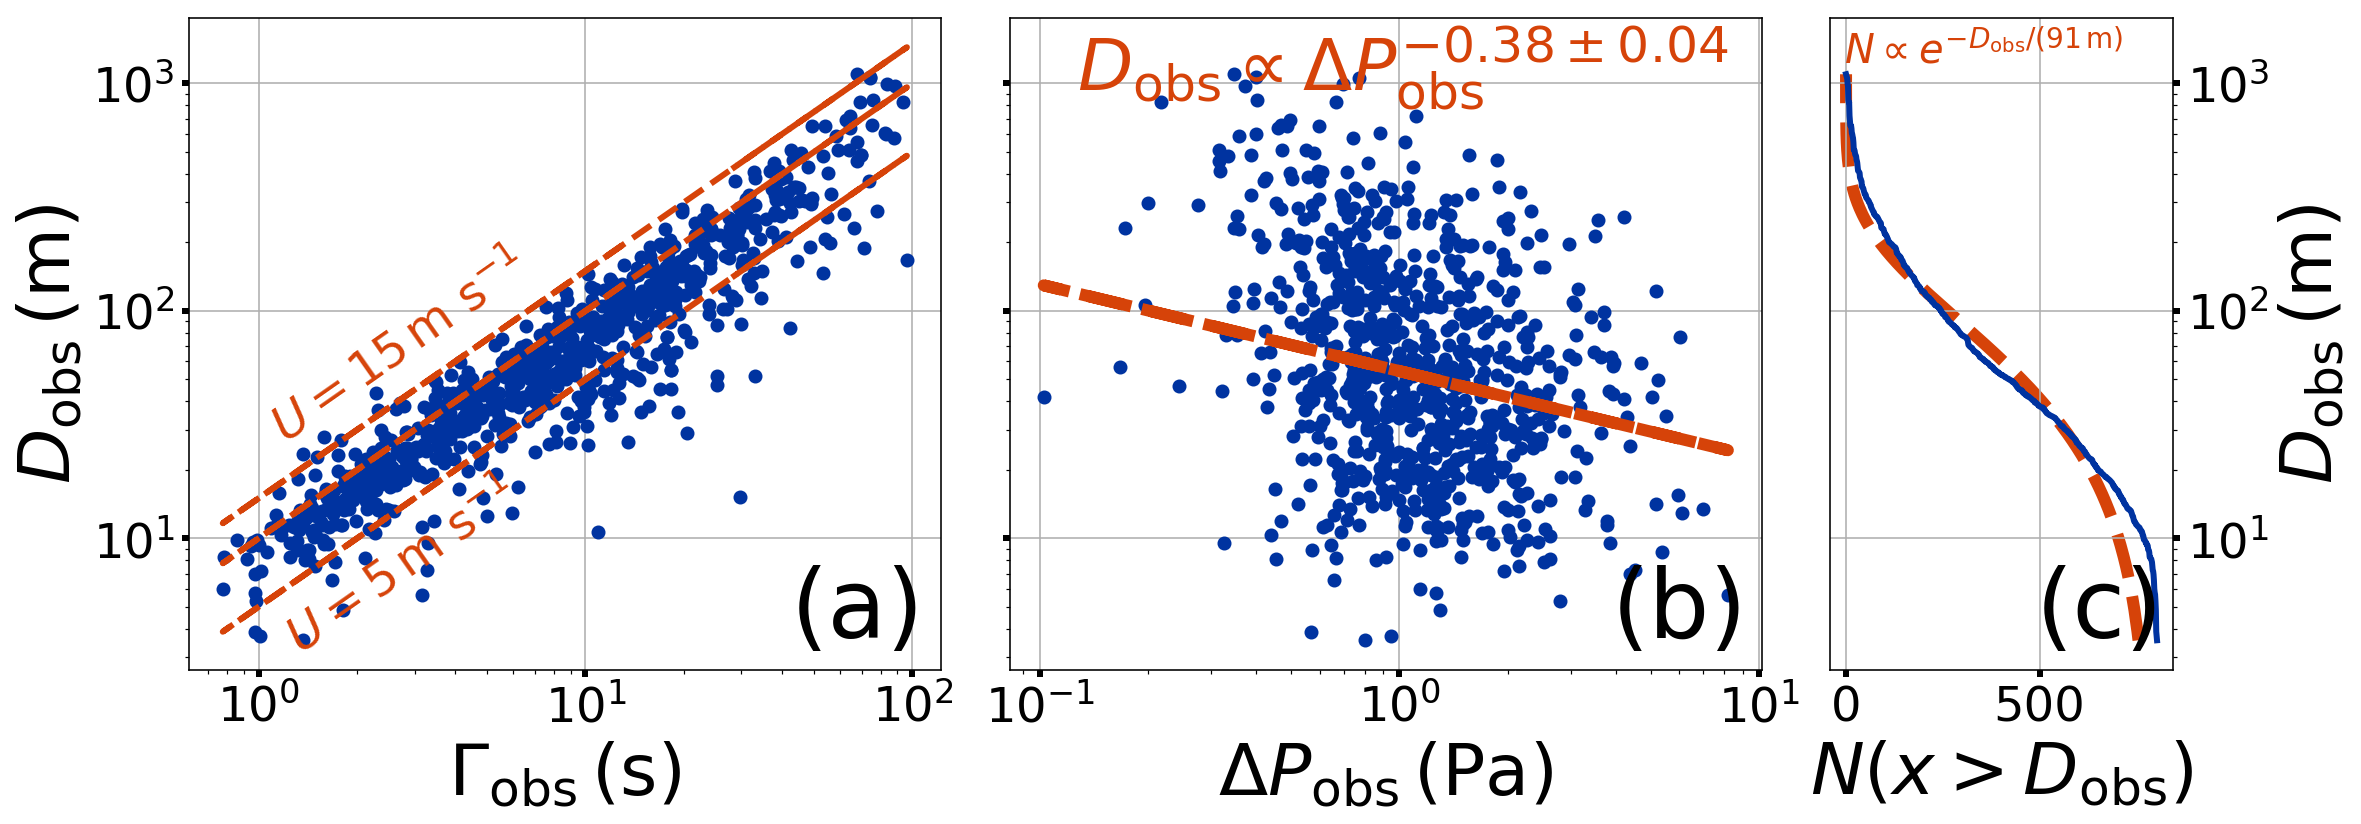

In [52]:
def exponential(x, amp, scale):
    return amp*np.exp(-x/scale)

fig = plt.figure(figsize=(10*aspect_ratio, 6))

ax1 = plt.subplot2grid((1,5), (0,0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid((1,5), (0,2), colspan=2, rowspan=1, sharey=ax1)
ax3 = plt.subplot2grid((1,5), (0,4), colspan=1, rowspan=1, sharey=ax1)

filename = "all_vortices_with_diameters.csv"   
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)    
# ('sol', 't0', 'DeltaP', 'DeltaP_unc', 'Gamma', 'Gamma_unc', 'U', 'U_unc', 'Diameter', 'Diameter_unc')

# Take only vortices with estimates uncertainties for the diameters
ind = data['Diameter_unc'] > 0

print("np.mean(data['Gamma']): ", np.mean(data['Gamma']))

mx_ind = np.argmax(data['Diameter'][ind])
print(data['Diameter_unc'][ind][mx_ind], data['Diameter'][ind][mx_ind])
md_ind = np.argmin(np.abs(data['Diameter'][ind] - np.median(data['Diameter'][ind])))
print(data['Diameter_unc'][ind][md_ind], data['Diameter'][ind][md_ind])
mn_ind = np.argmin(np.abs(data['Diameter'][ind]))
print(data['Diameter_unc'][ind][mn_ind], data['Diameter'][ind][mn_ind])

print(np.nanmax(data['Diameter'][ind]), np.nanmin(data['Diameter'][ind]), np.nanmedian(data['Diameter'][ind]))

### D_obs vs. Gamma_obs ###

ax1.loglog(data['Gamma'][ind], data['Diameter'][ind], ls='', marker='o', color=BoiseState_blue)

U0 = 5.
ax1.loglog(data['Gamma'][ind], U0*data['Gamma'][ind], color=BoiseState_orange, lw=3, ls='--')
ax1.text(0.12, 0.25, r'$U = %.0f\,{\rm m\ s^{-1}}$' % U0, 
        fontsize=24, transform=ax1.transAxes, color=BoiseState_orange, rotation=35)
U0 = 10.
ax1.loglog(data['Gamma'][ind], U0*data['Gamma'][ind], color=BoiseState_orange, lw=3, ls='--')
U0 = 15.
ax1.loglog(data['Gamma'][ind], U0*data['Gamma'][ind], color=BoiseState_orange, lw=3, ls='--')
ax1.text(0.1, 0.6, r'$U = %.0f\,{\rm m\ s^{-1}}$' % U0, 
        fontsize=24, transform=ax1.transAxes, color=BoiseState_orange, rotation=35)

ax1.text(0.8, 0.05, "(a)", fontsize=48, transform=ax1.transAxes)
ax1.grid(True)
ax1.tick_params(labelsize=24)
ax1.set_xlabel(r'$\Gamma_{\rm obs}\,\left( {\rm s} \right)$', fontsize=36)
ax1.set_ylabel(r'$D_{\rm obs}\,\left( {\rm m} \right)$', fontsize=36)

### D_obs vs. Delta P_obs ###
ax2.loglog(data['DeltaP'][ind], data['Diameter'][ind], ls='', marker='o', color=BoiseState_blue)

# polyfit
x = np.log10(data['DeltaP'][ind])
xerr = data['DeltaP_unc'][ind]/(data['DeltaP'][ind]*np.log(10.))
y = np.log10(data['Diameter'][ind])
yerr = data['Diameter_unc'][ind]/(data['Diameter'][ind]*np.log(10.))
popt, pcov = curve_fit(line, x, y, sigma=yerr)
uncertainties = np.sqrt(np.diag(pcov))
print("D vs Delta P:")
print(popt)
print(uncertainties)
ax2.loglog(10.**x, 10.**(np.polyval(popt, x)), lw=6, ls='--', color=BoiseState_orange)
ax2.text(0.09, 0.89, r'$D_{\rm obs} \propto \Delta P_{\rm obs}^{%.2f\pm%.2f}$' % (popt[0], uncertainties[0]), 
         fontsize=36, transform=ax2.transAxes, color=BoiseState_orange)

ax2.text(0.8, 0.05, "(b)", fontsize=48, transform=ax2.transAxes)
ax2.yaxis.set_label_position("right")
ax2.grid(True)
ax2.tick_params(axis='x', labelsize=24)
ax2.tick_params(labelleft=False)
ax2.set_xlabel(r'$\Delta P_{\rm obs}\,\left( {\rm Pa} \right)$', fontsize=36)
# ax2.set_ylabel(r'$D_{\rm obs}\,\left( {\rm m} \right)$', fontsize=36)

### D_obs cumulative histogram ###
# hst, bin_edges = np.histogram(np.log10(data['Diameter'][ind]), bins='auto')
# bins = 0.5*(bin_edges[1:] + bin_edges[0:-1])
# hst_err = np.sqrt(hst)
# ax3.plot(hst, 10**bins, lw=3, color=BoiseState_blue)

# hst, bin_edges = np.histogram(data['Diameter'][ind], bins='auto')
# bins = 0.5*(bin_edges[1:] + bin_edges[0:-1])
# hst_err = np.sqrt(hst)
# ax3.loglog(hst, bins, lw=3, color=BoiseState_blue)

x = data['Diameter'][ind]
srt = np.argsort(x)
Diameter = x[srt]
hst, _ = np.histogram(Diameter, bins=[0, *Diameter])
Diameter_cum_hst = len(Diameter) - np.cumsum(hst)
Diameter_cum_hst_err = np.sqrt(Diameter_cum_hst)
ax3.semilogy(Diameter_cum_hst, Diameter, lw=3, color=BoiseState_blue)

ind = Diameter_cum_hst > 0
# fit_params = np.polyfit(np.log10(Diameter[ind]), np.log10(Diameter_cum_hst[ind]), 1, 
#                         w=1./Diameter_cum_hst_err[ind])
# print(fit_params)
# ax3.loglog(10**np.polyval(fit_params, np.log10(Diameter)), Diameter, lw=3, ls='--', color=BoiseState_orange)

popt, pcov = curve_fit(exponential, Diameter[ind], Diameter_cum_hst[ind], sigma=Diameter_cum_hst_err[ind])
uncertainties = np.sqrt(np.diag(pcov))
print(popt)
print(uncertainties)
print(popt[0]/popt[1])
ax3.plot(exponential(Diameter, *popt), Diameter, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

ax3.grid(True)
ax3.tick_params(labelsize=24)
ax3.text(0.6, 0.05, "(c)", fontsize=48, transform=ax3.transAxes)
ax3.text(0.04, 0.93, r'$N \propto e^{-D_{\rm obs}/\left( %.0f\, {\rm m} \right)}$' %\
         popt[1], fontsize=20, color=BoiseState_orange, transform=ax3.transAxes)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.set_xlabel(r'$N\left(x > D_{\rm obs}\right)$', fontsize=36)
# ax3.set_xlabel(r'$N\left(D_{\rm obs}\right)$', fontsize=36)
ax3.set_ylabel(r'$D_{\rm obs}\,\left( {\rm m} \right)$', fontsize=36)

Dobs_quantile = np.quantile(Diameter, 0.5)
print(Dobs_quantile)
# popt, pcov = curve_fit(gauss, bins, hst)
# uncertainties = np.sqrt(np.diag(pcov))
# ax3.plot(gauss(bins, *popt), 10**bins, lw=3, ls='--', color=BoiseState_orange)
# ax3.text(0.1, 0.95, "exponential", transform=ax3.transAxes)
# ax3.text(0.1, 0.9, r'$A = %g, \log\ D_0 = %g$' % (popt[0], popt[1]), transform=ax3.transAxes)
# ax3.text(0.1, 0.85, r'$\sigma = %g$' % np.abs(popt[2]), transform=ax3.transAxes)
# print(popt)
# print(uncertainties)

# fit_params = np.polyfit(bins, hst, 2, w=1/hst_err)
# print(fit_params)
# ax3.plot(np.polyval(fit_params, bins), 10**bins, lw=3, ls='--', color=BoiseState_orange)

# fig.savefig("../figures/Dobs_vs_Gammaobs-DeltaPobs_hist.png", dpi=500, bbox_inches="tight")

19.059 3.46726
7.7815 1.20905
0.513 1.38014
7.7815
bins[np.argmax(med)]:  11.0
peak in U histogram at 7.867448275862069
[-4.08908108  5.72178055]


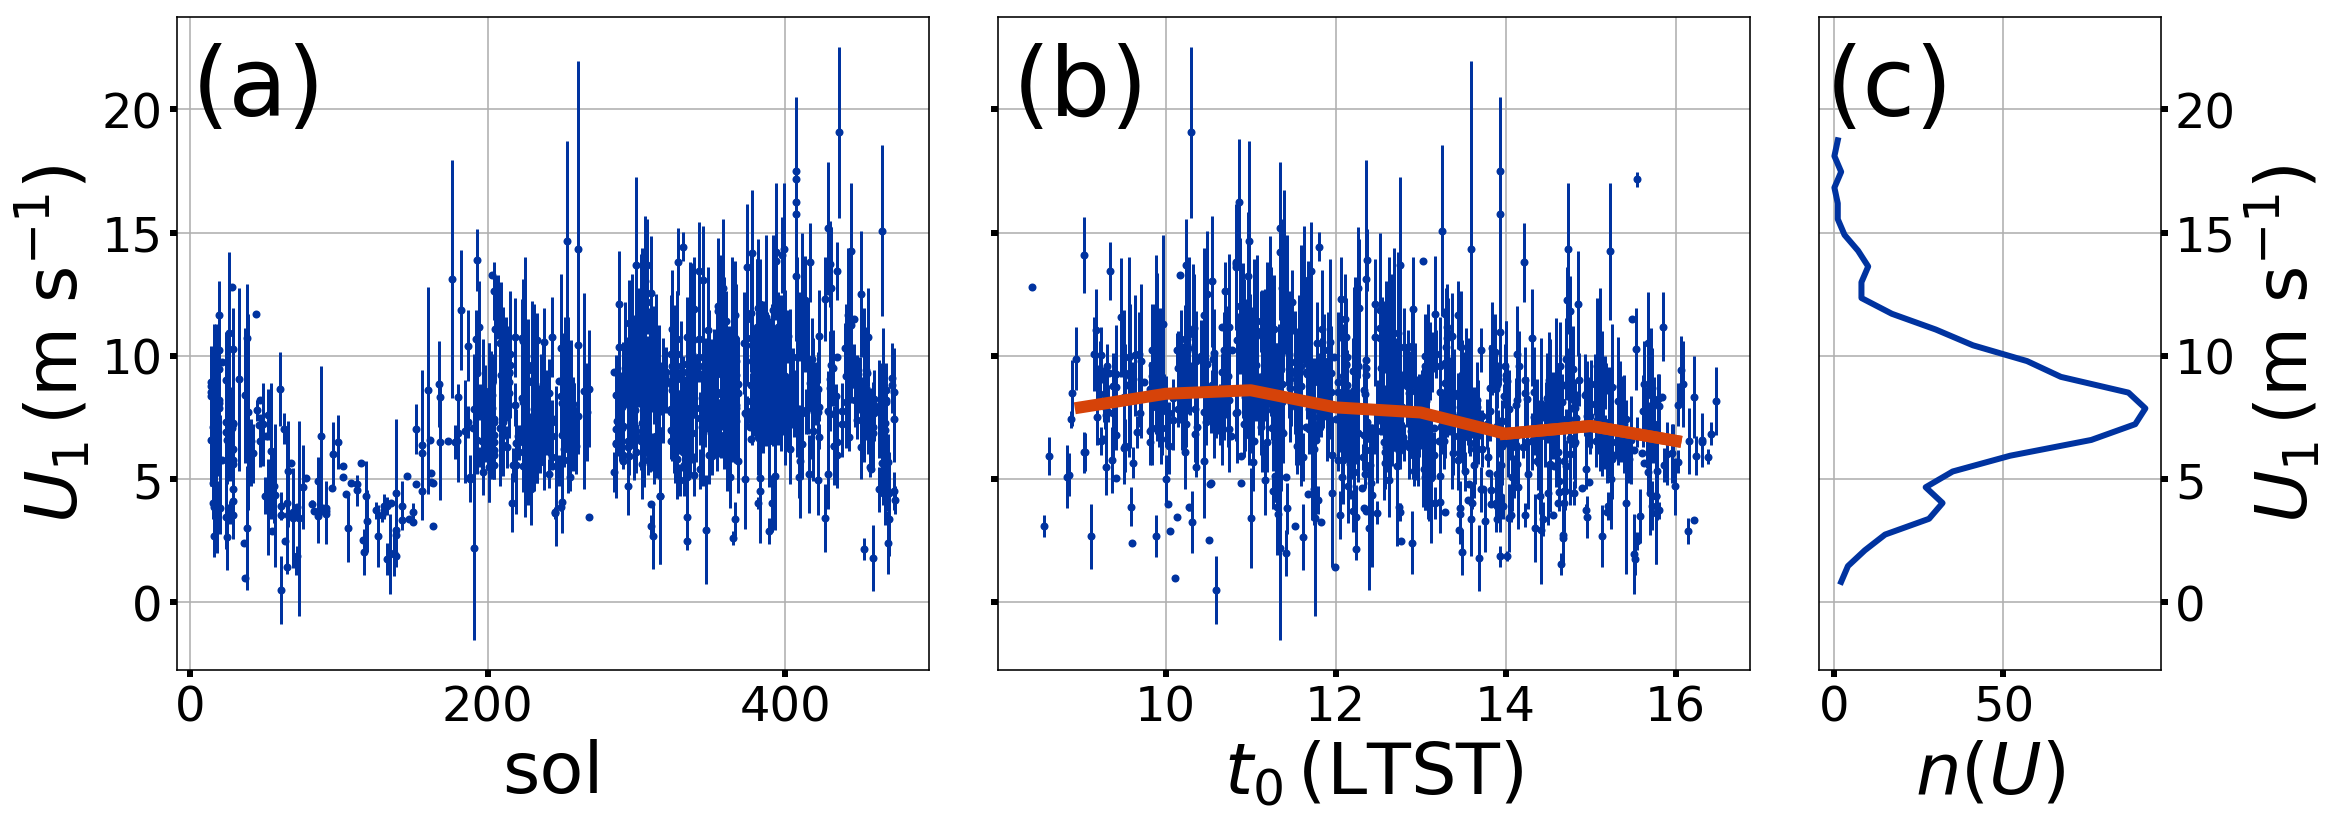

In [5]:
filename = "all_vortices_with_diameters.csv"
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)    
# ('sol', 't0', 'DeltaP', 'DeltaP_unc', 'Gamma', 'Gamma_unc', 'U', 'U_unc', 'Diameter', 'Diameter_unc')
ind = data['Diameter_unc'] > 0

fig = plt.figure(figsize=(10*aspect_ratio, 6))
ax1 = plt.subplot2grid((1,5), (0,0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid((1,5), (0,2), colspan=2, rowspan=1, sharey=ax1)
ax3 = plt.subplot2grid((1,5), (0,4), colspan=1, rowspan=1, sharey=ax1)

mx = np.argmax(data['U'][ind])
print(data['U'][ind][mx], data['U_unc'][ind][mx])

md = np.argmin(np.abs(data['U'][ind] - np.median(data['U'][ind])))
print(data['U'][ind][md], data['U_unc'][ind][md])

mn = np.argmin(data['U'][ind])
print(data['U'][ind][mn], data['U_unc'][ind][mn])

### Windspeed vs. SOL ###
ax1.errorbar(data['sol'][ind], data['U'][ind], yerr=data['U_unc'][ind], color=BoiseState_blue, ls='', marker='.')

bin_edges = np.arange(np.min(data['sol'][ind]) - 0.5, np.max(data['sol'][ind]) + 1.5, 1)
med = np.array([])
bins = np.array([])
for i in range(len(bin_edges) - 1):
    oind = (data['t0'][ind] >= bin_edges[i]) & (data['t0'][ind] < bin_edges[i+1])
    if(len(data['t0'][ind][oind]) > 1):
        bins = np.append(bins, 0.5*(bin_edges[i] + bin_edges[i+1]))
        med = np.append(med, np.nanmedian(data['U'][ind][oind]))

ax2.plot(bins, med, color=BoiseState_orange, lw=6, zorder=3)

ax1.set_xlabel('sol', fontsize=36)
ax1.set_ylabel(r'$U_1\, \left( {\rm m\ s^{-1}} \right)$', fontsize=36)
ax1.tick_params(axis='x', labelsize=24)
ax1.tick_params(labelsize=24)
ax1.grid(True)
ax2.text(0.02, 0.85, "(b)", fontsize=48, transform=ax2.transAxes)

### Windspeed vs. t0 ###
print(np.quantile(data['U'][ind], 0.5))
ax2.errorbar(data['t0'][ind], data['U'][ind], yerr=data['U_unc'][ind], color=BoiseState_blue, ls='', marker='.')

# Bin by hour
bin_edges = np.arange(-0.5, 25.5, 1)
med = np.array([])
bins = np.array([])
for i in range(len(bin_edges) - 1):
    oind = (data['t0'][ind] >= bin_edges[i]) & (data['t0'][ind] < bin_edges[i+1])
    if(len(data['t0'][ind][oind]) > 1):
        bins = np.append(bins, 0.5*(bin_edges[i] + bin_edges[i+1]))
        med = np.append(med, np.nanmedian(data['U'][ind][oind]))

ax2.plot(bins, med, color=BoiseState_orange, lw=6, zorder=3)
wind_bins = bins
wind_meds = med
print("bins[np.argmax(med)]: ", bins[np.argmax(med)])

ax2.set_xlabel(r'$t_0\, {\rm (LTST) }$', fontsize=36)
ax2.tick_params(labelleft=False, labelright=False)
ax2.tick_params(labelsize=24)
ax2.grid(True)
ax1.text(0.02, 0.85, "(a)", fontsize=48, transform=ax1.transAxes)

### Histogram ###
hst, bin_edges = np.histogram(data['U'][ind], bins='auto')
bins = 0.5*(bin_edges[1:] + bin_edges[0:-1])
ax3.plot(hst, bins, color=BoiseState_blue, lw=3)
ax3.set_xlabel(r'$n \left( U \right)$', fontsize=36)
ax3.set_ylabel(r'$U_1\, \left( {\rm m\ s^{-1}} \right)$', fontsize=36)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.tick_params(labelsize=24)
ax3.grid(True)
ax3.text(0.02, 0.85, "(c)", fontsize=48, transform=ax3.transAxes)

# 2020 Oct 28 - Fitting the wind speed on the low end
peak_ind = np.argmax(hst)
print("peak in U histogram at", bins[peak_ind])

wind_ind = (bins >= bins[peak_ind]) & (bins < 12.)
coeffs = np.polyfit(np.log10(bins[wind_ind]), np.log10(hst[wind_ind]), 1)
print(coeffs)

fig.savefig("../figures/U1_vs_t0-sol_hist.png", dpi=500, bbox_inches="tight")

1.174664997814008
[9.49334148]
(-0.7903519724524989, 0.019566021712103775)


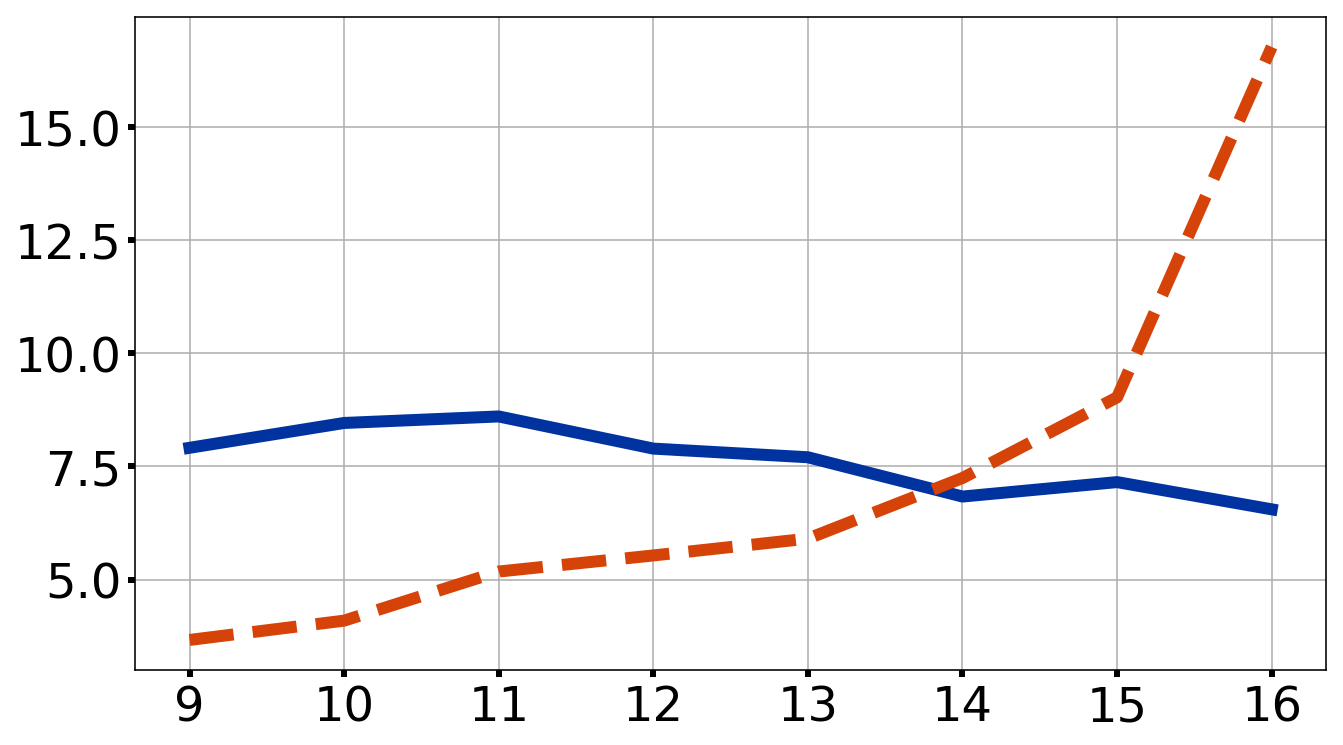

In [59]:
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

# plt.plot(wind_meds, Gamma_meds, marker='o', color=BoiseState_blue, ls='')
plt.plot(wind_bins, wind_meds, color=BoiseState_blue, lw=6)
plt.plot(Gamma_TOD, Gamma_meds, color=BoiseState_orange, ls='--', lw=6)

ax.tick_params(labelsize=24)
# ax.set_xlabel(r'$U\,\left( {\rm m\ s^{-1}} \right)$', fontsize=36)
# ax.set_ylabel(r'$\Gamma_{\rm obs}\,\left( {\rm s} \right)$', fontsize=36)
ax.grid(True)

print(np.min(wind_meds)/(np.max(wind_meds) - np.min(wind_meds)))
print((np.max(Gamma_meds) - Gamma_meds[Gamma_TOD == 11])/Gamma_meds[Gamma_TOD == 11])

res = pearsonr(wind_meds, Gamma_meds)
print(res)

[723789.20015699]


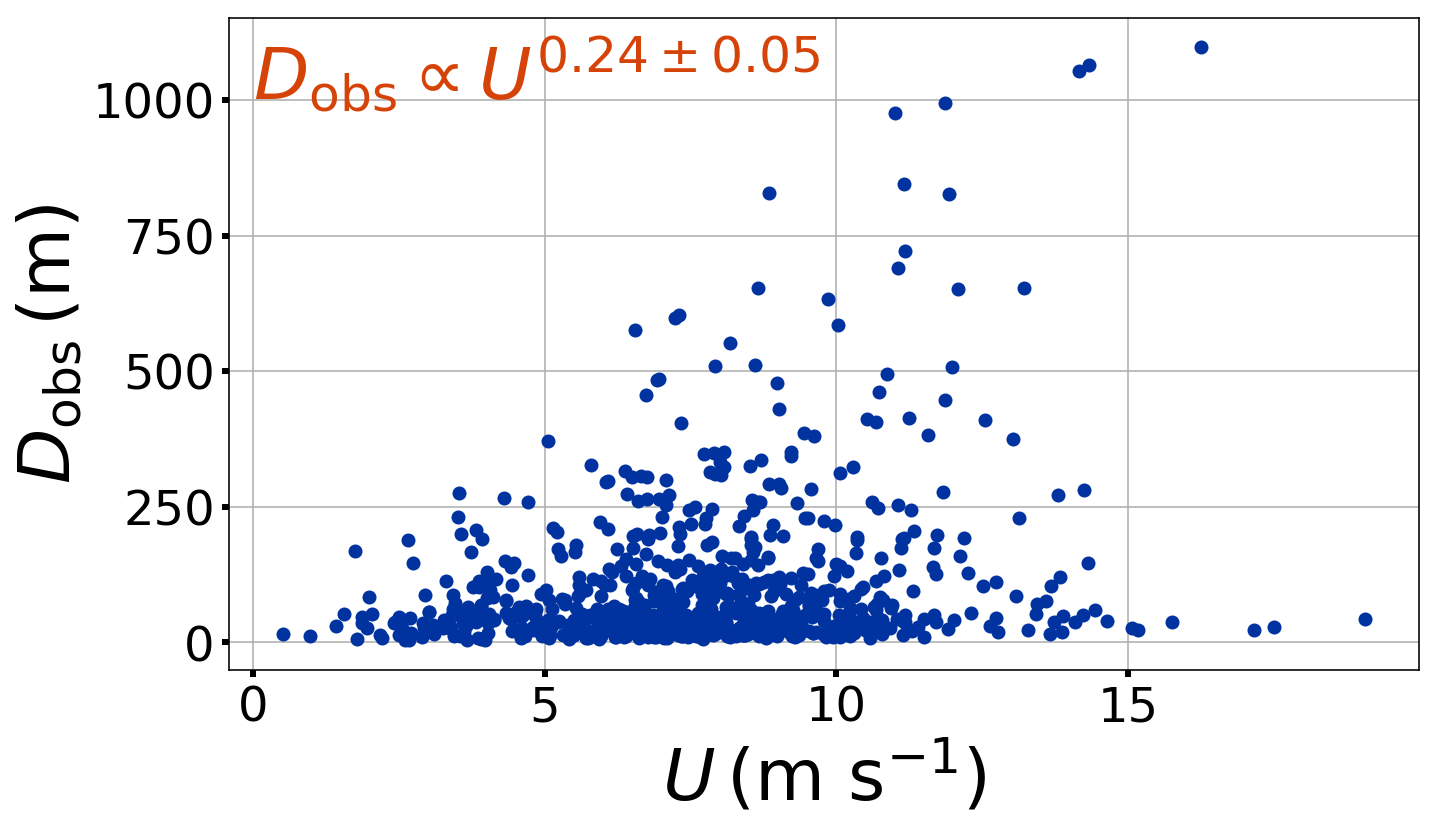

In [11]:
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

filename = "all_vortices_with_diameters.csv"
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)    

# ('sol', 't0', 'DeltaP', 'DeltaP_unc', 'Gamma', 'Gamma_unc', 'U', 'U_unc', 'Diameter', 'Diameter_unc')
ind = data['Diameter_unc'] > 0.

ax.plot(data['U'][ind], data['Diameter'][ind], marker='o', color=BoiseState_blue, ls='')

# popt, pcov = curve_fit(line, data['U'][ind], data['Diameter'][ind])#, sigma=data['Diameter_unc'][ind])
# uncertainties = np.sqrt(np.diag(pcov))
# print(popt)
# print(uncertainties)
# print(redchisqg(data['Diameter'][ind], line(data['U'][ind], *popt), deg=2))#, sd=data['Diameter_unc'][ind]))
# srt = np.argsort(data['U'][ind])
# ax.plot(data['U'][ind][srt], np.polyval(popt, data['U'][ind][srt]), 
#             color=BoiseState_orange, ls='--', lw=6)

# popt, pcov = curve_fit(line, np.log10(data['U'][ind]), np.log10(data['Diameter'][ind]), 
#                        sigma=data['Diameter_unc'][ind]/(np.log(10)*data['Diameter'][ind]))
# uncertainties = np.sqrt(np.diag(pcov))
# print(popt)
# print(uncertainties)
# print(redchisqg(np.log10(data['Diameter'][ind]), line(np.log10(data['U'][ind]), *popt), deg=2, 
#                 sd=data['Diameter_unc'][ind]/(np.log(10)*data['Diameter'][ind])))
# srt = np.argsort(data['U'][ind])
# ax.plot(data['U'][ind][srt], 10.**np.polyval(popt, np.log10(data['U'][ind][srt])), 
#             color=BoiseState_orange, ls='--', lw=6)

ax.set_ylabel(r'$D_{\rm obs}\,\left( {\rm m} \right)$', fontsize=36)
ax.set_xlabel(r'$U\,\left( {\rm m\ s^{-1}} \right)$', fontsize=36)
ax.tick_params(labelsize=24)
ax.grid(True)

ax.text(0.02, 0.875, r'$D_{\rm obs} \propto U^{%.2f\pm%.2f}$' % (popt[0], uncertainties[0]), 
        transform=ax.transAxes, fontsize=36, color=BoiseState_orange)

[-0.23288183  5.25665595]
[0.0587431  0.47450258]
297.1547185034371

[-0.22453247  1.31845734]
[0.07188577 0.05895881]
478.81366705732347

657.0449509148598
(-0.07444914555082043, 0.03491646549303933)


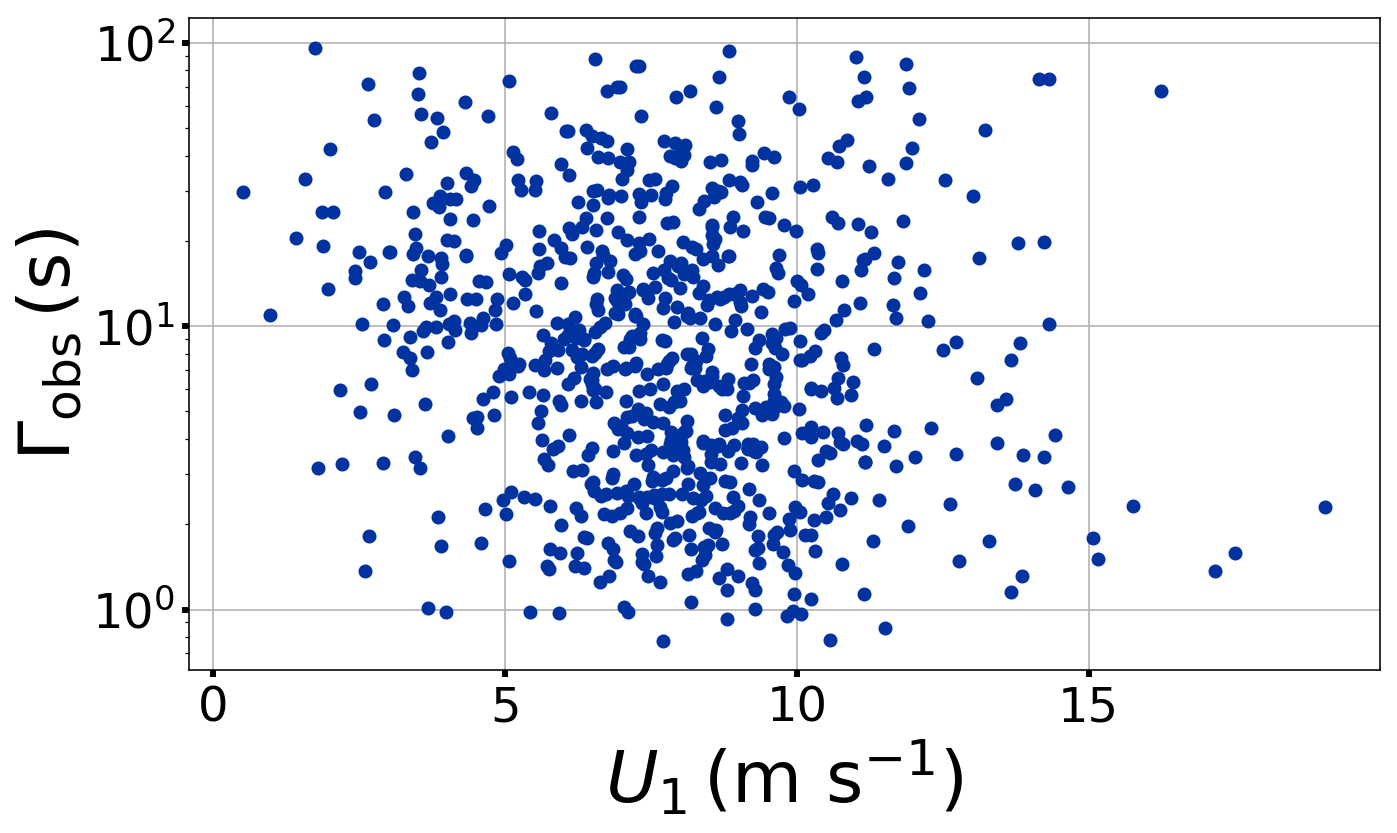

In [26]:
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

filename = "all_vortices_with_diameters.csv"
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)    

# ('sol', 't0', 'DeltaP', 'DeltaP_unc', 'Gamma', 'Gamma_unc', 'U', 'U_unc', 'Diameter', 'Diameter_unc')
ind = data['Diameter_unc'] > 0

ax.semilogy(data['U'][ind], data['Gamma'][ind], marker='o', color=BoiseState_blue, ls='')

popt, pcov = curve_fit(line, data['U'][ind], data['Gamma'][ind], sigma=data['Gamma_unc'][ind])
uncertainties = np.sqrt(np.diag(pcov))
print(popt)
print(uncertainties)
print(redchisqg(data['Gamma'][ind], np.polyval(popt, data['U'][ind]), deg=2, sd=data['Gamma_unc'][ind]))
# srt = np.argsort(data['U'][ind])
# ax.semilogy(data['U'][ind][srt], np.polyval(popt, data['U'][ind][srt]), 
#             color=BoiseState_orange, ls='--', lw=6)

print()

popt, pcov = curve_fit(line, np.log10(data['U'][ind]), np.log10(data['Gamma'][ind]), 
                       sigma=data['Gamma_unc'][ind]/(np.log(10)*data['Gamma'][ind]))
uncertainties = np.sqrt(np.diag(pcov))
print(popt)
print(uncertainties)
print(redchisqg(np.log10(data['Gamma'][ind]), np.polyval(popt, np.log10(data['U'][ind])), 
                sd=data['Gamma_unc'][ind]/(np.log(10)*data['Gamma'][ind])))

print()

print(redchisqg(np.log10(data['Gamma'][ind]), 
                np.ones_like(data['Gamma'][ind])*np.median(np.log10(data['Gamma'][ind])), 
                sd=data['Gamma_unc'][ind]/(np.log(10)*data['Gamma'][ind])))

# srt = np.argsort(data['U'][ind])
# ax.semilogy(data['U'][ind][srt], 10.**np.polyval(popt, np.log10(data['U'][ind][srt])), 
#             color=BoiseState_orange, ls='--', lw=6)

print(pearsonr(data['Gamma'][ind], data['U'][ind]))

ax.set_ylabel(r'$\Gamma_{\rm obs}\,\left( {\rm s} \right)$', fontsize=36)
ax.set_xlabel(r'$U_1\,\left( {\rm m\ s^{-1}} \right)$', fontsize=36)
ax.tick_params(labelsize=24)
ax.grid(True)

# ax.text(0.02, 0.875, r'$\Gamma_{\rm obs} \propto U_1^{%.2f\pm%.2f}$' % (popt[0], uncertainties[0]), 
#         transform=ax.transAxes, fontsize=36, color=BoiseState_orange)

fig.savefig("../figures/Gammaobs_vs_U1.png", dpi=500, bbox_inches="tight")

Check notes from 2020 Aug 21  <br>
$V_{\rm obs} = V(t_0) - V(\infty)$ <br>
$P_{\rm obs} = P(t_0) - P(\infty)$<br>
$P_{\rm act} = \left( 1 - \frac{\rho V_{\rm obs}^2}{P_{\rm obs}} \right)^{-1}\ P_{\rm obs}$<br>
$V_{\rm act} = \left( \frac{P_{\rm act}}{\rho} \right)^{1/2}$<br>
$\left( b/r_{\rm act} \right) = \sqrt{\frac{P_{\rm act}}{P_{\rm obs}} - 1}$<br>
$r_{\rm act} = r_{\rm obs} \bigg( 1 + \left( \frac{b}{r_{\rm act}} \right)^2 \bigg)^{-1/2}$

Notes from 2020 Aug 23<br>
Model for wind velocity - $V(t) = \sqrt{V_r^2 + 2 U V_r \cos \theta + U^2}$ with
$V_r(t) = V_{\rm act} \frac{2 \left( r/r_{\rm act} \right)}{1 + \left( r/r_{\rm act} \right)^2 }.
$

With that timescale, we can write $V_r$ as 
$$
V_r(t) = V_{\rm obs} \frac{\sqrt{ 1 + \left( 2 \left( t - t_0 \right)/\Gamma_{\rm wind} \right)^2 } }{1 + \left( 2\left( t - t_0 \right)/\Gamma_{\rm obs} \right)^2}.
$$

$\cos \theta = \pm \left( 1 + \left( 2 \left( t - t_0 \right) / \Gamma_{\rm wind} \right)^2 \right)^{-1/2}$ with the sign determined by whether the wind speed goes up or down during the encounter!

Therefore, 
$$
V_r \cos \theta = \frac{V_{\rm obs}}{1 + \left( 2 \left( t - t_0 \right)/\Gamma_{\rm obs} \right)^2 }.
$$

simple_profile BIC:  24.989660118097696
U1, U2:  1.787 11.122499999999999
DeltaP[which_vortex], Vobs:  8.18645 26.554000000000002
wind_sigma:  1.8504999999999994
np.abs(Vobs)/wind_sigma:  14.349635233720623
Pact, Vact:  10.90546431839907 30.689552955527425
bact, Diameter, Dact:  1.4137550113290283 5.66266 4.906210895117354

0.8557460185439787
full_profile BIC:  17.561055021674008
U1, U2:  1.787 11.122499999999999
DeltaP[which_vortex], Vobs:  8.18645 -28.200697375304426
wind_sigma:  1.8504999999999994
np.abs(Vobs)/wind_sigma:  15.239501418700046
Pact, Vact:  11.38917237546852 31.36278094592297
bact, Diameters, Dact:  1.5014264230364542 5.66266 4.800895027016507


Text(0.05, 0.05, 'sol 459, vortex_number 2')

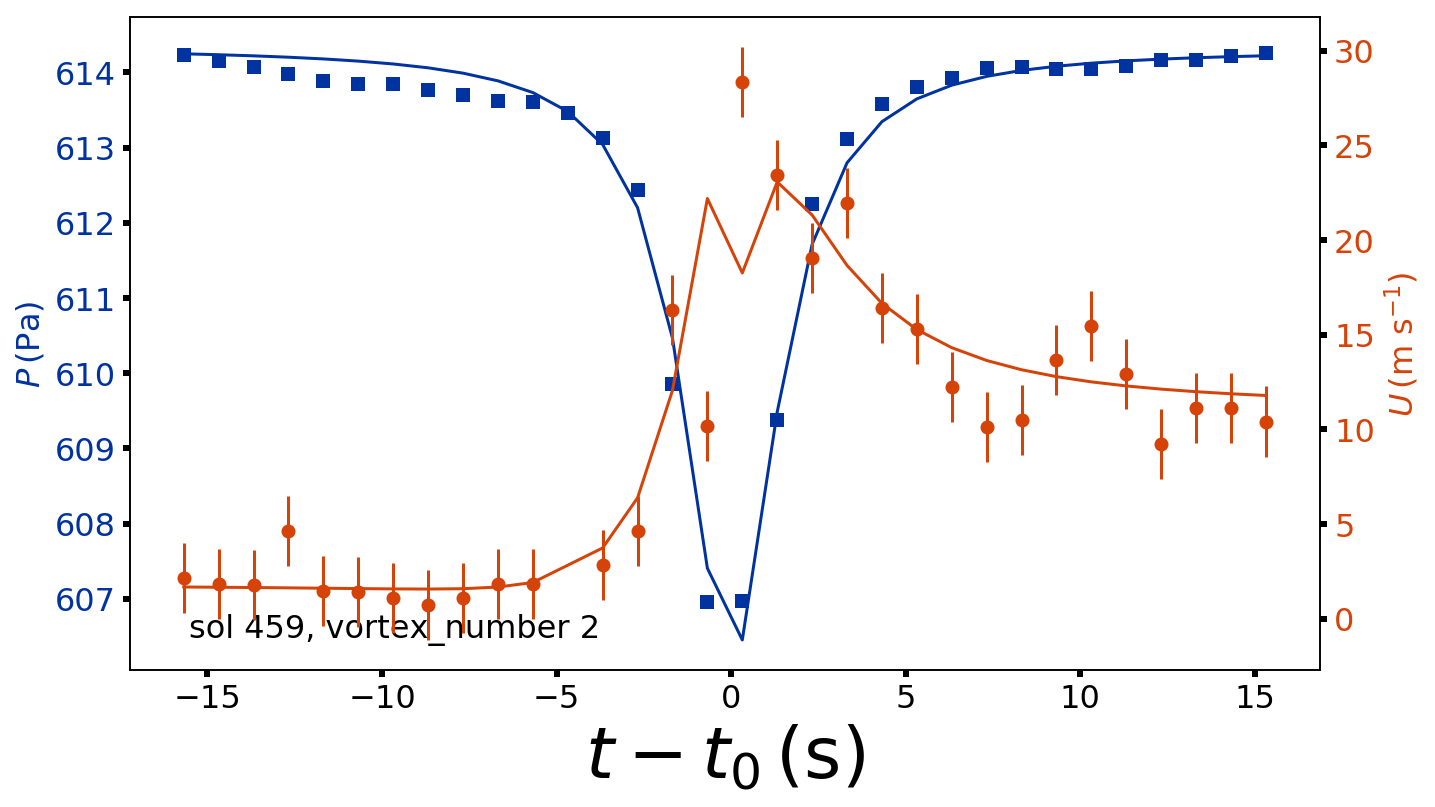

In [2]:
# Read in pressure fits
filename = "all_vortices_with_diameters.csv"
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)

# Read in the other data file
ind = data['Diameter_unc'] > 0
vortex_number = data['vortex_number'][ind]
sols = data['sol'][ind]
t0 = data['t0'][ind]
DeltaP = data['DeltaP'][ind]
Gamma = data['Gamma'][ind]
Diameters = data['Diameter'][ind]
intercept = data['intercept'][ind]
slope = data['slope'][ind]

# Fit the vortices in order from deepest to least deep until we can't fit 'em no more
srt = np.argsort(DeltaP)[::-1]

# which_vortex = 6
# which_vortex = srt[500]
which_vortex = srt[0]

fig = plt.figure(figsize=(6*aspect_ratio, 6))

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.set_xlabel(r'$t - t_0\, \left({\rm s} \right)$', fontsize=36)

wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma, density =\
    retrieve_wind_and_pressure(sols[which_vortex], dr, dr_wind, t0[which_vortex], Gamma[which_vortex])

sampling = np.median(wind_x[1:] - wind_x[0:-1])

simple_profile = simple_wind_profile(wind_x, wind_y, 0., Gamma[which_vortex]/3600., sampling)
U1, U2, Vobs = simple_wind_profile_parameters(wind_x, wind_y, 0., Gamma[which_vortex]/3600., sampling)
Pact, Vact, Dact, bact = calculate_act_values(density, Vobs, DeltaP[which_vortex], Diameters[which_vortex])

simple_BIC = BIC(wind_y, simple_profile, deg=3, sd=wind_sigma)
print("simple_profile BIC: ", simple_BIC)
print("U1, U2: ", U1, U2) 
print("DeltaP[which_vortex], Vobs: ", DeltaP[which_vortex], Vobs)
print("wind_sigma: ", wind_sigma)
simple_Vobs_sigma = np.abs(Vobs)/wind_sigma
print("np.abs(Vobs)/wind_sigma: ", simple_Vobs_sigma)
print("Pact, Vact: ", Pact, Vact)
print("bact, Diameter, Dact: ", bact, Diameters[which_vortex], Dact)
print()

make_plot(ax1, ax2, wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma,
          t0[which_vortex], intercept[which_vortex], slope[which_vortex], DeltaP[which_vortex], Gamma[which_vortex])

popt, uncertainties, U1, U2 = fit_wind_profile(wind_x*3600., wind_y, wind_sigma, 0., Gamma[which_vortex],
                                               [-30., -1.])
full_profile = wind_profile(wind_x*3600., 0., popt[0], U1, U2, popt[1], Gamma[which_vortex])
print(np.median(np.abs(full_profile - wind_y)))

Pact, Vact, Dact, bact = calculate_act_values(density, popt[0], DeltaP[which_vortex], Diameters[which_vortex])

full_BIC = BIC(wind_y, full_profile, deg=4, sd=wind_sigma)
print("full_profile BIC: ", full_BIC)
print("U1, U2: ", U1, U2) 
print("DeltaP[which_vortex], Vobs: ", DeltaP[which_vortex], popt[0])
print("wind_sigma: ", wind_sigma)
full_Vobs_sigma = np.abs(popt[0])/wind_sigma
print("np.abs(Vobs)/wind_sigma: ", full_Vobs_sigma)
print("Pact, Vact: ", Pact, Vact)
print("bact, Diameters, Dact: ", bact, Diameters[which_vortex], Dact)

ax2.plot(wind_x*3600., full_profile, color=BoiseState_orange)

ax1.text(0.05, 0.05, "sol %i, vortex_number %i" % (sols[which_vortex], vortex_number[which_vortex]), 
         transform=ax1.transAxes, fontsize=16)

In [18]:
# Read in pressure fits
filename = "all_vortices_with_diameters.csv"
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)

# Read in the other data file
ind = data['Diameter_unc'] > 0
vortex_number = data['vortex_number'][ind]
sols = data['sol'][ind]
t0 = data['t0'][ind]
DeltaP = data['DeltaP'][ind]
Gamma = data['Gamma'][ind]
Diameters = data['Diameter'][ind]
intercept = data['intercept'][ind]
slope = data['slope'][ind]

# Fit the vortices in order from deepest to least deep until we can't fit 'em no more
srt = np.argsort(DeltaP)[::-1]

which_vortex = srt[0]

# fig = plt.figure(figsize=(6*aspect_ratio, 6))

# ax1 = fig.add_subplot(111)
# ax2 = ax1.twinx()

# ax1.set_xlabel(r'$t - t_0\, \left({\rm s} \right)$', fontsize=36)

# wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma, density =\
#     retrieve_wind_and_pressure(sols[which_vortex], dr, dr_wind, t0[which_vortex], Gamma[which_vortex])

# sampling = np.median(wind_x[1:] - wind_x[0:-1])

# simple_profile = simple_wind_profile(wind_x, wind_y, 0., Gamma[which_vortex]/3600., sampling)
# U1, U2, Vobs = simple_wind_profile_parameters(wind_x, wind_y, 0., Gamma[which_vortex]/3600., sampling)
# Pact, Vact, Dact, bact = calculate_act_values(density, Vobs, DeltaP[which_vortex], Diameters[which_vortex])

# simple_BIC = BIC(wind_y, simple_profile, deg=3, sd=wind_sigma)
# print("simple_profile BIC: ", simple_BIC)
# print("U1, U2: ", U1, U2) 
# print("DeltaP[which_vortex], Vobs: ", DeltaP[which_vortex], Vobs)
# print("wind_sigma: ", wind_sigma)
# simple_Vobs_sigma = np.abs(Vobs)/wind_sigma
# print("np.abs(Vobs)/wind_sigma: ", simple_Vobs_sigma)
# print("Pact, Vact: ", Pact, Vact)
# print("bact, Diameter, Dact: ", bact, Diameters[which_vortex], Dact)
# print()

# make_plot(ax1, ax2, wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma,
#           t0[which_vortex], intercept[which_vortex], slope[which_vortex], DeltaP[which_vortex], Gamma[which_vortex], 
#          U1, Vobs, U2)

# popt, uncertainties, U1, U2 = fit_wind_profile(wind_x*3600., wind_y, wind_sigma, 0., Gamma[which_vortex],
#                                                [-30., -1.])
# full_profile = wind_profile(wind_x*3600., 0., popt[0], U1, U2, popt[1], Gamma[which_vortex])

# Pact, Vact, Dact, bact = calculate_act_values(density, popt[0], DeltaP[which_vortex], Diameters[which_vortex])

# full_BIC = BIC(wind_y, full_profile, deg=4, sd=wind_sigma)
# print("full_profile BIC: ", full_BIC)
# print("U1, U2: ", U1, U2) 
# print("DeltaP[which_vortex], Vobs: ", DeltaP[which_vortex], popt[0])
# print("wind_sigma: ", wind_sigma)
# full_Vobs_sigma = np.abs(popt[0])/wind_sigma
# print("np.abs(Vobs)/wind_sigma: ", full_Vobs_sigma)
# print("Pact, Vact: ", Pact, Vact)
# print("bact, Diameters, Dact: ", bact, Diameters[which_vortex], Dact)

# ax2.plot(wind_x*3600., full_profile, color=BoiseState_orange)

# ax1.text(0.05, 0.05, "sol %i, vortex_number %i" % (sols[which_vortex], vortex_number[which_vortex]), 
#          transform=ax1.transAxes, fontsize=16)

filename = "wind_data.txt"
zipped = list(zip(wind_x*86400., wind_y))
np.savetxt(filename, zipped, fmt='%g, %g')

filename = "pressure_data.txt"
zipped = list(zip(pressure_x*86400., pressure_y))
np.savetxt(filename, zipped, fmt='%g, %g')


full_profile chi-squared:  1.076923076923077
U1, U2:  1.787 11.122499999999999
DeltaP[which_vortex], Vobs:  8.18645 -28.200697375304426
wind_sigma:  3.487534372645811
np.abs(Vobs)/wind_sigma:  8.086141772965531
Pact, Vact:  11.38917237546852 31.36278094592297
bact, Diameters, Dact:  1.5014264230364542 5.66266 4.800895027016508

full_profile chi-squared:  1.125
U1, U2:  6.2940000000000005 9.5535
DeltaP[which_vortex], Vobs:  6.97169 -7.744221204057067
wind_sigma:  3.0042250867471196
np.abs(Vobs)/wind_sigma:  2.5777766247342893
Pact, Vact:  11.38917237546852 31.36278094592297
bact, Diameters, Dact:  1.5014264230364542 13.4925 4.800895027016508

full_profile chi-squared:  1.0465116279069768
U1, U2:  2.169 10.9155
DeltaP[which_vortex], Vobs:  6.0968 -22.939943387085886
wind_sigma:  3.0732018727738413
np.abs(Vobs)/wind_sigma:  7.464509113545646
Pact, Vact:  8.152284620173965 26.41396449703314
bact, Diameters, Dact:  3.249594082799635 12.9432 11.193166639880529


Text(0.9, 0.05, '(c)')

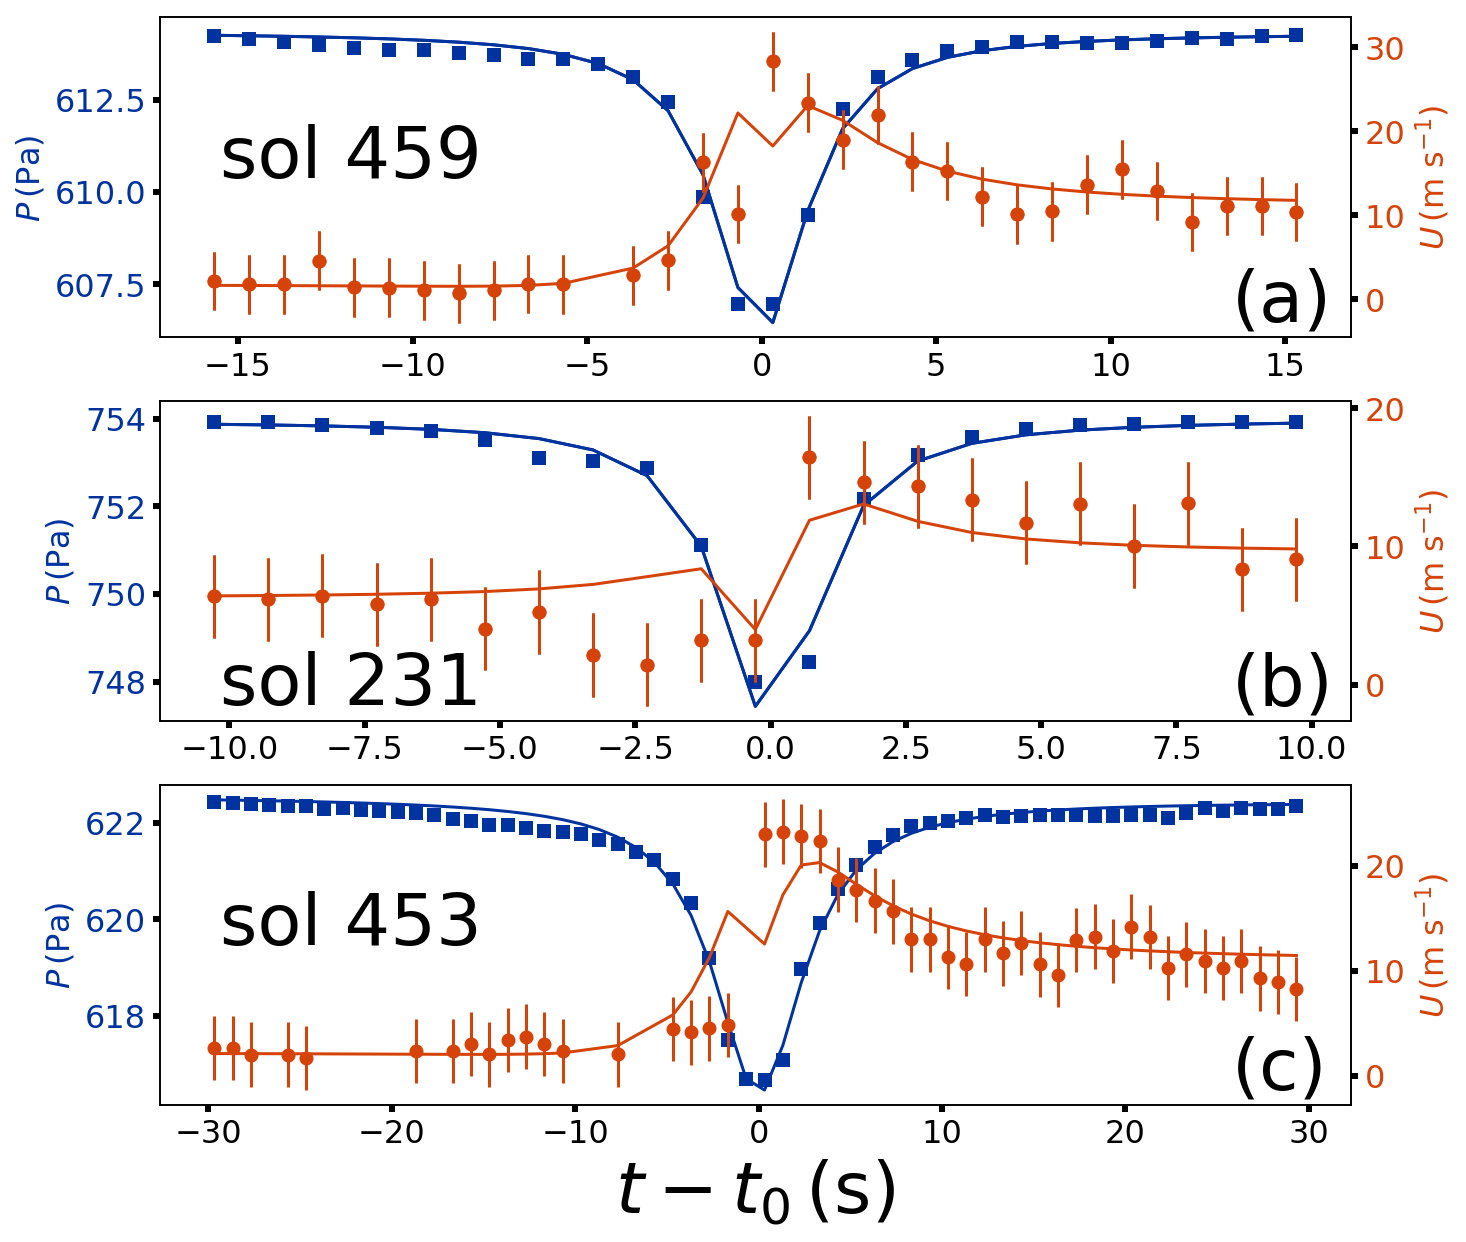

In [2]:
fig = plt.figure(figsize=(6*aspect_ratio, 10))

# Read in pressure fits
filename = "all_vortices_with_diameters.csv"
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)

# Read in the other data file
ind = data['Diameter_unc'] > 0
sols = data['sol'][ind]
t0 = data['t0'][ind]
DeltaP = data['DeltaP'][ind]
Gamma = data['Gamma'][ind]
Diameters = data['Diameter'][ind]
intercept = data['intercept'][ind]
slope = data['slope'][ind]

# Fit the vortices in order from deepest to least deep until we can't fit 'em no more
srt = np.argsort(DeltaP)[::-1]
# 77 looks like crap
# 76 looks fine

### Deepest vortex ###

which_vortex = srt[0]

ax1 = fig.add_subplot(311)
ax2 = ax1.twinx()

wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma, density =\
    retrieve_wind_and_pressure(sols[which_vortex], dr, dr_wind, t0[which_vortex], Gamma[which_vortex])

sampling = np.median(wind_x[1:] - wind_x[0:-1])

# 2021 Feb 3 - Blow up uncertainties
popt, uncertainties, U1, U2 = fit_wind_profile(wind_x*3600., wind_y, wind_sigma, 0., Gamma[which_vortex],
                                               [-30., -1.])
wind_sigma = inflate_errors(popt, uncertainties, U1, U2, Gamma[which_vortex], wind_x*3600., wind_y, wind_sigma)

make_plot(ax1, ax2, wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma,
          t0[which_vortex], intercept[which_vortex], slope[which_vortex], DeltaP[which_vortex], Gamma[which_vortex])
print()

full_profile = wind_profile(wind_x*3600., 0., popt[0], U1, U2, popt[1], Gamma[which_vortex])
full_BIC_chisq = redchisqg(wind_y, full_profile, deg=4, sd=wind_sigma)
print("full_profile chi-squared: ", full_BIC_chisq)

make_plot(ax1, ax2, wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma,
          t0[which_vortex], intercept[which_vortex], slope[which_vortex], DeltaP[which_vortex], Gamma[which_vortex])

Pact, Vact, Dact, bact = calculate_act_values(density, popt[0], DeltaP[which_vortex], Diameters[which_vortex])

print("U1, U2: ", U1, U2) 
print("DeltaP[which_vortex], Vobs: ", DeltaP[which_vortex], popt[0])
print("wind_sigma: ", wind_sigma)
full_Vobs_sigma = np.abs(popt[0])/wind_sigma
print("np.abs(Vobs)/wind_sigma: ", full_Vobs_sigma)
print("Pact, Vact: ", Pact, Vact)
print("bact, Diameters, Dact: ", bact, Diameters[which_vortex], Dact)

ax2.plot(wind_x*3600., full_profile, color=BoiseState_orange)

ax1.text(0.9, 0.05, "(a)", fontsize=36, transform=ax1.transAxes)
ax1.text(0.05, 0.5, "sol %i" % sols[which_vortex], fontsize=36, transform=ax1.transAxes)

print()

# ### 2nd Deepest vortex ###

which_vortex = srt[1]

ax3 = fig.add_subplot(312)
ax4 = ax3.twinx()

wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma, density =\
    retrieve_wind_and_pressure(sols[which_vortex], dr, dr_wind, t0[which_vortex], Gamma[which_vortex])

sampling = np.median(wind_x[1:] - wind_x[0:-1])
popt, uncertainties, U1, U2 = fit_wind_profile(wind_x*3600., wind_y, wind_sigma, 0., Gamma[which_vortex],
                                               [-30., -1.])
wind_sigma = inflate_errors(popt, uncertainties, U1, U2, Gamma[which_vortex], wind_x*3600., wind_y, wind_sigma)

make_plot(ax3, ax4, wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma,
          t0[which_vortex], intercept[which_vortex], slope[which_vortex], DeltaP[which_vortex], Gamma[which_vortex])

full_profile = wind_profile(wind_x*3600., 0., popt[0], U1, U2, popt[1], Gamma[which_vortex])
full_BIC_chisq = redchisqg(wind_y, full_profile, deg=4, sd=wind_sigma)
print("full_profile chi-squared: ", full_BIC_chisq)

make_plot(ax3, ax4, wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma,
          t0[which_vortex], intercept[which_vortex], slope[which_vortex], DeltaP[which_vortex], Gamma[which_vortex])

print("U1, U2: ", U1, U2) 
print("DeltaP[which_vortex], Vobs: ", DeltaP[which_vortex], popt[0])
print("wind_sigma: ", wind_sigma)
full_Vobs_sigma = np.abs(popt[0])/wind_sigma
print("np.abs(Vobs)/wind_sigma: ", full_Vobs_sigma)
print("Pact, Vact: ", Pact, Vact)
print("bact, Diameters, Dact: ", bact, Diameters[which_vortex], Dact)

ax4.plot(wind_x*3600., full_profile, color=BoiseState_orange)

ax3.text(0.9, 0.05, "(b)", fontsize=36, transform=ax3.transAxes)
ax3.text(0.05, 0.05, "sol %i" % sols[which_vortex], fontsize=36, transform=ax3.transAxes)

print()

# ### 3rd Deepest vortex ###

which_vortex = srt[2]

ax5 = fig.add_subplot(313)
ax6 = ax5.twinx()

wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma, density =\
    retrieve_wind_and_pressure(sols[which_vortex], dr, dr_wind, t0[which_vortex], Gamma[which_vortex])

sampling = np.median(wind_x[1:] - wind_x[0:-1])

popt, uncertainties, U1, U2 = fit_wind_profile(wind_x*3600., wind_y, wind_sigma, 0., Gamma[which_vortex],
                                               [-30., -1.])
wind_sigma = inflate_errors(popt, uncertainties, U1, U2, Gamma[which_vortex], wind_x*3600., wind_y, wind_sigma)

full_profile = wind_profile(wind_x*3600., 0., popt[0], U1, U2, popt[1], Gamma[which_vortex])
full_BIC_chisq = redchisqg(wind_y, full_profile, deg=4, sd=wind_sigma)
print("full_profile chi-squared: ", full_BIC_chisq)

make_plot(ax5, ax6, wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma,
          t0[which_vortex], intercept[which_vortex], slope[which_vortex], DeltaP[which_vortex], Gamma[which_vortex])

Pact, Vact, Dact, bact = calculate_act_values(density, popt[0], DeltaP[which_vortex], Diameters[which_vortex])

print("U1, U2: ", U1, U2) 
print("DeltaP[which_vortex], Vobs: ", DeltaP[which_vortex], popt[0])
print("wind_sigma: ", wind_sigma)
full_Vobs_sigma = np.abs(popt[0])/wind_sigma
print("np.abs(Vobs)/wind_sigma: ", full_Vobs_sigma)
print("Pact, Vact: ", Pact, Vact)
print("bact, Diameters, Dact: ", bact, Diameters[which_vortex], Dact)

ax6.plot(wind_x*3600., full_profile, color=BoiseState_orange)

ax5.set_xlabel(r'$t - t_0\, \left({\rm s} \right)$', fontsize=36)
ax5.text(0.05, 0.5, "sol %i" % sols[which_vortex], fontsize=36, transform=ax5.transAxes)
ax5.text(0.9, 0.05, "(c)", fontsize=36, transform=ax5.transAxes)

# fig.savefig("../figures/vortices_and_windspeed.png", dpi=500, bbox_inches="tight")

2021 Jan 29 -- Check today's notes for the derivation of these equations:
$$
\frac{\partial \Delta P_{\rm act}}{\partial V_{\rm obs}} = \left( \frac{\Delta P_{\rm act}}{\Delta P_{\rm obs}} \right) \left( \frac{\rho V_{\rm obs}}{2} \right)\\
\frac{\partial \Delta P_{\rm act}}{\partial \Delta P_{\rm obs}} = \left( \frac{\Delta P_{\rm act}}{\Delta P_{\rm obs}} \right) \left[ 1 + \left( \frac{\Delta P_{\rm act}}{\Delta P_{\rm obs}} \right) \left( \frac{\rho V_{\rm obs}^2}{4 \Delta P_{\rm obs}} \right) \right]\\
\frac{\partial V_{\rm act}}{\partial \Delta P_{\rm act}} = \frac{V_{\rm act}}{2\Delta P_{\rm act}}\\
\frac{\partial D_{\rm act}}{\partial D_{\rm obs}} = \left( \frac{D_{\rm obs}}{D_{\rm act}} \right)\\
\frac{\partial D_{\rm act}}{\partial b} = -\left( \frac{2b}{D_{\rm act}} \right)
$$

In [11]:
# 2020 Sep 9 - Commented everything out
# 2021 Jan 29 - Recalculate and save uncertainties

# directory = "wind_profile_figures"

# filename = "all_vortices_with_diameters.csv"
# data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
# ind = data['Diameter_unc'] > 0

# vortex_number = data['vortex_number'][ind]
# sols = data['sol'][ind]
# t0 = data['t0'][ind]
# t0_unc =  data['t0_unc'][ind]
# DeltaP = data['DeltaP'][ind]
# DeltaP_unc = data['DeltaP_unc'][ind]
# Gamma = data['Gamma'][ind]
# Gamma_unc = data['Gamma_unc'][ind]
# slope = data['slope'][ind]
# slope_unc = data['slope_unc'][ind]
# intercept = data['intercept'][ind]
# intercept_unc = data['intercept_unc'][ind]
# U = data['U'][ind]
# U_unc = data['U_unc'][ind]
# Diameter = data['Diameter'][ind]
# Diameter_unc = data['Diameter_unc'][ind]

# srt_ind = np.argsort(DeltaP)[::-1]

# new_filename = "all_vortices_with_diameters_and_actual_values.csv"
# f = open(new_filename, "w")
# f.write("# srt_ind, vortex_number, sols, t0, t0_unc, DeltaP, DeltaP_unc, Gamma, Gamma_unc, " +\
#         "slope, slope_unc, intercept, intercept_unc, U, U_unc, Diameter, Diameter_unc, " +\
#         "full_Vobs, full_Vobs_unc, full_b, full_b_unc, "+\
#         "full_Pact, full_Pact_unc, full_Vact, full_Vact_unc, full_Dact, full_Dact_unc, full_Vobs_sigma\n")

# print("# srt_ind, vortex_number, sols, t0, t0_unc, DeltaP, DeltaP_unc, Gamma, Gamma_unc, " +\
#         "slope, slope_unc, intercept, intercept_unc, U, U_unc, Diameter, Diameter_unc, " +\
#         "full_Vobs, full_Vobs_unc, full_b, full_b_unc, "+\
#         "full_Pact, full_Pact_unc, full_Vact, full_Vact_unc, full_Dact, full_Dact_unc, full_Vobs_sigma\n")

# last_sol = 0
# for i in range(len(sols)):
# for i in range(10, 21):
# for i in [srt_ind[0]]:
    
#     figname = directory + "/data_conditioning_sol_%i_vortex%i.png" % (sols[srt_ind], vortex_number[srt_ind])

# To keep from loading the data file for the same sol over and over again for each of that sol's vortices, 
#   let's load that sol's data once.

#     if(sols[i] != last_sol):
#         wind_LTST, wind_LTST_and_sol, wind_data = find_wind(sols[i], dr_wind=dr_wind)
#         wind_LTST_and_sol -= 24.*sols[i]
        
#         LTST, LTST_and_sol, sol_data = retrieve_data(sols[i], dr=dr)
#         LTST_and_sol -= 24.*sols[i]
        
#         last_sol = sols[i]
        
#     try:
#         fig = plt.figure(figsize=(6*aspect_ratio, 6))
#         ax1 = fig.add_subplot(111)
#         ax2 = ax1.twinx()

#         wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma, density =\
#             abbrev_retrieve_wind_and_pressure(wind_LTST, wind_LTST_and_sol, wind_data, LTST, LTST_and_sol, sol_data, 
#                                           t0[i], Gamma[i])
        # What time resolution?
#         sampling = np.median(wind_x[1:] - wind_x[0:-1])        


        # 2021 Jan 29 - I originally had two wind profiles I fit to the data. This simple profile, though, turns out
        # to be complete nonsense. I retain the code below for completeness but it's commented out.

    #         simple_profile = simple_wind_profile(wind_x, wind_y, 0., Gamma[i]/3600., sampling)
    #         U1, U2, Vobs = simple_wind_profile_parameters(wind_x, wind_y, 0., Gamma[i]/3600., sampling)
    #         simple_Pact, simple_Vact, simple_Dact, simple_bact =\
    #             calculate_act_values(density, Vobs, DeltaP[i], Diameter[i])

    #         simple_BIC = BIC(wind_y, simple_profile, deg=3, sd=wind_sigma)
    #         simple_Vobs_sigma = np.abs(Vobs)/wind_sigma

    #         make_plot(ax5, ax6, wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma,
    #                   t0[i], intercept[i], slope[i], DeltaP[i], 
    #                   Gamma[i], U1, Vobs, U2)
    #         make_plot(ax1, ax2, wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma,
    #                   t0[i], intercept[srt_ind], slope[i], DeltaP[i], Gamma[i], U1, Vobs, U2)

        # 2021 Jan 29 - Here's the real wind profile.
#         popt, uncertainties, U1, U2 = fit_wind_profile(wind_x*3600., wind_y, wind_sigma, 0., Gamma[i],
#                                                    [-30., -1.])
#         full_Vobs_sigma = np.abs(popt[0]/uncertainties[0])
    #         full_profile = wind_profile(wind_x*3600., 0., popt[0], U1, U2, popt[1], Gamma[srt_ind])
    #         ax2.plot(wind_x*3600., full_profile, color=BoiseState_orange)
#         full_Pact, full_Vact, full_Dact, full_bact =\
#             calculate_act_values(density, popt[0], DeltaP[i], Diameter[i])
#         full_Pact_unc, full_Vact_unc, full_Dact_unc =\
#             sigma_act(uncertainties[0], DeltaP_unc[i], Diameter_unc[i], uncertainties[1],
#                       full_Pact, full_Vact, full_Dact, DeltaP[i], popt[0], Diameter[i], popt[1], density)

    #         ax1.set_xlabel(r'$t - t_0\, \left({\rm s} \right)$', fontsize=36)

    #         plt.suptitle("sol %i, vortex_number %i" % (sols[srt_ind], vortex_number[srt_ind]), fontsize=16)

#         print(("%i, %i, %i, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, "+\
#                "%g, %g, %g") %\
#               (i, vortex_number[i], sols[i], t0[i], t0_unc[i],
#                DeltaP[i], DeltaP_unc[i], Gamma[i], Gamma_unc[i],
#                slope[i], slope_unc[i], intercept[i], intercept_unc[i], 
#                U[i], U_unc[i], Diameter[i], Diameter_unc[i],
#                popt[0], uncertainties[0], popt[1], uncertainties[1], 
#                full_Pact, full_Pact_unc, full_Vact, full_Vact_unc, full_Dact, full_Dact_unc, full_Vobs_sigma))

    #     print(srt_ind, vortex_number[srt_ind], sols[srt_ind], t0[srt_ind], t0_unc[srt_ind],
    #            DeltaP[srt_ind], DeltaP_unc[srt_ind], Gamma[srt_ind], Gamma_unc[srt_ind],
    #            slope[srt_ind], slope_unc[srt_ind], intercept[srt_ind], intercept_unc[srt_ind], 
    #            U[srt_ind], U_unc[srt_ind], Diameter[srt_ind], Diameter_unc[srt_ind],
    #            popt[0], uncertainties[0], popt[1], uncertainties[1], 
    #            full_Pact, full_Pact_unc, full_Vact, full_Vact_unc, full_Dact, full_Dact_unc, 
    #            full_bact, full_bact_unc, full_Vobs_sigma)

#         f.write(("%i, %i, %i, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, %g, "+\
#                  "%g, %g, %g\n") %\
#                 (i, vortex_number[i], sols[i], t0[i], t0_unc[i],
#                  DeltaP[i], DeltaP_unc[i], Gamma[i], Gamma_unc[i],
#                  slope[i], slope_unc[i], intercept[i], intercept_unc[i], 
#                  U[i], U_unc[i], Diameter[i], Diameter_unc[i],
#                  popt[0], uncertainties[0], popt[1], uncertainties[1], 
#                  full_Pact, full_Pact_unc, full_Vact, full_Vact_unc, full_Dact, full_Dact_unc, full_Vobs_sigma))

    #         fig.savefig(figname, dpi=500, bbox_inches="tight")
    
#     except:
#         print("sol %i, vortex_number %i didn't work!" % (sols[i], vortex_number[i]))
    
# f.close()

# srt_ind, vortex_number, sols, t0, t0_unc, DeltaP, DeltaP_unc, Gamma, Gamma_unc, slope, slope_unc, intercept, intercept_unc, U, U_unc, Diameter, Diameter_unc, full_Vobs, full_Vobs_unc, full_b, full_b_unc, full_Pact, full_Pact_unc, full_Vact, full_Vact_unc, full_Dact, full_Dact_unc, full_Vobs_sigma

0, 0, 14, 12.0302, 0.000106779, 0.698558, 0.0414835, 12.9454, 1.12539, -2.0059, 0.0793729, 740.918, 0.00409603, 8.92, 1.04069, 115.473, 16.8009, -27.1904, 3.63876, -115.917, 37.3967, -0.261374, 0.256992, nan, nan, nan, nan, 7.47244
1, 1, 14, 12.9698, 8.46418e-05, 0.748218, 0.0365595, 12.4715, 0.890924, -5.03188, 0.0686569, 735.75, 0.00355436, 6.573, 1.85764, 81.9752, 23.8963, -13.8823, 2.13337, -75.5351, 16.4505, 6.65621, 3.41593, 21.9748, 5.63868, 27.4842, 115.135, 6.50725
2, 2, 14, 12.8427, 3.73416e-05, 1.15952, 0.104944, 2.84131, 0.371845, -12.25, 0.768696, 736.656, 0.00981517, 8.76, 1.64901, 24.8899, 5.7064, -13.5409, 2.94878, -57.6751, 261.881, 2.55211, 0.791414, 13.5977, 2.10834, 16.7

33, 0, 26, 12.7358, 2.542e-05, 3.64137, 0.116438, 5.7226, 0.270367, 0.387681, 0.715432, 733.692, 0.0131395, 10.928, 3.2759, 62.5366, 18.9781, -31.1852, 1.99098, -34.5069, 3.47786, 47.6938, 20.7519, 58.7169, 12.7741, 17.2797, 70.0738, 15.6633
34, 1, 26, 11.1918, 1.9871e-05, 2.79772, 0.0509591, 7.85347, 0.211999, -8.93221, 0.251602, 744.658, 0.0059794, 6.4925, 1.18555, 50.9887, 9.41189, -30.8027, 1.12562, -31.8577, 2.30071, -14.6881, 1.89896, nan, nan, nan, nan, 27.365
35, 2, 26, 13.7814, 1.73456e-05, 4.36852, 0.153557, 3.50417, 0.181884, -3.91005, 1.72109, 729.021, 0.0181645, 7.244, 1.01631, 25.3842, 3.79722, -24.1756, 2.95695, -12.4317, 1.87429, 8.08703, 1.05088, 24.2541, 1.57587, 18.6568, 5.73859, 8.17586
36, 0, 27, 11.6149, 3.48939e-05, 0.827084, 0.0290983, 7.14055, 0.367793, -4.97145, 0.101373, 731.295, 0.0028786, 5.8865, 0.981669, 42.0328, 7.33639, -17.8345, 1.49865, -19.8774, 2.66638, -2.51827, 0.623592, nan, nan, nan, nan, 11.9004
37, 2, 27, 12.4852, 6.34388e-05, 0.91806, 0.04235

68, 0, 52, 11.3116, 0.000121739, 0.761407, 0.0252934, 26.3717, 1.33086, -9.18121, 0.0691083, 730.042, 0.00398721, 3.869, 1.96461, 102.032, 52.0653, -14.4686, 2.49617, -148.999, 61.1074, 14.5136, 10.3429, 32.4471, 11.5615, 23.3699, 811.681, 5.7963
69, 1, 52, 13.5521, 4.10072e-05, 1.06906, 0.0324708, 9.71971, 0.434543, -6.22672, 0.102733, 710.207, 0.00348789, 4.136, inf, 40.2007, inf, -24.5172, 2.3491, -42.8249, 9.59131, -1.20731, 0.438179, nan, nan, nan, nan, 10.4368
70, 2, 52, 13.2554, 3.1326e-05, 1.47505, 0.0180562, 18.4218, 0.33509, -7.37608, 0.041217, 712.729, 0.00219918, 7.62, 1.01735, 140.374, 18.9146, -14.7272, 4.28124, -78.7503, 37.2934, 2.91971, 0.842907, 14.728, 2.12596, 99.7746, 64.6052, 3.43995
sol 54, vortex_number 0 didn't work!
72, 2, 55, 10.0452, 3.24651e-05, 1.81325, 0.0354469, 11.9553, 0.34602, -7.82698, 0.111303, 739.616, 0.00411363, 2.907, inf, 34.7541, inf, -2.39021, 17.4487, 3.53708, 24.4045, 1.83339, 0.296297, 11.4652, 0.926457, 34.5627, inf, 0.136985
73, 0, 56, 1

105, 0, 95, 12.3102, 6.20705e-05, 1.04493, 0.043551, 10.7223, 0.650272, -2.85778, 0.0758329, 715.283, 0.00386532, 4.6205, inf, 49.5424, inf, -14.497, 0.191711, -28.3543, 0.833151, 3.15602, 0.401191, 15.4025, 0.978978, 28.5069, inf, 75.6194
106, 0, 96, 15.8953, 0.000198512, 0.196081, 0.0159916, 17.5186, 2.15227, -3.17071, 0.0548177, 696.472, 0.00232693, 6.033, 1.28316, 105.69, 25.9598, -12.2719, 1.75504, -57.7466, 12.7853, -0.132024, 0.0941258, nan, nan, nan, nan, 6.99239
107, 2, 99, 15.1648, 0.000206011, 0.809967, 0.0447577, 26.7836, 2.36915, -2.22174, 0.265807, 697.314, 0.00977552, 6.513, 1.09149, 174.442, 33.0564, -16.8499, 2.23508, -84.6444, 19.4792, -5.61117, 2.74151, nan, nan, nan, nan, 7.53885
108, 1, 103, 11.414, 5.30904e-05, 0.916798, 0.051797, 6.76553, 0.555727, -0.705436, 0.136711, 717.255, 0.00451733, 5.072, inf, 34.3148, inf, -0.0133592, 72.312, -0.763311, 678.652, 0.916799, 0.0522084, 8.2284, 0.234289, 34.3148, inf, 0.000184744
109, 2, 103, 14.5714, 3.99888e-05, 0.713021, 

139, 0, 152, 11.6866, 0.000116398, 0.764413, 0.0423656, 15.1167, 1.2559, 0.419402, 0.149599, 735.949, 0.00565244, 7.023, 1.01455, 106.165, 17.6921, -0.00505626, 9.09101, -0.922994, 938.201, 0.764413, 0.0423668, 7.4247, 0.205753, 106.165, 24.0653, 0.000556183
140, 1, 152, 10.516, 4.08309e-05, 1.16058, 0.0705245, 4.83971, 0.434363, -1.11819, 0.502026, 740.564, 0.00789524, 4.814, inf, 23.2984, inf, -0.0277943, 97.2102, -0.646539, 854.823, 1.16058, 0.0730006, 9.12003, 0.286825, 23.2984, inf, 0.00028592
141, 0, 156, 11.2657, 7.03801e-05, 0.901081, 0.0366956, 12.4424, 0.740749, -2.22665, 0.0688323, 737.973, 0.00354064, 4.505, 0.712799, 56.053, 9.47597, -8.93664, 0.827206, -22.6732, 3.53153, 1.30923, 0.108215, 9.64646, 0.398667, 46.5021, 11.9301, 10.8034
142, 1, 156, 11.725, 9.8216e-05, 0.859713, 0.025195, 24.1197, 1.06712, -1.17209, 0.0658294, 736.777, 0.00360508, 6.391, 3.0369, 154.149, 73.566, -0.00338494, 5.74538, -1.13394, 1304.2, 0.859713, 0.0251954, 7.82364, 0.114643, 154.149, 76.0271,

174, 0, 195, 13.7887, 8.80021e-05, 0.593859, 0.0456043, 8.25071, 0.918104, -1.08388, 0.0815826, 749.967, 0.00370913, 5.8995, 0.396894, 48.6751, 6.32932, -19.2586, 6.86519, -53.965, 42.584, -0.483387, 0.768615, nan, nan, nan, nan, 2.80525
175, 1, 195, 10.4824, 2.82909e-05, 1.68354, 0.111906, 3.15142, 0.315822, 7.58671, 1.79175, 760.329, 0.0144873, 8.1135, 0.728101, 25.569, 3.43962, -26.4474, 4.0963, -21.5993, 5.22605, -3.34848, 1.62041, nan, nan, nan, nan, 6.45642
176, 0, 196, 13.2714, 0.000127231, 0.538978, 0.0225458, 21.8924, 1.37391, -1.94226, 0.0561109, 751.343, 0.00304347, 6.556, 1.1419, 143.527, 26.5721, -19.8061, 1.67256, -86.0656, 11.6771, -0.333589, 0.147624, nan, nan, nan, nan, 11.8417
177, 0, 197, 12.2184, 0.000171452, 0.663966, 0.0271217, 30.197, 1.89415, -5.11786, 0.0793186, 754.03, 0.00457222, 5.272, 0.92753, 159.199, 29.7355, -15.352, 2.46345, -105.875, 21.0534, -2.35165, 1.02586, nan, nan, nan, nan, 6.23191
178, 1, 197, 11.571, 3.06399e-05, 1.22304, 0.0581619, 4.64128, 0

211, 0, 210, 15.2202, 0.000188398, 0.497717, 0.0122013, 55.1278, 2.22931, -3.88601, 0.0483513, 741.316, 0.00321358, 7.3325, 2.20926, 404.225, 122.884, -16.927, 1.68088, -177.595, 21.3461, -0.474989, 0.193502, nan, nan, nan, nan, 10.0703
212, 1, 210, 12.2676, 9.45963e-05, 1.86677, 0.236411, 5.45231, 1.12645, -5.93862, 2.86457, 757.016, 0.0691736, 9.604, 2.39228, 52.364, 16.9461, -27.4808, 1.40776, -24.2727, 1.73747, -3.97235, 1.22631, nan, nan, nan, nan, 19.5209
213, 2, 210, 12.2675, 6.33855e-05, 2.0206, 0.148046, 6.22765, 0.676856, 4.68574, 0.948934, 757.197, 0.0175662, 9.604, 2.25522, 59.8104, 15.4762, -28.099, 1.60694, -32.8795, 2.80915, -4.81238, 1.14717, nan, nan, nan, nan, 17.4861
214, 4, 210, 14.126, 7.75284e-06, 2.22594, 0.0691331, 1.78268, 0.0822489, -0.941124, 1.38699, 747.535, 0.00737705, 6.397, inf, 11.4038, inf, -31.8237, 1.71549, -12.8823, 1.24624, -3.52192, 0.643404, nan, nan, nan, nan, 18.5507
215, 0, 211, 15.8011, 6.22008e-05, 0.244181, 0.0185118, 5.90686, 0.651638, -2.

248, 0, 227, 11.4605, 0.000133448, 0.564644, 0.0401188, 13.5219, 1.40864, -1.96176, 0.078451, 755.169, 0.00406316, 9.421, 2.09088, 127.39, 31.2323, -21.7763, 1.76971, -84.7665, 12.3183, -0.271105, 0.136153, nan, nan, nan, nan, 12.305
249, 1, 227, 14.7618, 3.22152e-05, 0.751694, 0.0193131, 9.02613, 0.344255, -1.76772, 0.0872826, 745.973, 0.00231173, 6.014, 2.05162, 54.2831, 18.6336, -18.5469, 2.19417, -26.2492, 4.41984, -1.14023, 0.449841, nan, nan, nan, nan, 8.45284
250, 2, 228, 14.2529, 1.97758e-05, 2.55781, 0.0563591, 6.46084, 0.211566, -1.54171, 0.367962, 747.437, 0.00683582, 6.492, 1.18645, 41.9438, 7.78756, -31.4975, 6.95188, -64.4043, 39.1917, -6.35176, 3.94822, nan, nan, nan, nan, 4.53079
251, 0, 229, 9.81667, 2.66655e-05, 0.880183, 0.056273, 2.81112, 0.25745, -7.00243, 0.315512, 764.727, 0.00478234, 6.505, 0.306217, 18.2863, 1.88299, -16.9706, 1.91904, -18.0647, 4.65481, -4.04548, 1.62915, nan, nan, nan, nan, 8.84329
252, 1, 229, 12.6391, 5.81301e-05, 0.867373, 0.0373711, 9.712

283, 0, 239, 9.38178, 3.32598e-05, 0.592408, 0.0415976, 3.45962, 0.355581, -9.32352, 0.248524, 767.646, 0.00382774, 8.068, 1.33231, 27.9122, 5.42915, -22.3508, 1.85336, -15.3185, 1.99477, -0.274491, 0.144047, nan, nan, nan, nan, 12.0596
284, 1, 239, 14.8146, 1.71165e-05, 1.5873, 0.0858371, 2.50304, 0.203304, -1.38037, 1.17415, 746.911, 0.00929443, 7.434, 0.75428, 18.6076, 2.41842, -3.0988, 5.66011, -2.65539, 3.45972, 1.62308, 0.158552, 10.5526, 0.515421, 18.4014, 2.64152, 0.54748
285, 2, 239, 11.6954, 2.31469e-05, 3.87055, 0.0852719, 7.56238, 0.249763, 2.49761, 0.602402, 754.252, 0.0113827, 8.274, 1.16803, 62.5711, 9.07162, -25.4115, 3.82728, -35.0265, 5.63243, 10.0224, 1.93929, 26.0966, 2.52478, 38.8842, 17.7781, 6.63957
286, 0, 240, 9.95914, 5.05264e-05, 0.614062, 0.03135, 7.12497, 0.534389, -9.78796, 0.125868, 763.432, 0.00330264, 7.0735, 1.09176, 50.3985, 8.64857, -21.1762, 1.2633, -27.7689, 2.40996, -0.359462, 0.11665, nan, nan, nan, nan, 16.7626
287, 0, 241, 15.2938, 8.32311e-05,

319, 0, 256, 9.83537, 9.3055e-05, 0.606579, 0.031301, 12.9825, 0.984664, -7.59319, 0.0702454, 760.995, 0.00335863, 7.0755, 1.5025, 91.8577, 20.7131, -18.678, 1.99357, -43.2925, 6.74624, -0.53858, 0.245696, nan, nan, nan, nan, 9.36912
320, 1, 256, 13.4879, 0.000857902, 0.217181, 0.0141931, 93.6072, 12.229, -5.17051, 0.113927, 744.669, 0.00925593, 8.844, 1.80654, 827.862, 200.733, -16.1371, 0.953894, -480.57, 42.8093, -0.0650764, 0.0333939, nan, nan, nan, nan, 16.917
321, 2, 256, 10.8814, 4.76686e-05, 1.2677, 0.51171, 0.975231, 0.424148, -22.8255, 2.93568, 754.534, 0.015389, 5.9225, inf, 5.77581, inf, -21.1529, 6.62696, -2.73621, 1.27521, -4.31448, 6.88222, nan, nan, nan, nan, 3.19195
322, 1, 257, 12.3562, 2.54584e-05, 1.22046, 0.0751017, 3.08499, 0.282085, -1.66303, 0.769754, 748.922, 0.00805031, 6.162, 0.833056, 19.0097, 3.1026, -23.4085, 1.04798, -10.8578, 0.778276, -1.94055, 0.34082, nan, nan, nan, nan, 22.3367
323, 2, 257, 9.66188, 1.93878e-05, 2.02319, 0.177898, 1.47394, 0.184911, 

356, 0, 294, 9.23741, 3.69583e-05, 0.67881, 0.0333603, 5.41314, 0.398864, -9.40837, 0.330276, 738.573, 0.00447146, 6.556, 0.562793, 35.4885, 4.01485, -22.256, 1.5476, -20.8691, 2.37596, -0.420476, 0.153415, nan, nan, nan, nan, 14.381
357, 1, 294, 9.32099, 8.129e-05, 0.558839, 0.0214656, 15.2357, 0.862067, -8.17353, 0.0445586, 737.87, 0.00241784, 8.0685, 0.752715, 122.929, 13.4126, -21.1065, 1.01109, -79.7736, 6.81012, -0.30155, 0.082669, nan, nan, nan, nan, 20.875
358, 2, 294, 15.9935, 8.98364e-05, 0.897486, 0.0105195, 54.982, 1.06302, 0.418676, 0.0416653, 717.435, 0.0026988, 4.7075, 1.15314, 258.828, 63.599, -13.1232, 0.66356, -122.431, 7.61228, 2.70195, 0.205888, 13.9315, 0.530791, 149.172, 111.056, 19.777
359, 3, 294, 12.1141, 0.000108075, 0.79208, 0.0275444, 22.369, 1.16857, -3.95413, 0.0692948, 723.58, 0.00378002, 6.315, 0.544569, 141.26, 14.2424, -17.4284, 3.06767, -99.7596, 22.4573, -2.28986, 1.10909, nan, nan, nan, nan, 5.68133
360, 4, 294, 15.3267, 1.56688e-05, 1.20449, 0.0496

394, 0, 304, 12.6821, 2.36951e-05, 1.01433, 0.132676, 1.83337, 0.349027, -4.6347, 1.25398, 712.34, 0.00974351, 10.248, 4.12746, 18.7884, 8.36992, -27.5675, 4.79041, -12.6873, 3.03925, -0.629275, 0.573497, nan, nan, nan, nan, 5.75472
395, 1, 304, 12.1632, 2.10798e-05, 1.47863, 0.0448205, 5.0066, 0.226533, -8.83159, 0.426728, 714.096, 0.00571464, 5.608, 1.41133, 28.077, 7.17927, -16.2998, 4.41663, -11.8612, 4.03412, 3.97456, 1.39083, 16.8615, 2.9502, 17.1252, 13.0297, 3.69056
396, 2, 304, 12.2159, 0.000175305, 1.10063, 0.0572326, 24.2628, 1.90536, -3.08578, 0.149968, 713.858, 0.00823001, 7.286, 1.45742, 176.779, 37.9885, -12.8229, 1.83628, -55.3799, 8.03939, 2.30224, 0.425612, 12.8353, 1.18642, 122.23, 55.4231, 6.9831
397, 3, 304, 15.3516, 3.50834e-05, 0.744503, 0.0314645, 5.97616, 0.371745, -1.84775, 0.1617, 708.644, 0.00336971, 8.795, 1.00235, 52.5603, 6.82439, -24.7245, 0.91361, -27.1063, 1.53251, -0.40288, 0.0852945, nan, nan, nan, nan, 27.0624
398, 0, 305, 11.2988, 1.08843e-05, 1.81

434, 0, 314, 12.632, 1.53856e-05, 1.09437, 0.0450362, 2.17362, 0.129185, 12.242, 0.669352, 699.732, 0.00519767, 6.6945, 1.28022, 14.5513, 2.91399, -16.8477, 3.59549, -15.5875, 6.91975, 9.8557, 5.22743, 26.812, 7.11051, 4.84887, 45.3408, 4.68577
435, 1, 314, 12.3402, 1.8098e-05, 1.69783, 0.0895117, 2.51023, 0.196772, -1.86457, 1.27582, 700.405, 0.0100739, 8.45, 0.837714, 21.2114, 2.68079, -29.4036, 4.55289, -18.513, 5.22722, -2.27341, 1.24025, nan, nan, nan, nan, 6.45822
436, 1, 315, 13.314, 0.000435777, 0.334, 0.019647, 53.1587, 5.13062, -1.4865, 0.0764923, 696.862, 0.0049519, 8.9875, 2.27961, 477.764, 129.658, -21.6514, 0.980864, -216.372, 12.7373, -0.0876895, 0.0382313, nan, nan, nan, nan, 22.0738
437, 2, 315, 11.8254, 6.6109e-05, 1.15256, 0.0568987, 9.64002, 0.705441, -7.23848, 0.230344, 700.922, 0.00670757, 8.878, 1.84134, 85.5841, 18.823, -24.9533, 2.62077, -45.7272, 7.3913, -1.33805, 0.528753, nan, nan, nan, nan, 9.52137
438, 3, 315, 10.2171, 3.63294e-05, 0.811258, 0.0554779, 3.8

469, 0, 329, 12.6255, 2.6609e-05, 0.712818, 0.0489821, 2.42732, 0.237889, -6.06898, 0.346854, 683.515, 0.00438418, 4.96, 0.654475, 12.0395, 1.97887, -19.5799, 6.15598, -8.04774, 4.03177, -0.88038, 1.0046, nan, nan, nan, nan, 3.18063
470, 0, 330, 8.88376, 8.51336e-06, 1.16474, 0.0409835, 2.19074, 0.115563, -7.6718, 0.481387, 700.398, 0.00378183, 7.421, 0.335128, 16.2575, 1.12893, -22.2383, 2.21354, -7.85969, 1.21443, -2.52655, 0.759724, nan, nan, nan, nan, 10.0465
471, 1, 330, 14.7103, 1.46398e-05, 0.746462, 0.0237817, 3.24758, 0.152136, 6.77901, 0.257178, 679.75, 0.00269693, 7.455, 0.378645, 24.2107, 1.67286, -20.2178, 1.02761, -14.3186, 1.04584, -0.900721, 0.170986, nan, nan, nan, nan, 19.6745
472, 2, 330, 14.1578, 3.85426e-05, 1.51562, 0.0729728, 5.75945, 0.424129, 0.94698, 1.04199, 680.025, 0.0116949, 9.6, 1.42586, 55.2907, 9.16614, -21.158, 1.57589, -27.7947, 3.43034, 114.566, 417.299, 92.591, 168.628, 6.35944, 85.1474, 13.426
473, 3, 330, 10.9369, 1.64297e-05, 1.45271, 0.0635515, 

506, 0, 340, 11.3292, 9.37165e-05, 0.559829, 0.0950867, 3.96165, 0.979916, -2.15223, 0.486721, 677.404, 0.00870339, 7.8895, 2.19285, 31.2554, 11.6292, -26.1497, 7.56791, -28.2924, 13.7779, -0.186756, 0.432263, nan, nan, nan, nan, 3.45535
507, 0, 342, 12.1299, 1.81282e-05, 1.305, 0.409085, 0.986207, 0.306631, 7.23119, 1.53384, 672.734, 0.00805045, 9.9325, inf, 9.7955, inf, 2.24064, 9.51393, -3376.95, 3.75599e+10, 1.32154, 0.442415, 10.077, 1.68674, 9.734, inf, 0.235511
508, 1, 342, 11.1586, 0.000307751, 0.714212, 0.041233, 38.0976, 3.8627, -1.70265, 0.386935, 674.902, 0.0140909, 10.6845, 1.72755, 407.054, 77.6852, -26.6504, 1.22531, -229.845, 15.9353, -0.317991, 0.0952669, nan, nan, nan, nan, 21.7499
509, 2, 342, 11.7085, 3.35151e-05, 1.36922, 0.0625631, 5.28093, 0.357776, -1.53546, 0.465307, 673.679, 0.00737448, 13.437, 2.008, 70.9599, 11.6429, -32.4523, 3.28714, -44.9728, 8.44272, -0.909196, 0.462391, nan, nan, nan, nan, 9.87251
510, 1, 343, 14.9455, 2.31473e-05, 1.12657, 0.0320061, 5

541, 0, 355, 10.8746, 4.74777e-05, 0.566384, 0.056148, 3.45525, 0.499813, -4.75882, 0.337349, 663.898, 0.0051794, 12.019, 2.7614, 41.5286, 11.2749, -28.1601, 1.96588, -26.848, 3.18112, -0.163343, 0.101993, nan, nan, nan, nan, 14.3244
542, 1, 355, 14.7552, 7.98385e-05, 0.701527, 0.01717, 23.4774, 0.865883, 0.132362, 0.044255, 657.109, 0.00241304, 11.822, 1.41643, 277.55, 34.7939, -19.1275, 1.84172, -126.161, 16.2281, -1.08407, 0.346294, nan, nan, nan, nan, 10.3856
543, 2, 355, 12.9422, 2.43799e-05, 1.24896, 0.086409, 1.68926, 0.175562, -1.27971, 2.14626, 659.84, 0.0112784, 7.611, 0.618362, 12.857, 1.69605, -30.1378, 1.3202, -13.5291, 1.3665, -0.956215, 0.199726, nan, nan, nan, nan, 22.8282
544, 3, 355, 15.417, 1.32971e-05, 1.66587, 0.0126894, 12.565, 0.143218, 0.616542, 0.0514783, 656.973, 0.0016614, 7.445, 0.779379, 93.5464, 9.85078, -4.54562, 3.88733, -39.9557, 56.5401, 1.73377, 0.116942, 11.7167, 0.395141, 91.6964, 50.2879, 1.16934
545, 0, 356, 13.0513, 5.6569e-05, 1.77858, 0.0256342

581, 0, 367, 12.0652, 7.17874e-06, 2.00222, 0.154093, 1.47613, 0.151377, 3.15374, 1.62178, 651.791, 0.00865734, 7.352, 1.23889, 10.8525, 2.14078, -2.04672, 3.6965, -0.689413, 1.10772, 2.01558, 0.163438, 12.6133, 0.511392, 10.8165, 2.15254, 0.55369
582, 1, 367, 9.7139, 5.61996e-05, 0.863331, 0.0665613, 5.24577, 0.605205, -9.03992, 0.648782, 659.18, 0.00874061, 9.781, 3.1308, 51.3089, 17.4577, -13.6369, 8.23767, -31.6398, 21.252, 2.78383, 2.42126, 14.7412, 6.41064, 28.5733, 56.5501, 1.65543
sol 367, vortex_number 2 didn't work!
584, 3, 367, 9.19372, 0.000110717, 0.463872, 0.0220527, 16.764, 1.18852, -9.91385, 0.0612807, 663.533, 0.00299189, 8.0185, 1.62672, 134.422, 28.8877, -20.0551, 1.58481, -63.6119, 6.55815, -0.258345, 0.114348, nan, nan, nan, nan, 12.6546
585, 4, 367, 12.3625, 6.63303e-05, 1.89202, 0.0236702, 38.1182, 0.748952, -2.5623, 0.0778253, 651.238, 0.00459749, 9.2285, 1.70102, 351.774, 65.207, -26.269, 1.45808, -216.732, 19.406, -12.2825, 1.86308, nan, nan, nan, nan, 18.0162

619, 0, 383, 13.1247, 0.000437956, 0.421209, 0.0179209, 73.4207, 5.64123, -0.616383, 0.105174, 638.738, 0.00684582, 5.061, 2.6351, 371.582, 195.566, -16.874, 3.46074, -217.353, 50.6961, -0.397641, 0.33626, nan, nan, nan, nan, 4.87584
620, 1, 383, 12.4661, 0.000280522, 0.59633, 0.0222467, 53.9499, 3.30914, -1.70643, 0.0872217, 639.901, 0.00563493, 12.086, 1.824, 652.038, 106.222, -16.7518, 2.0334, -375.817, 65.4578, -1.36761, 0.490929, nan, nan, nan, nan, 8.23832
621, 2, 383, 9.40916, 2.27259e-05, 0.851899, 0.0379766, 3.6303, 0.235659, -11.7044, 0.235479, 650.602, 0.00363198, 9.2715, 1.96061, 33.6583, 7.44542, -28.2723, 1.88171, -22.9152, 2.76108, -0.445767, 0.173049, nan, nan, nan, nan, 15.0248
622, 4, 383, 14.6819, 1.23625e-05, 1.75329, 0.0356126, 4.37553, 0.130627, -0.210431, 0.241285, 635.968, 0.0037635, 4.513, 0.968766, 19.7468, 4.27966, -22.3614, 2.52206, -14.7591, 2.57102, 12.9805, 3.19752, 32.7112, 4.02892, 7.25734, 15.6509, 8.86632
623, 0, 385, 15.613, 5.20451e-05, 0.56384, 0.0

656, 0, 398, 9.03881, 3.12761e-05, 1.30695, 0.1148, 2.63119, 0.340581, -8.33346, 1.08602, 643.356, 0.0112132, 14.086, 1.55487, 37.0629, 6.30498, -27.2838, 3.53451, -15.9878, 2.96404, -1.73779, 0.814561, nan, nan, nan, nan, 7.71926
657, 0, 399, 12.2148, 5.36181e-05, 1.76353, 0.190708, 3.54957, 0.578403, 6.60095, 1.61951, 630.631, 0.0273611, 8.521, 1.74089, 30.2459, 7.90416, -20.2495, 2.84335, -16.7634, 3.40646, 5.89173, 2.42381, 22.1083, 4.54759, 16.5477, 16.0112, 7.1217
658, 1, 399, 14.734, 0.000630817, 0.399851, 0.0242581, 74.3323, 7.87134, -2.92633, 0.112172, 627.042, 0.00829377, 14.328, 2.67155, 1065.03, 228.373, -26.8816, 1.94527, -519.953, 60.5926, -0.0905676, 0.0709886, nan, nan, nan, nan, 13.819
659, 2, 399, 11.2073, 0.000136933, 0.49963, 0.0502949, 9.79229, 1.4623, 0.815513, 0.205217, 631.92, 0.00597104, 9.141, 1.04154, 89.5113, 16.8135, -18.8291, 1.65628, -53.7255, 6.23896, -0.43717, 0.169247, nan, nan, nan, nan, 11.3683
660, 3, 399, 11.6623, 9.12359e-06, 1.60702, 0.0455397, 2

691, 0, 414, 10.6184, 3.76093e-05, 1.49419, 0.0322996, 12.5257, 0.396631, -4.26106, 0.0656513, 628.274, 0.00322171, 7.74, 0.911619, 96.9489, 11.8241, -27.1435, 1.19445, -52.7401, 3.31406, -3.13395, 0.431393, nan, nan, nan, nan, 22.7248
692, 0, 415, 15.0782, 1.74558e-05, 0.690572, 0.0807707, 1.69722, 0.279161, 0.178672, 0.428601, 614.914, 0.00435301, 9.594, 2.761, 16.2831, 5.3974, 5.57253, 3.49304, 1.73919, 1.33214, 0.794705, 0.168773, 8.25715, 0.876794, 15.1788, 5.7981, 1.59532
693, 1, 416, 13.8936, 0.000274004, 0.614454, 0.0369889, 32.7406, 3.04905, -3.98822, 0.112712, 618.706, 0.00656618, 5.224, 1.57942, 171.037, 54.1088, -21.7504, 1.94284, -127.824, 15.5506, -0.496521, 0.199938, nan, nan, nan, nan, 11.1952
694, 0, 417, 14.2212, 0.00011957, 0.919244, 0.040184, 19.6893, 1.28345, -5.91003, 0.0948362, 615.24, 0.00511616, 13.7925, 1.59843, 271.565, 36.1089, -28.761, 2.10407, -165.777, 23.1784, -0.571884, 0.218727, nan, nan, nan, nan, 13.6692
695, 1, 417, 15.1735, 0.000180152, 0.405644, 0

728, 0, 436, 10.2997, 2.20076e-05, 1.70732, 0.0994177, 2.292, 0.191232, 0.735484, 0.968665, 626.888, 0.00987624, 19.059, 3.46726, 43.6832, 8.74288, -40.719, 4.99258, -29.0504, 6.87498, -0.904147, 0.640994, nan, nan, nan, nan, 8.15589
729, 0, 438, 12.3613, 1.59677e-05, 1.18116, 0.0488279, 2.91634, 0.177587, -5.86625, 0.345641, 621.174, 0.00442878, 7.761, 1.14944, 22.6337, 3.62444, -19.63, 5.23273, -11.9818, 5.51854, 33.88, 43.7928, 53.5074, 34.5814, 4.22608, 36.8242, 3.75139
730, 1, 438, 10.9202, 4.00496e-05, 1.71764, 0.0666065, 7.43534, 0.424296, -0.606692, 0.273186, 624.724, 0.00711092, 7.249, 1.33238, 53.8988, 10.3732, -19.6452, 2.91952, -28.1863, 5.95763, 5.17998, 1.19415, 20.8643, 2.40494, 31.0371, 21.0142, 6.72892
731, 0, 440, 11.1581, 1.71037e-05, 1.2882, 0.0560111, 2.83698, 0.183816, -1.84178, 0.860766, 625.304, 0.00687452, 10.297, 1.04236, 29.2124, 3.51103, -25.1277, 4.25389, -13.2125, 3.2289, -2.86939, 1.43486, nan, nan, nan, nan, 5.90699
732, 0, 441, 12.1657, 2.6854e-05, 1.48

764, 0, 457, 10.3532, 4.15116e-05, 1.302, 0.173174, 2.4547, 0.489431, -9.08708, 2.34707, 632.281, 0.0185601, 5.51, 0.421583, 13.5254, 2.88851, -19.0436, 3.11761, -6.48851, 1.41875, 8.04708, 6.97403, 25.8558, 11.204, 5.44047, 7.93849, 6.10839
765, 1, 457, 10.3738, 2.23883e-05, 1.80589, 0.12949, 2.50629, 0.267057, -0.812321, 1.14307, 632.165, 0.0117923, 7.103, 1.58687, 17.8022, 4.40636, -26.4501, 14.026, -12.0625, 11.5178, -10.9096, 14.2896, nan, nan, nan, nan, 1.8858
766, 0, 458, 13.0425, 1.55097e-05, 2.80149, 0.248231, 0.979393, 0.102322, 3.1866, 1.99225, 618.811, 0.0102594, 5.4195, inf, 5.30782, inf, -15.583, 6.63792, -1.7862, 0.927178, 3.76266, 0.933301, 17.8657, 2.21573, 4.57998, inf, 2.34757
767, 0, 459, 11.2589, 6.96628e-05, 0.894753, 0.0529927, 8.46631, 0.750766, -2.16107, 0.324191, 625.455, 0.00698476, 7.129, 1.81247, 60.3563, 16.2515, -14.6887, 1.86053, -42.4349, 7.35079, 3.09652, 0.844943, 16.2028, 2.21062, 32.4442, 35.8297, 7.89487
768, 1, 459, 14.5798, 2.16626e-05, 1.99399, 

800, 0, 474, 11.7871, 8.59057e-05, 1.55982, 0.0343729, 28.0502, 0.943441, -2.48005, 0.0968634, 638.518, 0.00541801, 4.165, 0.560753, 116.829, 16.2126, -18.4209, 2.63583, -156.508, 49.5717, 4.5136, 0.892961, 19.3677, 1.91583, 68.6794, 227.607, 6.98866


Because I keep forgetting it:
$$
V_{\rm act} = \frac{1}{2} V_{\rm obs} \left( \dfrac{1 + \left( 2b/D_{\rm act} \right)^2}{\left( 2b/D_{\rm act} \right)} \right).
$$

3.64423
30.4298


Text(0.8, 0.05, '(c)')

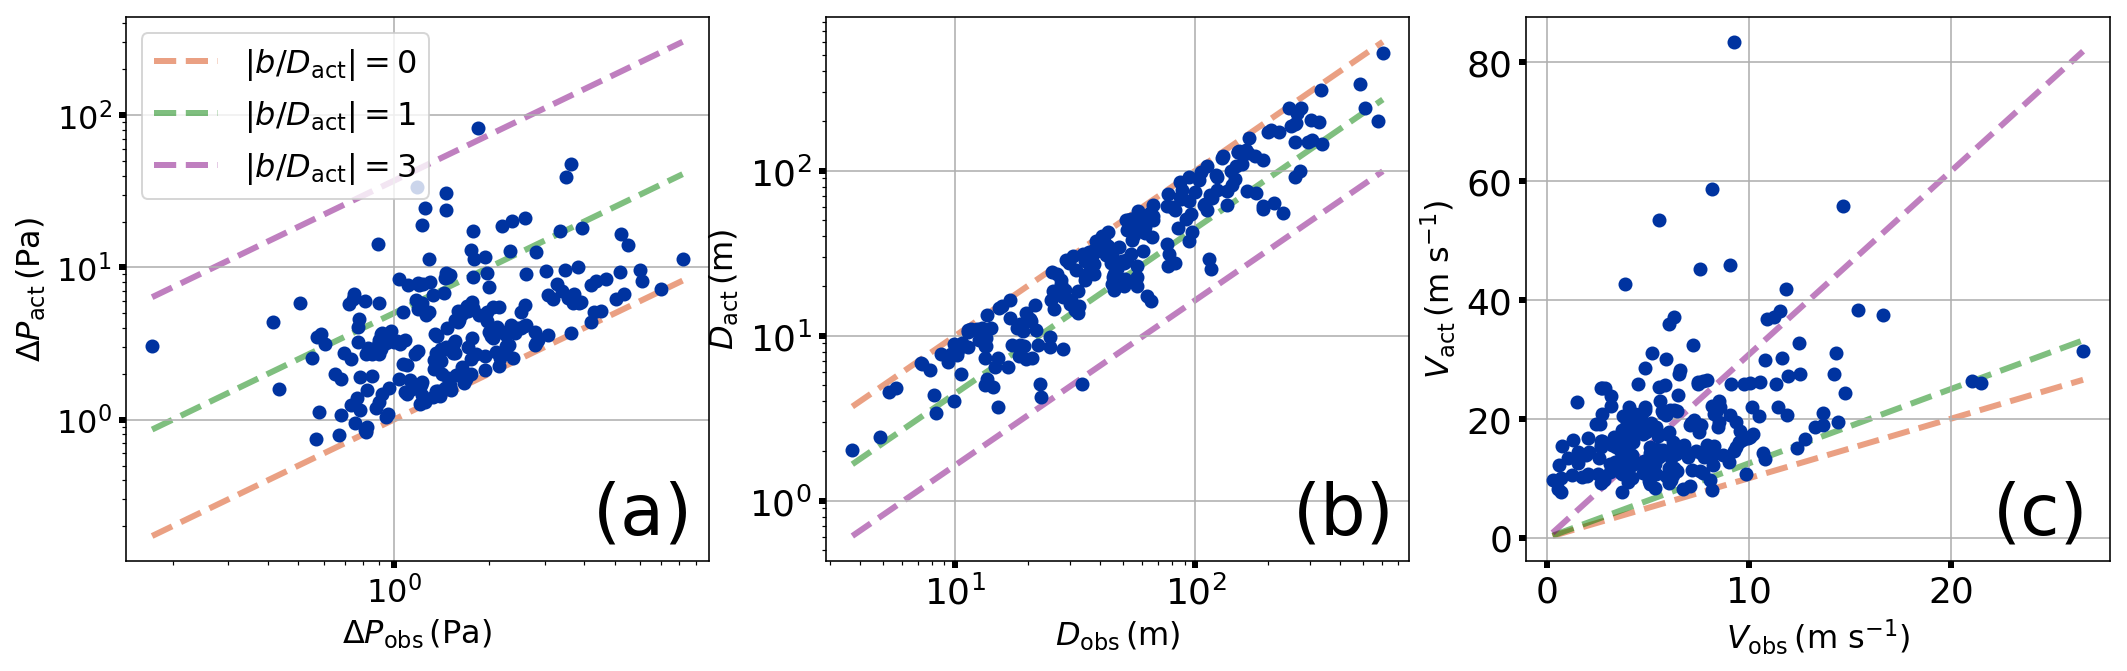

In [120]:
# 2020 Oct 1 - I'm going to use the actual fit values for b to determine the actual parameters
def calc_Dact(Dobs, b):
    return np.sqrt(Dobs**2 - (2.*b)**2)

def calc_Pact(Pobs, Dact, b):
    return Pobs*(1. + (2.*b/Dact)**2)

def calc_Vact(Vobs, Dact, b):
    return 0.5*Vobs*(1 + (2.*b/Dact)**2)/(2.*b/Dact)

filename = "all_vortices_with_diameters_and_actual_values.csv"
# ('srt_ind', 'vortex_number', 'sols', 'DeltaP', 'Diameter', 'U1', 'U2', 'Vobs', 'simple_Pact', 'simple_Vact', 
# 'simple_Dact', 'simple_bact', 'simple_BIC', 'simple_Vobs_sigma', 'full_Vobs', 'full_b', 'full_Pact', 'full_Vact', 
# 'full_Dact', 'full_bact', 'full_BIC', 'full_Vobs_sigma')
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
# ind = (2.*(data['simple_Pact'] - data['full_Pact'])/(data['simple_Pact'] + data['full_Pact']) < 0.25) &\
#     (2.*(data['simple_Dact'] - data['full_Dact'])/(data['simple_Dact'] + data['full_Dact']) < 0.25) &\
# (2.*(data['Vobs'] - data['full_Vact'])/(data['Vobs'] + data['full_Vact']) < 0.25) &\
#     (data['full_Vobs_sigma'] >= 3.) & (np.abs(data['full_b']/data['full_Dact']) < 10.)

ind = (data['full_Vobs_sigma'] >= 3.) &\
    (np.abs(data['full_b']/data['full_Dact']) < max_b_over_Dact) &\
    (np.abs(data['full_b']/data['full_Dact']) > min_b_over_Dact)

b_over_Dact = np.array([0, 1, 3])
colors=[BoiseState_orange, 'green', 'purple']

fig = plt.figure(figsize=(10*aspect_ratio, 5))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

# Dact = calc_Dact(data['Diameter'], data['full_b'])
# Pact = calc_Pact(data['DeltaP'], Dact, data['full_b'])
# Vact = calc_Vact(data['full_Vobs'], Dact, data['full_b'])

x = data['DeltaP'][ind]
# y = Pact[ind]
y = data['full_Pact'][ind]
print(np.quantile(y, 0.5))
ax1.loglog(x, y, marker='o', ls='', color=BoiseState_blue)
# Show the effects of off-center encounters
plot_x = np.linspace(np.min(x), np.max(x), 100)
for i in range(len(b_over_Dact)):
    cur_b_over_Dact = b_over_Dact[i]
    cur_color = colors[i]
    plot_y = plot_x*(1. + (2.*cur_b_over_Dact)**2)
    ax1.loglog(plot_x, plot_y, lw=3, ls='--', color=cur_color, zorder=-1, alpha=0.5,
               label=r'$|b/D_{\rm act}| = %i$' % cur_b_over_Dact)
# ax1.set_xlim([np.min([np.min(x), np.min(y)]), np.max([np.max(x), np.max(y)])])

ax1.legend(loc='upper left', fontsize=16)

x = data['Diameter'][ind]
# y = Dact[ind]
y = data['full_Dact'][ind]
print(np.quantile(y, 0.5))
ax2.loglog(x, y, marker='o', ls='', color=BoiseState_blue)
plot_x = np.linspace(np.min(x), np.max(x), 100)
for i in range(len(b_over_Dact)):
    cur_b_over_Dact = b_over_Dact[i]
    cur_color = colors[i]
    plot_y = plot_x/np.sqrt(1. + (2.*cur_b_over_Dact)**2)
    ax2.loglog(plot_x, plot_y, lw=3, ls='--', color=cur_color, zorder=-1, alpha=0.5)
# ax2.set_xlim([np.min([np.min(x), np.min(y)]), np.max([np.max(x), np.max(y)])])
    
# x = np.abs(data['full_b'][ind]/data['full_Dact'][ind])
x = np.abs(data['Vobs'][ind])
# y = Vact[ind]
y = np.abs(data['full_Vact'][ind])
ax3.plot(x, y, marker='o', ls='', color=BoiseState_blue)
plot_x = np.linspace(np.min(x), np.max(x), 100)

# plot_y = np.sqrt(plot_x/0.02)
# ax3.plot(plot_x, plot_y, lw=3, ls='--', color=BoiseState_orange)
for i in range(len(b_over_Dact)):
    cur_b_over_Dact = b_over_Dact[i]
    cur_color = colors[i]

    plot_y = 0.5*plot_x*(1 + (2.*cur_b_over_Dact)**2)/(2.*cur_b_over_Dact)
    if(cur_b_over_Dact == 0):
        plot_y = plot_x
    ax3.plot(plot_x, plot_y, lw=3, ls='--', color=cur_color, zorder=-1, alpha=0.5)
    
ax1.grid(True)
ax1.tick_params(labelsize=16)
ax1.set_xlabel(r'$\Delta P_{\rm obs}\, \left( {\rm Pa} \right)$', fontsize=16)
ax1.set_ylabel(r'$\Delta P_{\rm act}\, \left( {\rm Pa} \right)$', fontsize=16)
ax1.text(0.8, 0.05, '(a)', fontsize=36, transform=ax1.transAxes)

ax2.grid(True)
ax2.tick_params(labelsize=18)
ax2.set_xlabel(r'$D_{\rm obs}\, \left( {\rm m} \right)$', fontsize=16)
ax2.set_ylabel(r'$D_{\rm act}\, \left( {\rm m} \right)$', fontsize=16)
ax2.text(0.8, 0.05, '(b)', fontsize=36, transform=ax2.transAxes)

ax3.grid(True)
ax3.tick_params(labelsize=18)
ax3.set_xlabel(r'$V_{\rm obs}\, \left( {\rm m\ s^{-1}} \right)$', fontsize=16)
# ax3.set_xlabel(r'$\Delta P_{\rm act}\, \left( {\rm Pa} \right)$', fontsize=16)
# ax3.set_xlabel(r'$|b/D_{\rm act}|$', fontsize=16)
ax3.set_ylabel(r'$V_{\rm act}\, \left( {\rm m\ s^{-1}} \right)$', fontsize=16)
# ax3.yaxis.set_label_position("right")
# ax3.yaxis.tick_right()
# ax3.set_xlim([-10, 20])
# ax3.set_ylim([-10, 50])
ax3.text(0.8, 0.05, '(c)', fontsize=36, transform=ax3.transAxes)

# ax2.grid(True)
# ax2.tick_params(labelbottom=False, labelsize=24)
# ax2.set_ylabel(r'$N(x > P_{\rm act})$', fontsize=24)

# ax3.grid(True)
# ax3.yaxis.set_label_position("right")
# ax3.yaxis.tick_right()
# ax3.tick_params(labelsize=24)
# ax3.set_ylabel(r'$D_{\rm act}\, \left( {\rm m} \right)$', fontsize=36)
# ax3.set_xlabel(r'$N(x > D_{\rm act})$', fontsize=24)

# fig.savefig("../figures/Actual_vs_Observed_Values.png", dpi=500, bbox_inches='tight')

0.09777777777777778


Text(0, 0.5, '$V_{\\rm act}\\, \\left( {\\rm m\\ s^{-1}} \\right)$')

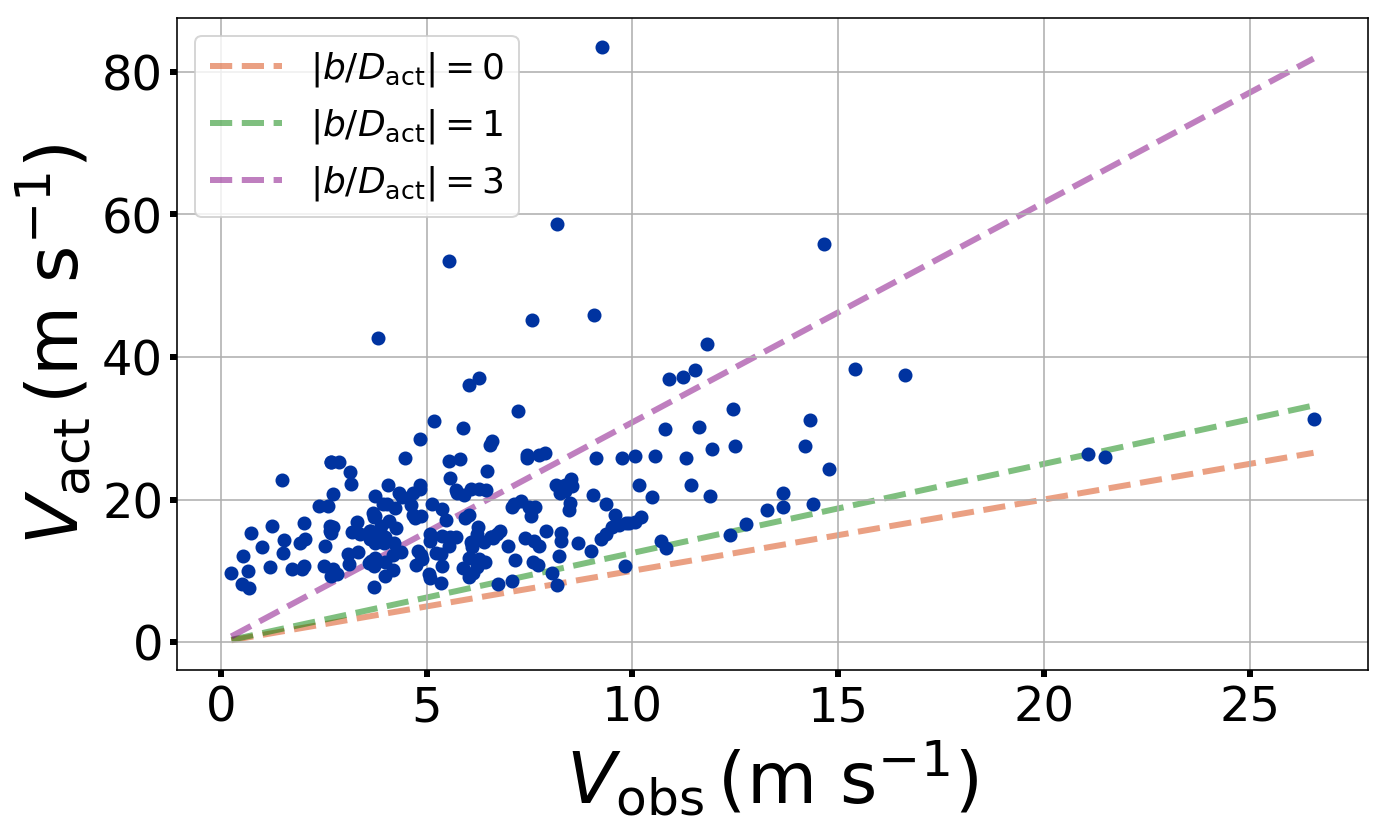

In [127]:
# 2020 Oct 1 - I'm going to use the actual fit values for b to determine the actual parameters

filename = "all_vortices_with_diameters_and_actual_values.csv"
# ('srt_ind', 'vortex_number', 'sols', 'DeltaP', 'Diameter', 'U1', 'U2', 'Vobs', 'simple_Pact', 'simple_Vact', 
# 'simple_Dact', 'simple_bact', 'simple_BIC', 'simple_Vobs_sigma', 'full_Vobs', 'full_b', 'full_Pact', 'full_Vact', 
# 'full_Dact', 'full_bact', 'full_BIC', 'full_Vobs_sigma')
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
# ind = (2.*(data['simple_Pact'] - data['full_Pact'])/(data['simple_Pact'] + data['full_Pact']) < 0.25) &\
#     (2.*(data['simple_Dact'] - data['full_Dact'])/(data['simple_Dact'] + data['full_Dact']) < 0.25) &\
# (2.*(data['Vobs'] - data['full_Vact'])/(data['Vobs'] + data['full_Vact']) < 0.25) &\
#     (data['full_Vobs_sigma'] >= 3.) & (np.abs(data['full_b']/data['full_Dact']) < 10.)

ind = (data['full_Vobs_sigma'] >= 3.) &\
    (np.abs(data['full_b']/data['full_Dact']) < max_b_over_Dact) &\
    (np.abs(data['full_b']/data['full_Dact']) > min_b_over_Dact)

b_over_Dact = np.array([0, 1, 3])
colors=[BoiseState_orange, 'green', 'purple']

fig = plt.figure(figsize=(6*aspect_ratio, 6))

ax3 = fig.add_subplot(111)

# Dact = calc_Dact(data['Diameter'], data['full_b'])
# Pact = calc_Pact(data['DeltaP'], Dact, data['full_b'])
# Vact = calc_Vact(data['full_Vobs'], Dact, data['full_b'])

# x = np.abs(data['full_b'][ind]/data['full_Dact'][ind])
x = np.abs(data['Vobs'][ind])
# y = Vact[ind]
y = np.abs(data['full_Vact'][ind])

Vmin = 30. # minimum velocity required to loft dust? 
# https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2006JE002700
# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2011GL049806
# https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2002JE001987
print(float(len(y[y > Vmin]))/float(len(y)))

ax3.plot(x, y, marker='o', ls='', color=BoiseState_blue)
plot_x = np.linspace(np.min(x), np.max(x), 100)

# plot_y = np.sqrt(plot_x/0.02)
# ax3.plot(plot_x, plot_y, lw=3, ls='--', color=BoiseState_orange)
for i in range(len(b_over_Dact)):
    cur_b_over_Dact = b_over_Dact[i]
    cur_color = colors[i]

    plot_y = 0.5*plot_x*(1 + (2.*cur_b_over_Dact)**2)/(2.*cur_b_over_Dact)
    if(cur_b_over_Dact == 0):
        plot_y = plot_x
    ax3.plot(plot_x, plot_y, lw=3, ls='--', color=cur_color, zorder=-1, alpha=0.5,
               label=r'$|b/D_{\rm act}| = %i$' % cur_b_over_Dact)
    
ax3.legend(loc='upper left', fontsize=18)    
ax3.grid(True)
ax3.tick_params(labelsize=24)
ax3.set_xlabel(r'$V_{\rm obs}\, \left( {\rm m\ s^{-1}} \right)$', fontsize=36)
ax3.set_ylabel(r'$V_{\rm act}\, \left( {\rm m\ s^{-1}} \right)$', fontsize=36)

# fig.savefig("../figures/Actual_vs_Observed_Velocities.png", dpi=500, bbox_inches='tight')

88
min+-err, med+-err, max Pact+-err:  1.1982 0.122617 3.3274 0.179266 16.6116 4.53331
min+-err, med+-err, max Dact+-err:  7.69126 2.18787 59.08695 17.6474 516.906 181.318
[-0.41260374  1.96256642]
BIC for line fit:  3270.7829868377976
BIC for median fit:  3369.8905731259188
[-1.27870783  2.24246901]
[0.04858524 0.02553304]
[-0.66456585  2.71801293]
[0.03261278 0.0549845 ]


Text(0.5, 0, '$N(x > D_{\\rm act})$')

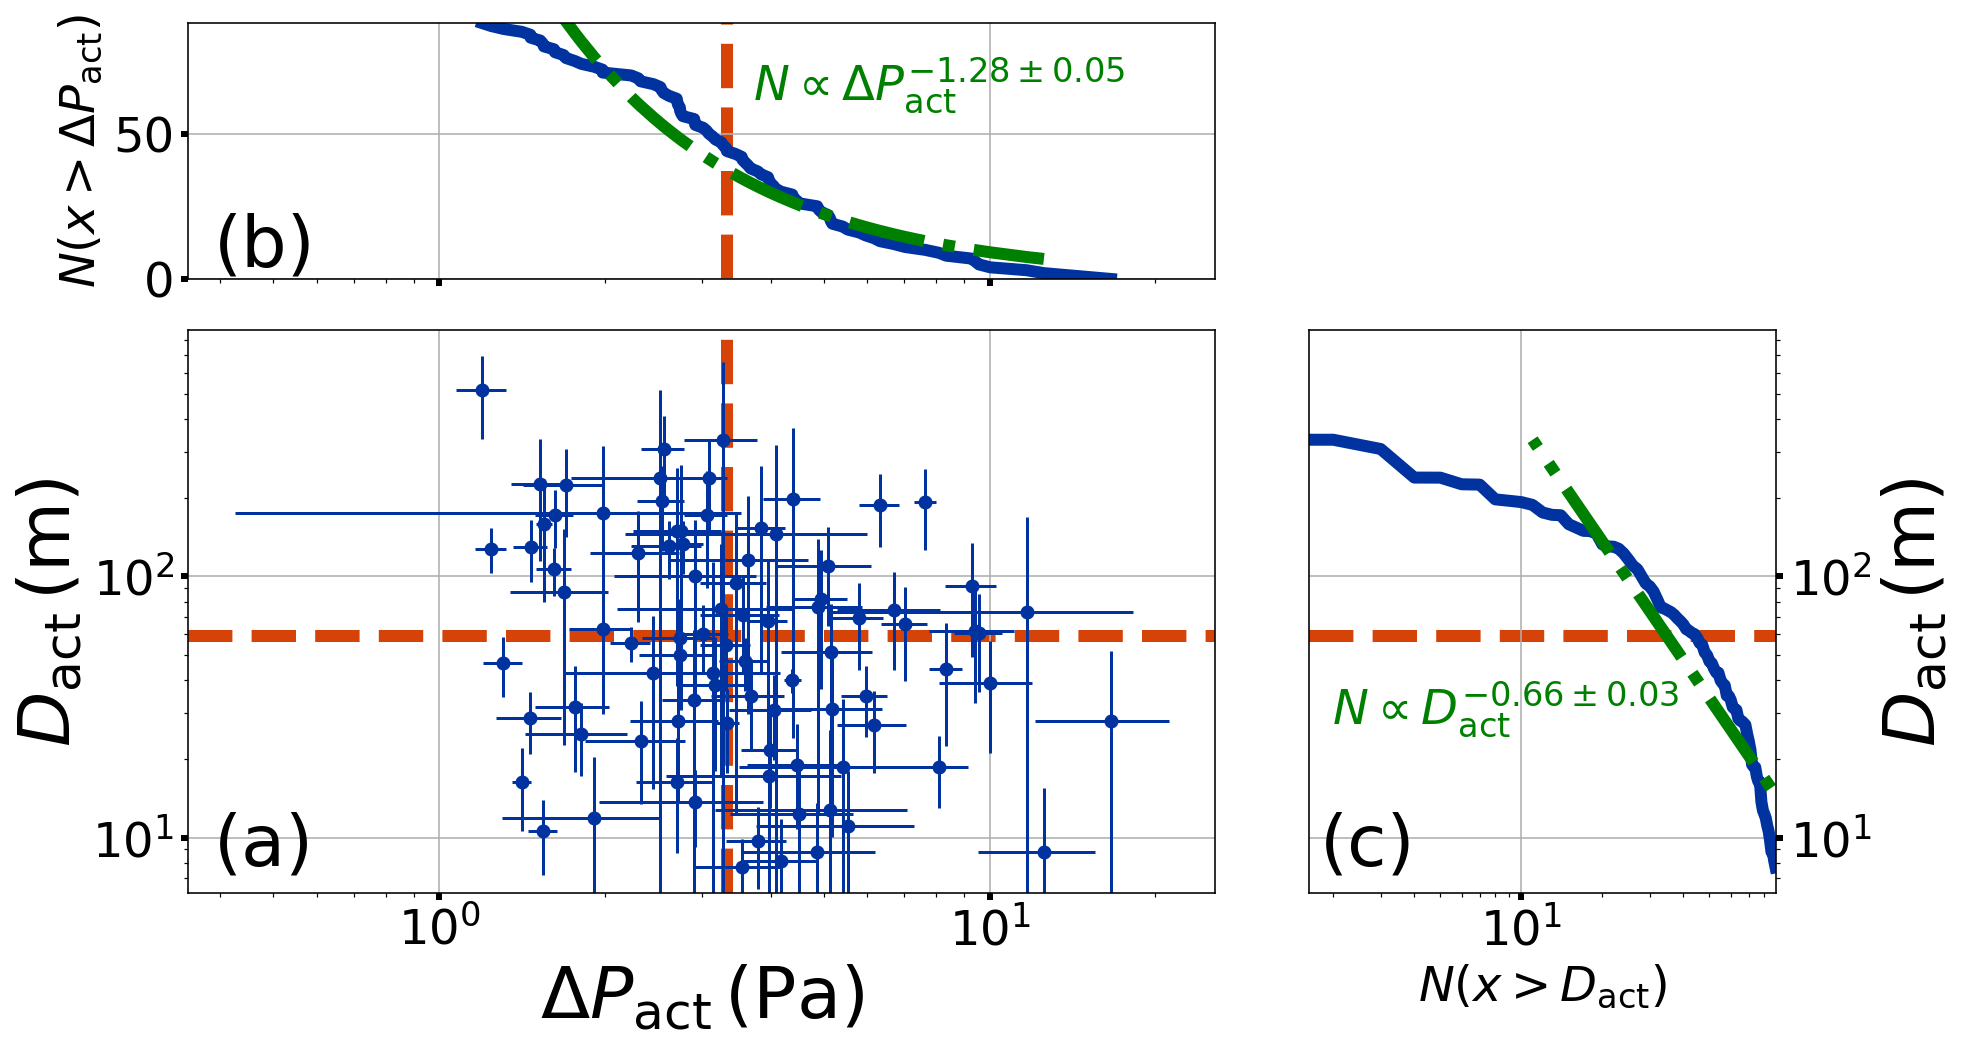

In [9]:
filename = "all_vortices_with_diameters_and_actual_values.csv"
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
# ind = (2.*(data['simple_Pact'] - data['full_Pact'])/(data['simple_Pact'] + data['full_Pact']) < 0.25) &\
#     (2.*(data['simple_Dact'] - data['full_Dact'])/(data['simple_Dact'] + data['full_Dact']) < 0.25) &\
#     (data['full_Vobs_sigma'] >= 3.)

# ind = (data['full_Vobs_sigma'] >= 3.) &\
#     (np.abs(data['full_b']/data['full_Dact']) < max_b_over_Dact)

ind = (np.abs(data['full_b']/data['full_Dact']) <= max_b_over_Dact) &\
    (data['full_Vobs_sigma'] >= min_full_Vobs_sigma) &\
    (np.isfinite(data['full_Pact_unc']) & np.isfinite(data['full_Dact_unc']))

x = data['full_Pact'][ind]
xerr = data['full_Pact_unc'][ind]
y = data['full_Dact'][ind]
yerr = data['full_Dact_unc'][ind]
print(len(y))

fig = plt.figure(figsize=(8*aspect_ratio, 8))

ax1 = plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1, sharex=ax1)
ax3 = plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2, sharey=ax1)

# ax1.loglog(x, y, marker='o', ls='', color=BoiseState_blue)
ax1.errorbar(x, y, xerr=xerr, yerr=yerr, marker='o', ls='', color=BoiseState_blue)
ax1.set_xscale('log')
ax1.set_yscale('log')

x_quantile = np.median(x)
mn_ind = np.argmin(x)
md_ind = np.argsort(x)[len(x)//2]
mx_ind = np.argmax(x)
print("min+-err, med+-err, max Pact+-err: ", x[mn_ind], xerr[mn_ind], 
      x_quantile, xerr[md_ind], x[mx_ind], xerr[mx_ind])
ax1.axvline(x_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)
y_quantile = np.median(y)
mn_ind = np.argmin(y)
md_ind = np.argsort(y)[len(y)//2]
mx_ind = np.argmax(y)
print("min+-err, med+-err, max Dact+-err: ", y[mn_ind], yerr[mn_ind], 
      y_quantile, yerr[md_ind], y[mx_ind], yerr[mx_ind])
ax1.axhline(y_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

coeffs = np.polyfit(np.log10(x), np.log10(y), 1)
srt = np.argsort(x)
# ax1.loglog(x[srt], 10.**(np.polyval(coeffs, np.log10(x)[srt])), lw=6, color='green', ls='-.')
# ax1.text(0.53, 0.85, r'$D_{\rm act} \propto \Delta P_{\rm act}^{%.2g}$' % coeffs[0], 
#          color='green', fontsize=36, transform=ax1.transAxes)
ax1.text(0.025, 0.05, '(a)', fontsize=36, transform=ax1.transAxes)

# 2021 Jan 27 - Check whether a line is a better fit than a median
print(coeffs)
print("BIC for line fit: ", BIC(np.log10(y[srt]), 10.**(np.polyval(coeffs, np.log10(x)[srt])), deg=2))
print("BIC for median fit: ", BIC(np.log10(y), np.ones_like(y)*y_quantile, deg=1))

### P_act cum hist ###
srt = np.argsort(x)
hst, _ = np.histogram(x[srt], bins=[0, *x[srt]])
cum_hst = len(x[srt]) - np.cumsum(hst)
ax2.semilogx(x[srt], cum_hst, lw=6, color=BoiseState_blue)
ax2.axvline(x_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

cum_hst_ind = np.isfinite(np.log10(cum_hst))
err = np.sqrt(np.log10(cum_hst))/(np.log(10.)*np.log10(cum_hst))
coeffs, cov = curve_fit(line, np.log10(x[srt])[cum_hst_ind], np.log10(cum_hst)[cum_hst_ind], 
                                  sigma=err[cum_hst_ind]) 
uncertainties = np.sqrt(np.diag(cov))
print(coeffs)
print(uncertainties)
ax2.semilogx(x[srt][cum_hst_ind], 10.**(np.polyval(coeffs, np.log10(x[srt])[cum_hst_ind])), 
             color='green', lw=6, ls='-.')
ax2.set_ylim([0, np.max(cum_hst)])
ax2.text(0.55, 0.7, r'$N \propto \Delta P_{\rm act}^{%.2f\pm%.2f}$' % (coeffs[0], uncertainties[0]),
         color='green', fontsize=24, transform=ax2.transAxes)
ax2.text(0.025, 0.05, '(b)', fontsize=36, transform=ax2.transAxes)

### D_act cum hist ###
srt = np.argsort(y)
hst, _ = np.histogram(y[srt], bins=[0, *y[srt]])
cum_hst = len(y[srt]) - np.cumsum(hst)
ax3.semilogy(cum_hst, y[srt], lw=6, color=BoiseState_blue)
ax3.axhline(y_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

cum_hst_ind = np.isfinite(np.log10(cum_hst))
err = np.sqrt(np.log10(cum_hst))/(np.log(10.)*np.log10(cum_hst))
coeffs, cov = curve_fit(line, np.log10(y[srt])[cum_hst_ind], np.log10(cum_hst)[cum_hst_ind], 
                                  sigma=err[cum_hst_ind]) 
uncertainties = np.sqrt(np.diag(cov))
print(coeffs)
print(uncertainties)
ax3.semilogx(10.**(np.polyval(coeffs, np.log10(y[srt])[cum_hst_ind])), y[srt][cum_hst_ind], 
             color='green', lw=6, ls='-.')
ax3.set_xlim([0, np.max(cum_hst)])
ax3.text(0.05, 0.3, r'$N \propto D_{\rm act}^{%.2f\pm%.2f}$' % (coeffs[0], uncertainties[0]),
         color='green', fontsize=24, transform=ax3.transAxes)

ax3.text(0.025, 0.05, '(c)', fontsize=36, transform=ax3.transAxes)

ax1.grid(True)
ax1.tick_params(labelsize=24)
ax1.set_xlabel(r'$\Delta P_{\rm act}\, \left( {\rm Pa} \right)$', fontsize=36)
ax1.set_ylabel(r'$D_{\rm act}\, \left( {\rm m} \right)$', fontsize=36)

ax2.grid(True)
ax2.tick_params(labelbottom=False, labelsize=24)
ax2.set_ylabel(r'$N(x > \Delta P_{\rm act})$', fontsize=24)

ax3.grid(True)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.tick_params(labelsize=24)
ax3.set_ylabel(r'$D_{\rm act}\, \left( {\rm m} \right)$', fontsize=36)
ax3.set_xlabel(r'$N(x > D_{\rm act})$', fontsize=24)

# fig.savefig("../figures/Dact_vs_Pact.png", dpi=500, bbox_inches='tight')

min+-err, med+-err, max Vact+-err:  9.17323 0.469368 15.6083 0.97518 37.4119 5.10485
3 0.03409090909090909


Text(0.5, 0, '$t_0\\,\\left( {\\rm LTST} \\right)$')

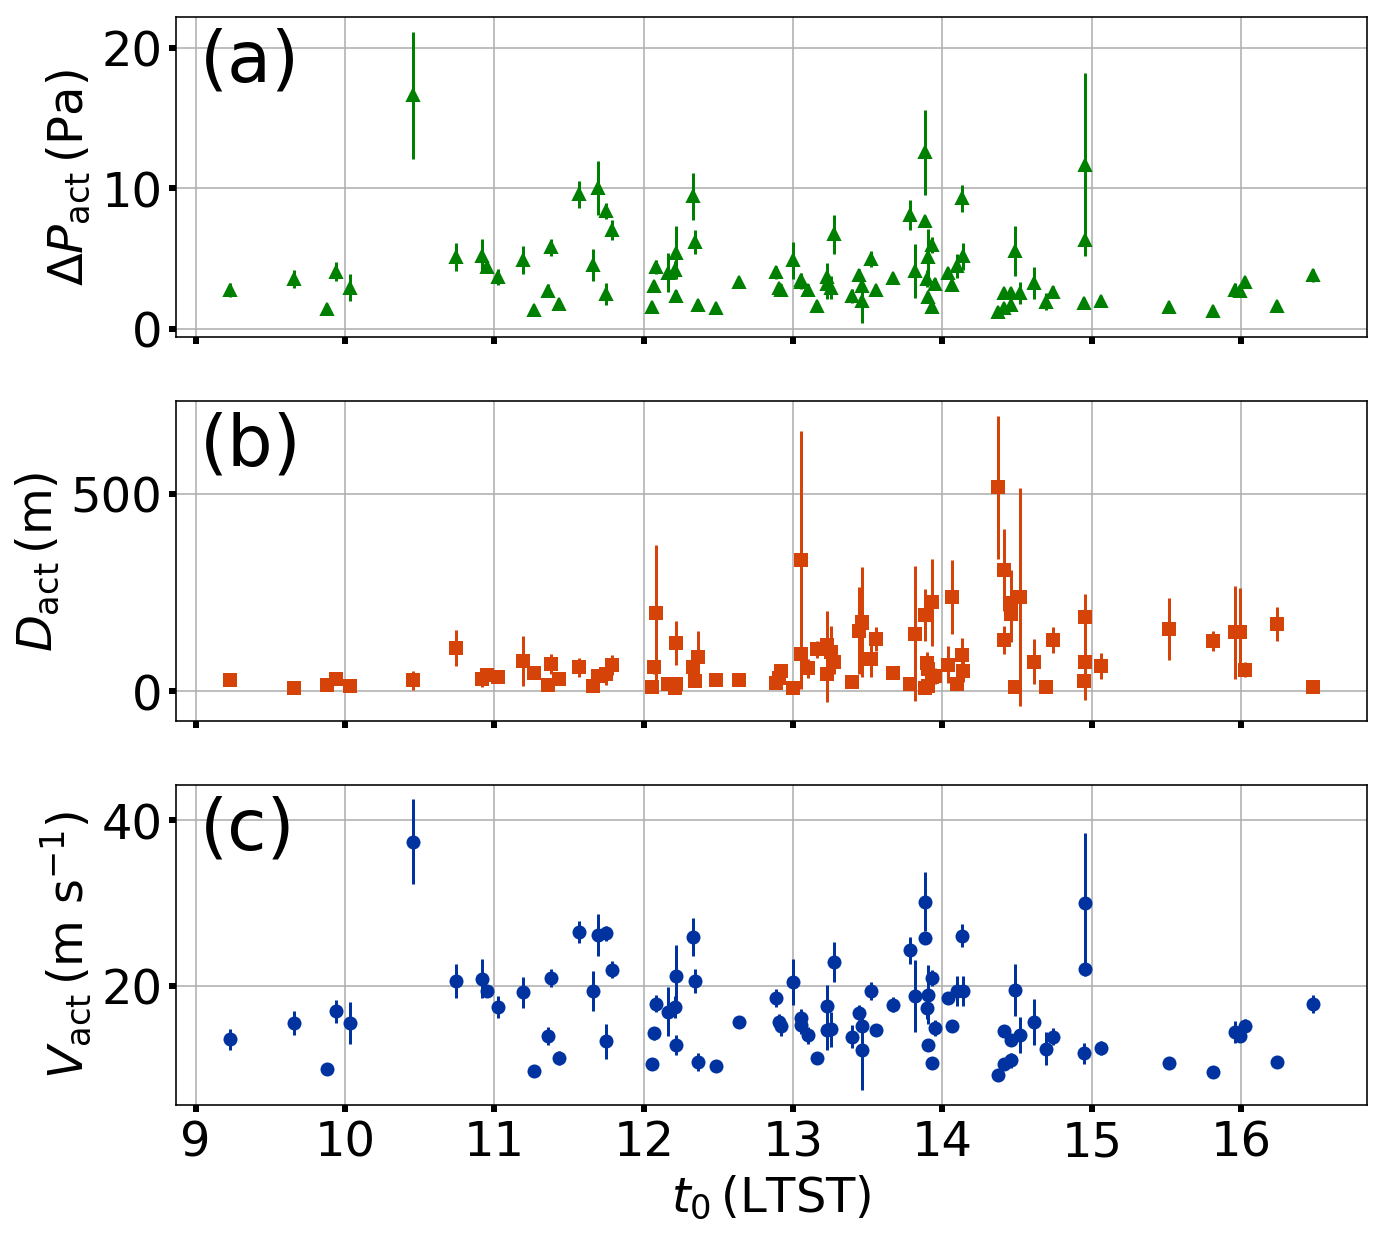

In [3]:
# 30 m/s threshold comes from:
# https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2006JE002700
# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2011GL049806
# https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2002JE001987

threshold_velocity = 30.

fig = plt.figure(figsize=(6*aspect_ratio, 10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312, sharex=ax1)
ax3 = fig.add_subplot(313, sharex=ax1)

filename = "all_vortices_with_diameters_and_actual_values.csv"
act_data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
ind = (np.abs(act_data['full_b']/act_data['full_Dact']) <= max_b_over_Dact) &\
    (act_data['full_Vobs_sigma'] >= min_full_Vobs_sigma) &\
    (np.isfinite(act_data['full_Pact_unc']) & np.isfinite(act_data['full_Dact_unc']))
vortex_number = act_data['vortex_number'][ind]
sols = act_data['sols'][ind]
x = act_data['full_Pact'][ind]
xerr = act_data['full_Pact_unc'][ind]
y = act_data['full_Dact'][ind]
yerr = act_data['full_Dact_unc'][ind]
z = act_data['full_Vact'][ind]
zerr = act_data['full_Vact_unc'][ind]

z_quantile = np.median(z)
mn_ind = np.argmin(z)
md_ind = np.argsort(z)[len(z)//2]
mx_ind = np.argmax(z)
print("min+-err, med+-err, max Vact+-err: ", z[mn_ind], zerr[mn_ind], 
      z_quantile, zerr[md_ind], z[mx_ind], zerr[mx_ind])

# 2021 Jan 28 - Unfortunately, I kept the t0-values in a different file.
filename = "all_vortices_with_diameters.csv"
other_data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)

# Collate two datasets
t0 = np.array([])
mx_ind = np.argsort(x)[-2]
for i in range(len(vortex_number)):
    cur_vort_num = vortex_number[i]
    cur_sol = sols[i]
    ind = (other_data['vortex_number'] == cur_vort_num) & (other_data['sol'] == cur_sol)
    t0 = np.append(t0, other_data['t0'][ind][0])
    
#     if(i == mx_ind):
#         print(other_data['vortex_number'][ind], other_data['sol'][ind])
    
# ax1.scatter(t0, x, color='green', marker='^')
# ax2.scatter(t0, y, color=BoiseState_orange, marker='s')
# ax3.scatter(t0, z, color=BoiseState_blue)

ax1.errorbar(t0, x, yerr=xerr, color='green', marker='^', ls='')
ax2.errorbar(t0, y, yerr=yerr, color=BoiseState_orange, marker='s', ls='')
ax3.errorbar(t0, z, yerr=zerr, color=BoiseState_blue, marker='o', ls='')

# ax3.axhline(threshold_velocity, color='lightgrey', lw=6, ls='--', zorder=-1)

print(len(z[z >= threshold_velocity]), z[z >= threshold_velocity].shape[0]/z.shape[0])

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

ax1.tick_params(labelbottom=False, labelsize=24)
ax2.tick_params(labelbottom=False, labelsize=24)
ax3.tick_params(labelsize=24)

ax1.text(0.02, 0.8, "(a)", fontsize=36, transform=ax1.transAxes)
ax2.text(0.02, 0.8, "(b)", fontsize=36, transform=ax2.transAxes)
ax3.text(0.02, 0.8, "(c)", fontsize=36, transform=ax3.transAxes)

ax1.set_ylabel(r'$\Delta P_{\rm act}\,\left( {\rm Pa} \right)$', fontsize=24)
ax2.set_ylabel(r'$D_{\rm act}\,\left( {\rm m} \right)$', fontsize=24)
ax3.set_ylabel(r'$V_{\rm act}\,\left( {\rm m\ s^{-1}} \right)$', fontsize=24)
ax3.set_xlabel(r'$t_0\,\left( {\rm LTST} \right)$', fontsize=24)

# fig.savefig("../figures/all_actual_values_vs_t0.png", dpi=500, bbox_inches="tight")

360.57863675471845


Text(0.02, 0.875, '(a)')

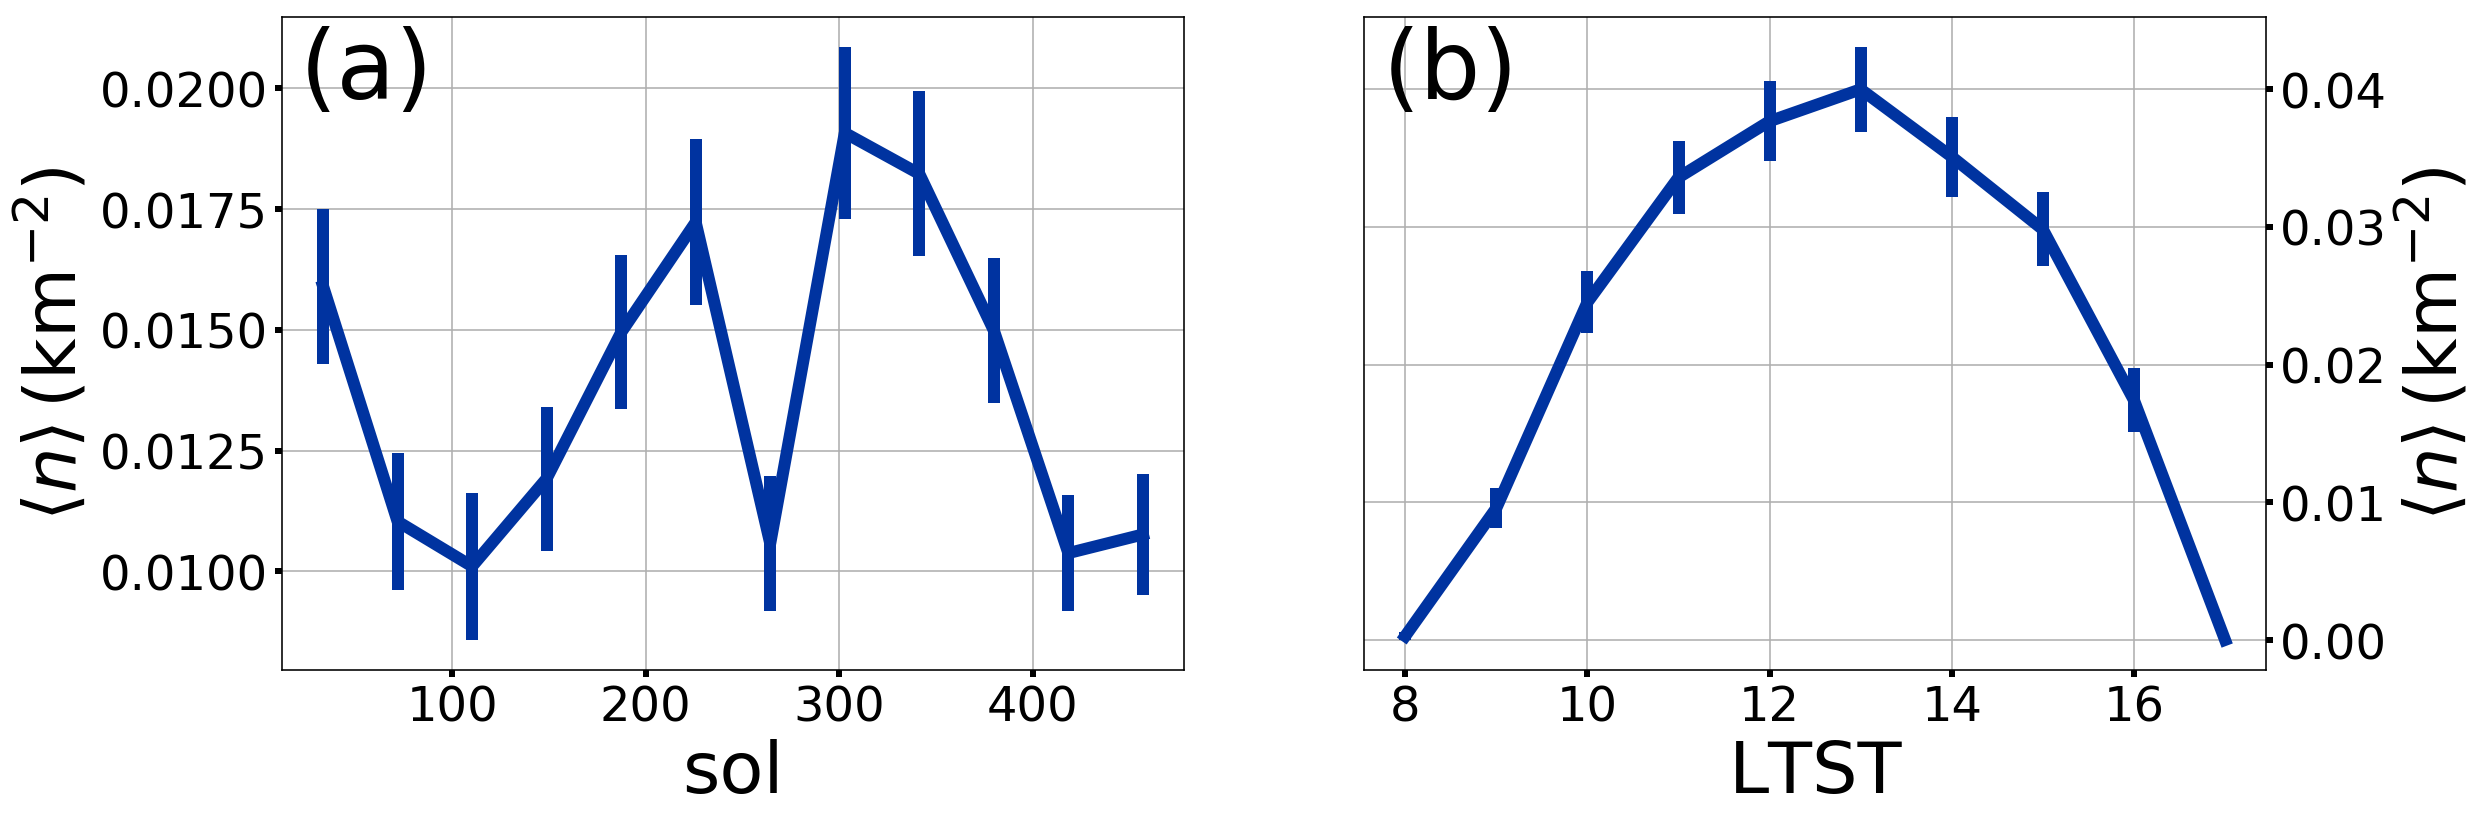

In [7]:
# 2021 Feb 11 - Calculating population average
def product(Dact, Pact, Pmin=0.1):
    return Dact*np.sqrt(Pact/Pmin - 1.) #2 b_max

fig = plt.figure(figsize=(10*aspect_ratio, 6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

seconds_in_martian_hour = 3697.
seconds_in_martian_sol = 24*3600. + 39*60. + 35.

filename = "all_vortices_with_diameters_and_actual_values.csv"
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
ind = (np.abs(data['full_b']/data['full_Dact']) <= max_b_over_Dact) &\
    (data['full_Vobs_sigma'] >= min_full_Vobs_sigma) &\
    (np.isfinite(data['full_Pact_unc']) & np.isfinite(data['full_Dact_unc']))

winds_filename = "sols_hour_median_winds.csv"
winds_data = np.genfromtxt(winds_filename, dtype=None, delimiter=',', names=True)

products = product(data['full_Dact'][ind], data['full_Pact'][ind])
mn_prod = np.min(products)
med_prod = np.median(products)
mean_prod = np.mean(products)
mx_prod = np.max(products)

areal_density_by_hour = np.array([])
areal_density_by_hour_err = np.array([])
for i in range(len(TOD_bins)):
    winds_name = str(int(np.floor(TOD_bins[i]))) + "_median_wind"
    
    cur_U = np.mean(winds_data[winds_name])
    
    areal_density_by_hour = np.append(areal_density_by_hour,
        TOD_hst[i]/seconds_in_martian_hour/cur_U/med_prod)
    areal_density_by_hour_err = np.append(areal_density_by_hour_err,
        TOD_hst_err[i]/seconds_in_martian_hour/cur_U/med_prod)
    
ax2.errorbar(TOD_bins, areal_density_by_hour*1e6, 
             yerr=areal_density_by_hour_err*1e6, color=BoiseState_blue, lw=6)
ax2.tick_params(labelsize=24)
ax2.set_xlabel("LTST", fontsize=36)
ax2.set_ylabel(r'$\langle n \rangle\,\left( {\rm km^{-2}} \right)$', fontsize=36)
ax2.grid(True)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.text(0.02, 0.875, "(b)", fontsize=48, transform=ax2.transAxes)

binsize = sol_bins[1] - sol_bins[0]
areal_density_by_sol = np.array([])
areal_density_by_sol_err = np.array([])
for i in range(len(sol_bin_edges)-1):
    sol_ind = (winds_data['sol'] >= sol_bin_edges[i]) & (winds_data['sol'] < sol_bin_edges[i+1])
    
    num_entries = 0.
    cur_U = 0.
    for j in range(0, 24):
        winds_name = str(j) + "_median_wind"
        cur_U += np.sum(winds_data[winds_name][sol_ind])
        num_entries += len(winds_data[winds_name][sol_ind])
        
    cur_U /= num_entries

    areal_density_by_sol = np.append(areal_density_by_sol,
        sol_hst[i]/seconds_in_martian_sol/cur_U/med_prod)
    areal_density_by_sol_err = np.append(areal_density_by_sol_err,
        sol_hst_err[i]/seconds_in_martian_sol/cur_U/med_prod)

ax1.errorbar(sol_bins, areal_density_by_sol*1e6, 
             yerr=areal_density_by_sol_err*1e6, color=BoiseState_blue, lw=6)
ax1.tick_params(labelsize=24)
ax1.set_xlabel("sol", fontsize=36)
ax1.set_ylabel(r'$\langle n \rangle\,\left( {\rm km^{-2}} \right)$', fontsize=36)
ax1.grid(True)
ax1.text(0.02, 0.875, "(a)", fontsize=48, transform=ax1.transAxes)

# 2021 Jan 14 - Adding Ls using this website - http://www-mars.lmd.jussieu.fr/mars/time/martian_time.html
#
# How did I calculate these, you ask? As follows:
#   1. Choose desired Ls-values to display - 0, 30, 60, etc. (corresponding to Spiga's spacing)
#   2. Figured out the Mars year and sol when InSight landed using the above website -- MY 34, sol 555
#   3. Calculated the date corresponding to each Ls for the desired year using this website 
#      (http://www-mars.lmd.jussieu.fr/mars/time/mars_date_to_earth_date.html) - 
#      E.g., Ls = 0 during the first year means MY 35 is 2019 Mar 23. Type that date back into the former
#      website to calculate the sol # (sol 1 in MY 35)
#   4. There are 668.59 sols in one Mars year, so since InSight landed in MY 34, 
#      sol 1 in MY 35 is mission sol 668.59 + 1 - 555 = 115.
#
# Check notebook notes from today for the conversions!
# ax1.axvline(115, lw=3, ls='--', color='grey', zorder=-1)
# ax1.text(121, 0.02, r'$0^{\circ}$',rotation=-90, color='k', fontsize=24)

# ax1.axvline(176, lw=3, ls='--', color='grey', zorder=-1)
# ax1.text(181, 0.02, r'$30^{\circ}$',rotation=-90, color='k', fontsize=24)

# ax1.axvline(241, lw=3, ls='--', color='grey', zorder=-1)
# ax1.text(246, 0.02, r'$60^{\circ}$',rotation=-90, color='k', fontsize=24)

# ax1.axvline(308, lw=3, ls='--', color='grey', zorder=-1)
# ax1.text(313, 0.02, r'$90^{\circ}$',rotation=-90, color='k', fontsize=24)

# ax1.axvline(373, lw=3, ls='--', color='grey', zorder=-1)
# ax1.text(378, 0.02, r'$120^{\circ}$',rotation=-90, color='k', fontsize=24)

# ax1.axvline(431, lw=3, ls='--', color='grey', zorder=-1)
# ax1.text(436, 0.02, r'$L_{\rm s} = 150^{\circ}$',rotation=-90, color='k', fontsize=24)

# ax1.axvline(8, lw=3, ls='--', color='grey', zorder=-1)
# ax1.text(13, 0.02, r'$300^{\circ}$',rotation=-90, color='k', fontsize=24)

# ax1.axvline(59, lw=3, ls='--', color='grey', zorder=-1)
# ax1.text(64, 0.02, r'$330^{\circ}$',rotation=-90, color='k', fontsize=24)

# fig.savefig("../figures/areal_density.png", dpi=500, bbox_inches="tight")

12.66892


Text(0.5, 0, '$f(V_{\\rm act} \\leq y) \\,\\left( {\\rm \\%} \\right)$')

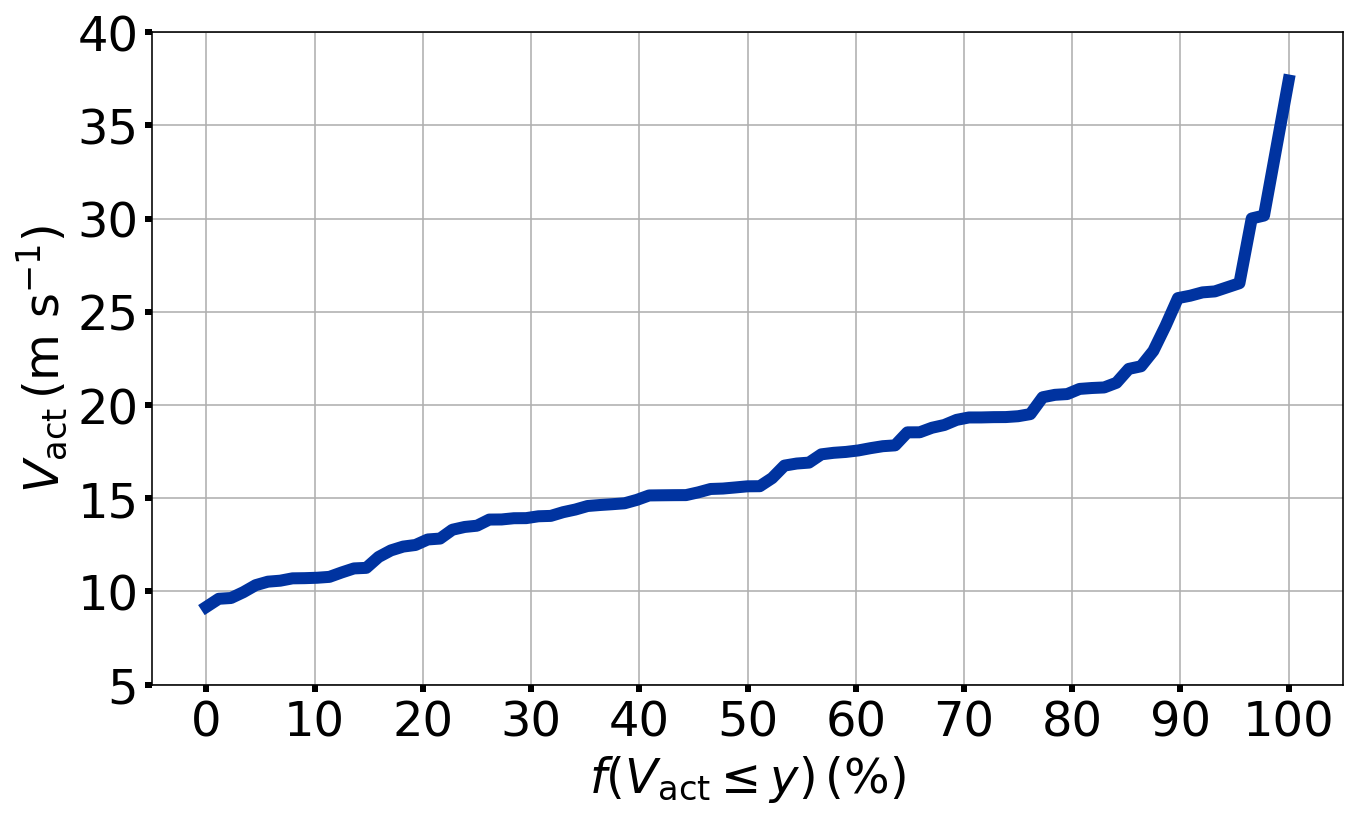

In [8]:
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

filename = "all_vortices_with_diameters_and_actual_values.csv"
act_data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
ind = (np.abs(act_data['full_b']/act_data['full_Dact']) <= max_b_over_Dact) &\
    (act_data['full_Vobs_sigma'] >= min_full_Vobs_sigma) &\
    (np.isfinite(act_data['full_Pact_unc']) & np.isfinite(act_data['full_Dact_unc']))

z = act_data['full_Vact'][ind]
bin_edges = np.array([-np.inf, *np.sort(z)])

hst, bin_edges = np.histogram(z, bins=bin_edges)
frac_cumsum = np.cumsum(hst)
frac_cumsum = frac_cumsum/len(z)

ax.plot(frac_cumsum*100., bin_edges[1:], lw=6, color=BoiseState_blue)

print(np.interp(0.2, frac_cumsum, bin_edges[1:]))
# print(np.interp(0.62, frac_cumsum, bin_edges[1:]))

ax.grid(True)
ax.tick_params(labelsize=24)
ax.set_xticks(np.arange(0, 110, 10))
ax.set_yticks(np.arange(5, 45, 5))

ax.set_ylabel(r'$V_{\rm act}\,\left( {\rm m\ s^{-1}} \right)$', fontsize=24)
ax.set_xlabel(r'$f(V_{\rm act} \leq y) \,\left( {\rm \%} \right)$', fontsize=24)

# fig.savefig("../figures/cum_hist_Vact.png", dpi=500, bbox_inches="tight")

In [9]:
# 2020 Sep 26 - Explore how often Vobs is the same as U1/U2
filename = "all_vortices_with_diameters_and_actual_values.csv"
# ('srt_ind', 'vortex_number', 'sols', 'DeltaP', 'Diameter', 'U1', 'U2', 'Vobs', 'simple_Pact', 'simple_Vact', 
# 'simple_Dact', 'simple_bact', 'simple_BIC', 'simple_Vobs_sigma', 'full_Vobs', 'full_b', 'full_Pact', 'full_Vact', 
# 'full_Dact', 'full_bact', 'full_BIC', 'full_Vobs_sigma')
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
ind = (2.*(data['simple_Pact'] - data['full_Pact'])/(data['simple_Pact'] + data['full_Pact']) < 0.25) &\
    (2.*(data['simple_Dact'] - data['full_Dact'])/(data['simple_Dact'] + data['full_Dact']) < 0.25)
num_vortices_wo_wind = len(data['simple_Dact'][ind])
print("Number of vortex encounters with meaningful model fits: ", num_vortices_wo_wind)

ind = (2.*(data['simple_Pact'] - data['full_Pact'])/(data['simple_Pact'] + data['full_Pact']) < 0.25) &\
    (2.*(data['simple_Dact'] - data['full_Dact'])/(data['simple_Dact'] + data['full_Dact']) < 0.25) &\
    (data['full_Vobs_sigma'] >= 3.)
num_agreeable_vortices = len(data['simple_Dact'][ind])
print("Number of vortex encounters with meaningful model fits that also differ from background: ",
            num_agreeable_vortices)

print(num_vortices_wo_wind - num_agreeable_vortices, 
      (num_vortices_wo_wind - num_agreeable_vortices)/num_agreeable_vortices)

Number of vortex encounters with meaningful model fits:  183
Number of vortex encounters with meaningful model fits that also differ from background:  127
56 0.4409448818897638


min, med, max Vact:  8.32567 15.54815 37.4119
[-0.71272728  2.56707686]
[-2.71786536  4.83564008]
[-0.77284678  2.88191902]


Text(0.5, 0, '$N(x > D_{\\rm act})$')

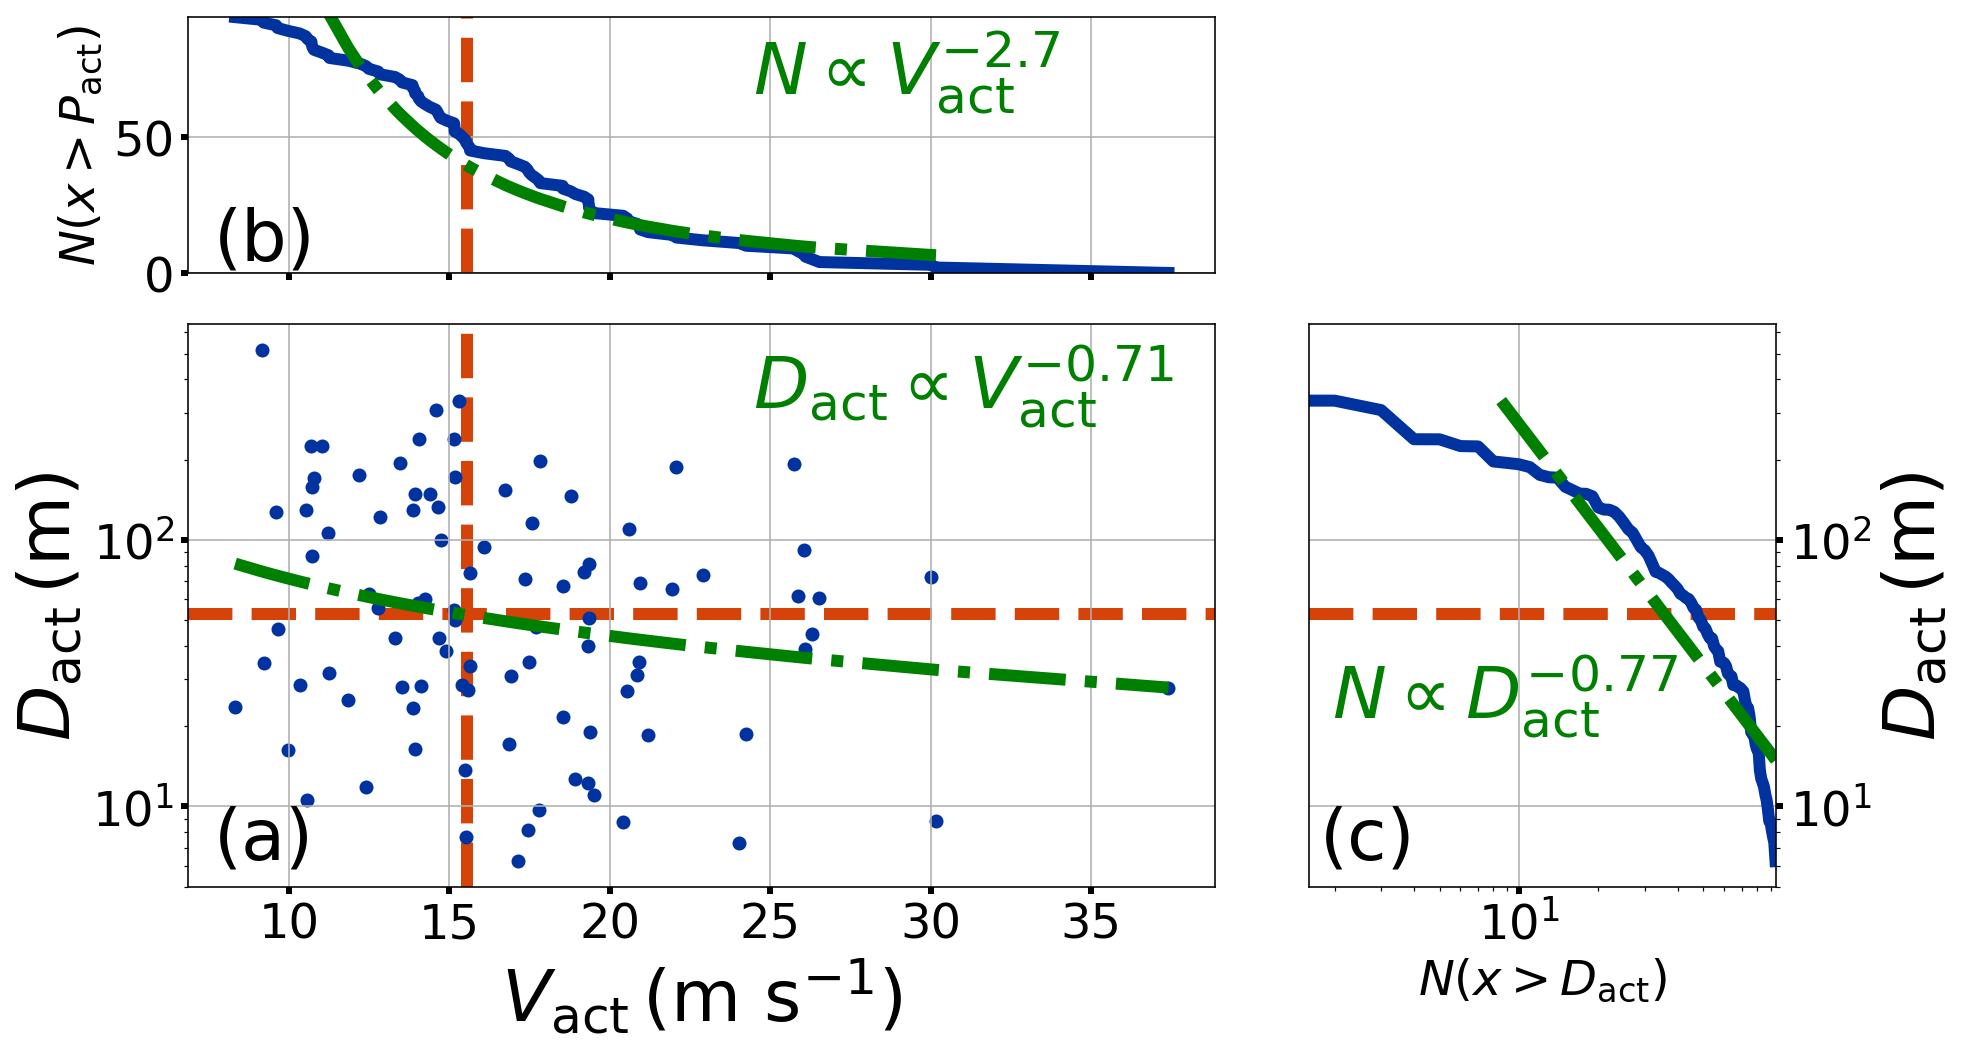

In [8]:
filename = "all_vortices_with_diameters_and_actual_values.csv"
# ('srt_ind', 'vortex_number', 'sols', 'DeltaP', 'Diameter', 'U1', 'U2', 'Vobs', 'simple_Pact', 'simple_Vact', 
# 'simple_Dact', 'simple_bact', 'simple_BIC', 'simple_Vobs_sigma', 'full_Vobs', 'full_b', 'full_Pact', 'full_Vact', 
# 'full_Dact', 'full_bact', 'full_BIC', 'full_Vobs_sigma')
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
ind = (np.abs(data['full_b']/data['full_Dact']) <= max_b_over_Dact) &\
    (data['full_Vobs_sigma'] >= min_full_Vobs_sigma)

x = data['full_Vact'][ind]
y = data['full_Dact'][ind]

fig = plt.figure(figsize=(8*aspect_ratio, 8))

ax1 = plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1, sharex=ax1)
ax3 = plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2, sharey=ax1)

# ax1.loglog(x, y, marker='o', ls='', color=BoiseState_blue)
ax1.scatter(x, y, marker='o', color=BoiseState_blue)
ax1.set_yscale('log')

x_quantile = np.median(x)
print("min, med, max Vact: ", np.min(x), np.median(x), np.max(x))
ax1.axvline(x_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)
y_quantile = np.median(y)
ax1.axhline(y_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

coeffs = np.polyfit(np.log10(x), np.log10(y), 1)
print(coeffs)
srt = np.argsort(x)
ax1.semilogy(x[srt], 10.**(np.polyval(coeffs, np.log10(x)[srt])), lw=6, color='green', ls='-.')
ax1.text(0.55, 0.85, r'$D_{\rm act} \propto V_{\rm act}^{%.2g}$' % coeffs[0], 
         color='green', fontsize=36, transform=ax1.transAxes)
ax1.text(0.025, 0.05, '(a)', fontsize=36, transform=ax1.transAxes)

### P_act cum hist ###
srt = np.argsort(x)
hst, _ = np.histogram(x[srt], bins=[0, *x[srt]])
cum_hst = len(x[srt]) - np.cumsum(hst)
ax2.plot(x[srt], cum_hst, lw=6, color=BoiseState_blue)
ax2.axvline(x_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

cum_hst_ind = np.isfinite(np.log10(cum_hst))
coeffs = np.polyfit(np.log10(x[srt])[cum_hst_ind], np.log10(cum_hst)[cum_hst_ind], 1)
print(coeffs)
ax2.plot(x[srt][cum_hst_ind], 10.**(np.polyval(coeffs, np.log10(x[srt])[cum_hst_ind])), 
             color='green', lw=6, ls='-.')
ax2.set_ylim([0, np.max(cum_hst)])
ax2.text(0.55, 0.7, r'$N \propto V_{\rm act}^{%.2g}$' % coeffs[0], 
         color='green', fontsize=36, transform=ax2.transAxes)
ax2.text(0.025, 0.05, '(b)', fontsize=36, transform=ax2.transAxes)

### D_act cum hist ###
srt = np.argsort(y)
hst, _ = np.histogram(y[srt], bins=[0, *y[srt]])
cum_hst = len(y[srt]) - np.cumsum(hst)
ax3.semilogy(cum_hst, y[srt], lw=6, color=BoiseState_blue)
ax3.axhline(y_quantile, lw=6, ls='--', color=BoiseState_orange, zorder=-1)

cum_hst_ind = np.isfinite(np.log10(cum_hst))
coeffs = np.polyfit(np.log10(y[srt])[cum_hst_ind], np.log10(cum_hst)[cum_hst_ind], 1)
print(coeffs)
ax3.semilogx(10.**(np.polyval(coeffs, np.log10(y[srt])[cum_hst_ind])), y[srt][cum_hst_ind], 
             color='green', lw=6, ls='-.')
ax3.set_xlim([0, np.max(cum_hst)])
ax3.text(0.05, 0.3, r'$N \propto D_{\rm act}^{%.2g}$' % coeffs[0], 
         color='green', fontsize=36, transform=ax3.transAxes)
ax3.text(0.025, 0.05, '(c)', fontsize=36, transform=ax3.transAxes)

ax1.grid(True)
ax1.tick_params(labelsize=24)
ax1.set_xlabel(r'$V_{\rm act}\, \left( {\rm m\ s^{-1}} \right)$', fontsize=36)
ax1.set_ylabel(r'$D_{\rm act}\, \left( {\rm m} \right)$', fontsize=36)

ax2.grid(True)
ax2.tick_params(labelbottom=False, labelsize=24)
ax2.set_ylabel(r'$N(x > P_{\rm act})$', fontsize=24)

ax3.grid(True)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.tick_params(labelsize=24)
ax3.set_ylabel(r'$D_{\rm act}\, \left( {\rm m} \right)$', fontsize=36)
ax3.set_xlabel(r'$N(x > D_{\rm act})$', fontsize=24)

# fig.savefig("../figures/Dact_vs_Pact.png", dpi=500, bbox_inches='tight')

In [26]:
# 2020 Sep 9 - Commented everything out

filename = "all_vortices_2020Aug9.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)
sols = data['sol'][ind]
t0 = data['t0'][ind]
vortex_number = data['vortex_number'][ind]
Gamma = data['Gamma'][ind]
DeltaP = data['DeltaP'][ind]
slope = data['slope'][ind]
intercept = data['intercept'][ind]

new_filename = "anticipating_encounters.csv"
f = open(new_filename, "w")
f.write("# srt_ind, vortex_number, sols, DeltaP, Gamma, pressure_scatter, dpdt_scatter,"+\
        " pressure_outlier_time, dpdt_outlier_time\n")

# Fit the vortices in order from deepest to least deep until we can't fit 'em no more
srt = np.argsort(DeltaP)[::-1]

last_sol = 0
# for srt_ind in range(len(sols)):
# for srt_ind in [srt[200]]:
for srt_ind in srt[0:201]:
    
    if(sols[srt_ind] != last_sol):
        LTST, LTST_and_sol, sol_data = retrieve_data(sols[srt_ind], dr=dr)
        LTST_and_sol -= 24.*sols[srt_ind]
        
        wind_LTST, wind_LTST_and_sol, wind_data = find_wind(sols[srt_ind], dr_wind=dr_wind)
        wind_LTST_and_sol -= 24.*sols[srt_ind]

        last_sol = sols[srt_ind]
        
#     try:
    wind_x, wind_y, wind_sigma, pressure_x, pressure_y, pressure_sigma, density =\
        abbrev_retrieve_wind_and_pressure(wind_LTST, wind_LTST_and_sol, wind_data, LTST, LTST_and_sol, sol_data, 
                                      t0[srt_ind], np.max([100., Gamma[srt_ind]]))

    detrended_pressure_y = pressure_y - np.polyval([slope[srt_ind], intercept[srt_ind]], pressure_x)

    pressure_outlier_time = np.nan
    ind = (detrended_pressure_y - np.median(detrended_pressure_y)) < -num_sig*mad(detrended_pressure_y)
    if(len(pressure_x[ind]) >= 1):
        sorted_ind = np.argsort(pressure_x[ind])[0]
        pressure_outlier_time = pressure_x[ind][sorted_ind]*3600

    dpdt_outlier_time = np.nan
    dp_dt = np.gradient(detrended_pressure_y, pressure_x*3600.)
    ind = (dp_dt - np.median(dp_dt)) < -num_sig*mad(dp_dt)
    if(len(pressure_x[ind])):
        sorted_ind = np.argsort(pressure_x[ind])[0]
        dpdt_outlier_time = pressure_x[ind][sorted_ind]*3600

#         plt.scatter(pressure_x*3600., dp_dt)
#         plt.axhline(np.median(dp_dt), color='grey', lw=3, zorder=-1)
#         plt.axhline(np.median(dp_dt) - mad(dp_dt), color='grey', lw=3, zorder=-1, ls='--')
#         plt.axhline(np.median(dp_dt) + mad(dp_dt), color='grey', lw=3, zorder=-1, ls='--')

#     plt.axvline(dpdt_outlier_time)
#         plt.plot(pressure_x[ind][sorted_ind]*3600., dp_dt[ind][sorted_ind], color='grey', 
#                  ls='', marker='o', markersize=30, fillstyle='none')

#         plt.xlim([-10*Gamma[srt_ind], 10*Gamma[srt_ind]])
#         print(dpdt_outlier_time/(Gamma[srt_ind]/3600.))

    print("%i, %i, %i, %g, %g, %g, %g, %g, %g" %\
          (srt_ind, vortex_number[srt_ind], sols[srt_ind], DeltaP[srt_ind], Gamma[srt_ind],
           mad(detrended_pressure_y), mad(dp_dt), pressure_outlier_time, dpdt_outlier_time))
    f.write("%i, %i, %i, %g, %g, %g, %g, %g, %g\n" %\
            (srt_ind, vortex_number[srt_ind], sols[srt_ind], DeltaP[srt_ind], Gamma[srt_ind],
           mad(detrended_pressure_y), mad(dp_dt), pressure_outlier_time, dpdt_outlier_time))

#     except:
#         print("sol %i, vortex_number %i didn't work!" % (sols[srt_ind], vortex_number[srt_ind]))
    
f.close()

178, 6, 65, 8.88687, 3.27531, 0.140749, 0.00670878, -6.2, -16.2
1312, 3, 459, 8.18645, 3.16881, 0.157805, 0.00926626, -4.68, -15.68
587, 5, 231, 6.97169, 2.14371, 0.706485, 0.018236, -0.28, -273.28
1294, 5, 453, 6.0968, 5.96736, 0.153585, 0.0143812, -9.68, -442.68
865, 9, 323, 6.02135, 7.59835, 0.676874, 0.0252413, -2.8, -11.8
1305, 3, 456, 5.93449, 1.44456, 0.992324, 0.0128245, nan, -13.52
653, 7, 254, 5.49744, 4.82422, 0.189388, 0.0120832, -6.2, -12.2
598, 10, 233, 5.35481, 1.05993, 0.12314, 0.0212383, -113.84, -120.84
1272, 1, 442, 5.22974, 4.2559, 0.52176, 0.023351, -1.48, -5.48
36, 11, 19, 5.17548, 14.8905, 0.14949, 0.0232027, -19.44, -20.44
1102, 5, 385, 5.15373, 1.43416, 0.357002, 0.0151596, -0.92, -464.92
34, 9, 19, 5.07984, 14.407, 1.01608, 0.0232027, -2.8, -20.8
35, 10, 19, 5.04068, 4.07097, 1.06914, 0.0207564, nan, -6.72
108, 5, 39, 4.88062, 16.9568, 0.175975, 0.00889561, -16.24, -21.24
105, 2, 39, 4.73273, 15.2577, 1.01927, 0.00889561, nan, -21.24
107, 4, 39, 4.73033, 15.28

1274, 1, 443, 2.62074, 1.69711, 0.74308, 0.0274652, nan, -2.608
1184, 1, 410, 2.61974, 1.42639, 0.464035, 0.0152708, nan, -129.64
1359, 0, 472, 2.61809, 6.5871, 0.846567, 0.0164569, nan, -6.24
1380, 1, 105, 2.60896, 9.92135, 0.110493, 0.00737595, -10.88, -15.88
1442, 0, 105, 2.60572, 10.2614, 0.100355, 0.00737595, -11.88, -15.88
1360, 1, 472, 2.60348, 6.30367, 0.0930298, 0.0164569, -8.24, -6.24
1342, 14, 467, 2.60298, 4.4574, 0.154332, 0.0163086, -2.44, -215.44
1379, 0, 105, 2.58419, 9.12913, 0.439266, 0.00737595, -1.88, -15.88
195, 2, 76, 2.57756, 15.3093, 1.58058, 0.00833964, nan, -18.4
350, 0, 158, 2.57688, 4.85623, 0.474542, 0.0132693, -0.64, -362.64
196, 3, 76, 2.57403, 14.28, 0.106384, 0.00833964, -10.4, -18.4
572, 2, 228, 2.55781, 6.46084, 0.137279, 0.014789, -6.44, -177.44
391, 1, 173, 2.55655, 1.15648, 0.373303, 0.0194962, 0.32, -3.68
194, 1, 76, 2.55426, 14.5429, 1.25135, 0.00833964, nan, -18.4
1430, 2, 390, 2.54623, 1.13319, 0.15551, 0.0214236, -0.72, -138.72
421, 1, 188, 2.

1.0890441495188572


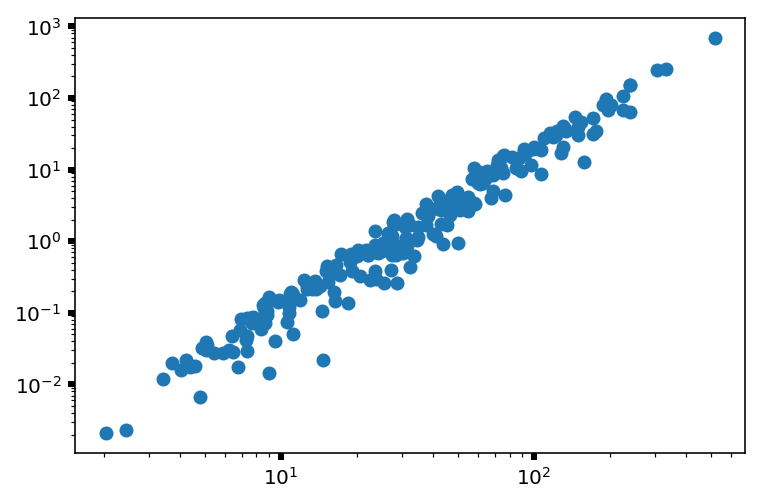

In [108]:
# 2020 Oct 9 - Trying to calculate population-weighted survey area

def calc_lifetime(Dact, D0=1., tau0=40., bet=2./3):
    return tau0*(Dact/D0)**bet

def calc_Asurvey(Dact, Delta_Pact, U, lifetime, Delta_Pmin=P_min):
    return Dact*np.sqrt(Delta_Pact/Delta_Pmin -1.)*U*lifetime

filename = "all_vortices_with_diameters_and_actual_values.csv"
# ('srt_ind', 'vortex_number', 'sols', 'DeltaP', 'Diameter', 'U1', 'U2', 'Vobs', 'simple_Pact', 'simple_Vact', 
# 'simple_Dact', 'simple_bact', 'simple_BIC', 'simple_Vobs_sigma', 'full_Vobs', 'full_b', 'full_Pact', 'full_Vact', 
# 'full_Dact', 'full_bact', 'full_BIC', 'full_Vobs_sigma')
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
ind = (data['full_Vobs_sigma'] >= 3.) &\
    (np.abs(data['full_b']/data['full_Dact']) < max_b_over_Dact) &\
    (np.abs(data['full_b']/data['full_Dact']) > min_b_over_Dact)

Dact = data['full_Dact'][ind]
Pact = data['full_Dact'][ind]
U = data['U1'][ind]
lifetime = calc_lifetime(Dact)

Asurvey = calc_Asurvey(Dact, Pact, U, lifetime)
plt.loglog(Dact, Asurvey/1e6, ls='', marker='o')
print(np.quantile(Asurvey/1e6, 0.5))

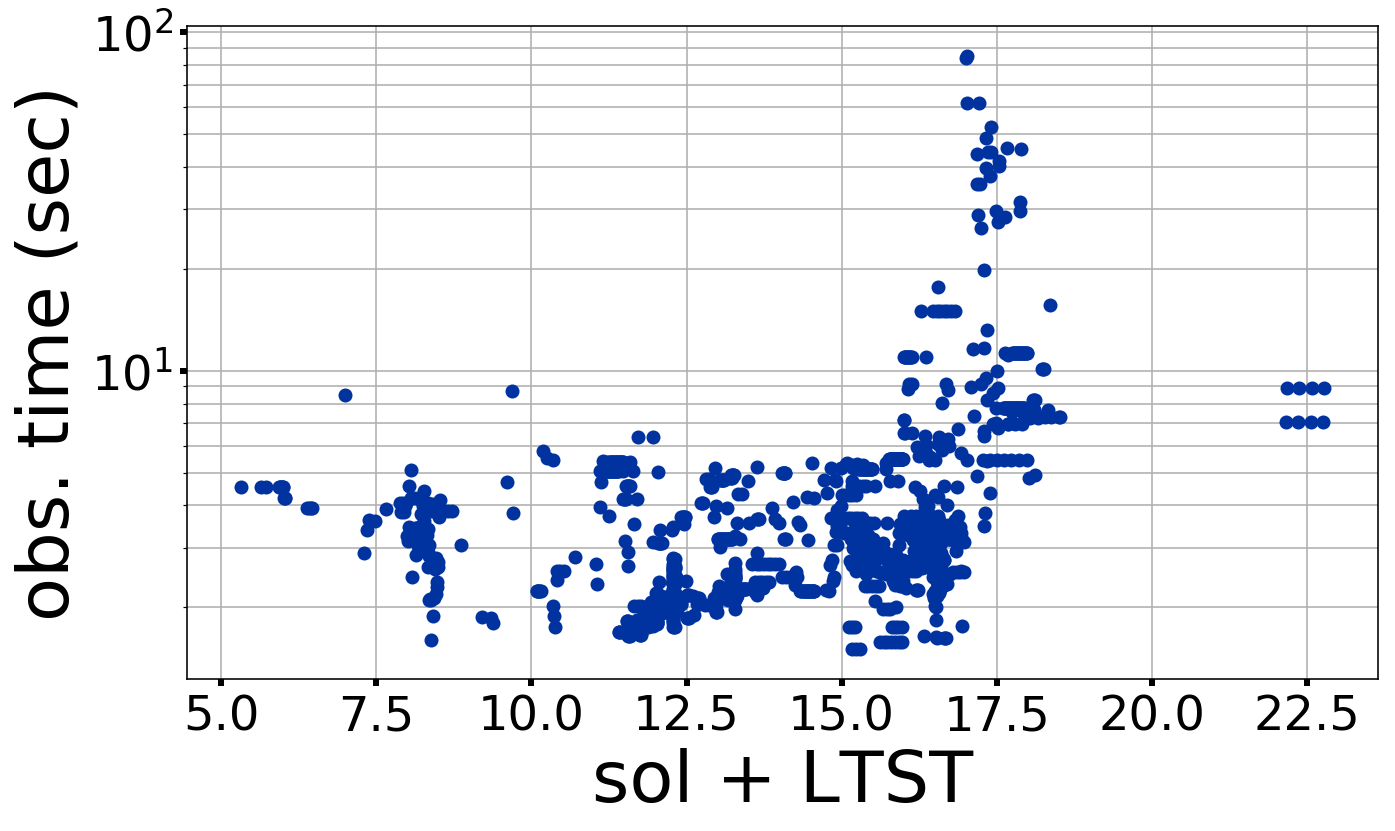

In [5]:
# Estimated based on the Results section of Golombek+ (2020 - https://www.nature.com/articles/s41467-020-14679-1)

# Estimated based on appearance of First Rock near the horizon as seen in 
#   Golombek+ (2020 - https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2020EA001248)
horizon_distance = 20. # m

# Should update based on population-weighted diameter and camera angular resolution
max_distance = horizon_distance # how far away could you see a dust devil
FOV = np.pi*(120./180.) # degrees into radians
area_surveyed = np.pi/2.*FOV*max_distance**2.

# 2021 Feb 4 - Making plot showing observed time
ICC_filename = "Insight ICC Analysis.csv"
ICC_data = np.genfromtxt(ICC_filename, dtype=None, delimiter=',', names=True)

winds_filename = "sols_hour_median_winds.csv"
winds_data = np.genfromtxt(winds_filename, dtype=None, delimiter=',', names=True)
# ('sol', 'median_wind', '0_median_wind', '0_hour_fraction'

sols = np.array([])
LTST = np.array([])
observation_times = np.array([])
observation_times_errs = np.array([])
wind_speeds = np.array([])
for i in range(len(ICC_data)):
# for i in range(10, 20):
    ind = winds_data['sol'] == ICC_data['Sol'][i] 

    if(len(winds_data[ind]) > 0):
        wind_name = str(ICC_data['Hour'][i]) + "_median_wind"
        sols = np.append(sols, ICC_data['Sol'][i])
        LTST = np.append(LTST, ICC_data['Hour'][i] + ICC_data['Min'][i]/60. + ICC_data['Seconds'][i]/3600.)
        observation_times = np.append(observation_times, (max_distance/winds_data[ind][wind_name]))
        observation_times_errs = np.append(observation_times_errs, (max_distance/winds_data[ind][wind_name])/2.)
        wind_speeds = np.append(wind_speeds, winds_data[ind][wind_name])

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

mn_ind = np.argmin(observation_times_errs)
md_ind = np.argsort(observation_times_errs)[len(observation_times_errs)//2]
mx_ind = np.argmax(observation_times_errs)
# ax.errorbar([sols[mn_ind], sols[md_ind], sols[mx_ind]], 
#             [observation_times[mn_ind], observation_times[md_ind], observation_times[mx_ind]], 
#             yerr=[observation_times_errs[mn_ind], observation_times_errs[md_ind], observation_times_errs[mx_ind]], 
#             ls='', marker='o', color=BoiseState_blue, lw=3, ecolor=BoiseState_orange)
ax.plot(LTST, observation_times, ls='', marker='o', color=BoiseState_blue)
ax.set_yscale('log')

# ax.semilogy(sols, observation_times, ls='', marker='o', color=BoiseState_blue)
ax.tick_params(labelsize=24)
ax.set_xlabel('sol + LTST', fontsize=36)
ax.set_ylabel('obs. time (sec)', fontsize=36)
ax.grid(True, which='both')

[2500. 2500. 2500. ... 2500. 2500. 2500.]


Text(0.5, 0, 'sol + LTST')

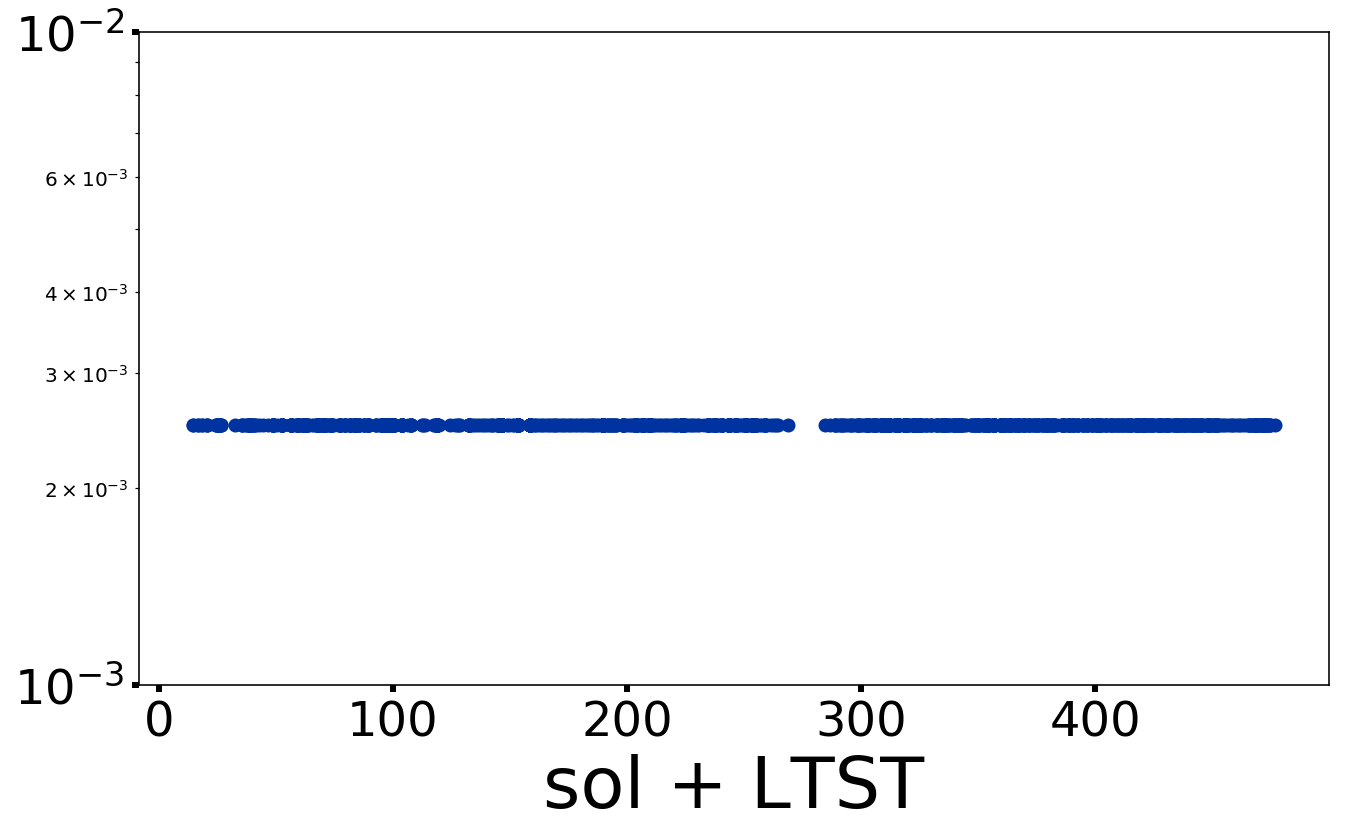

In [41]:
# Estimated based on the Results section of Golombek+ (2020 - https://www.nature.com/articles/s41467-020-14679-1)

# Estimated based on appearance of First Rock near the horizon as seen in 
#   Golombek+ (2020 - https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2020EA001248)
horizon_distance = 20. # m

# Should update based on population-weighted diameter and camera angular resolution
max_distance = horizon_distance # how far away could you see a dust devil
FOV = np.pi*(120./180.) # degrees into radians
area_surveyed = np.pi/2.*FOV*max_distance**2.

# 2021 Feb 4 - Making plot showing observed time
ICC_filename = "Insight ICC Analysis.csv"
ICC_data = np.genfromtxt(ICC_filename, dtype=None, delimiter=',', names=True)

winds_filename = "sols_hour_median_winds.csv"
winds_data = np.genfromtxt(winds_filename, dtype=None, delimiter=',', names=True)
# ('sol', 'median_wind', '0_median_wind', '0_hour_fraction'

sols = np.array([])
max_areal_density = np.array([])
for i in range(len(ICC_data)):
# for i in range(10, 20):
    ind = winds_data['sol'] == ICC_data['Sol'][i] 

    if(len(winds_data[ind]) > 0):
        wind_name = str(ICC_data['Hour'][i]) + "_median_wind"
        sols = np.append(sols, ICC_data['Sol'][i] + ICC_data['Hour'][i]/24.)
        observation_time = (max_distance/winds_data[ind][wind_name])        
        max_areal_density = np.append(max_areal_density, 
                                      1./(winds_data[ind][wind_name]*observation_time*horizon_distance))

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

# mn_ind = np.argmin(observation_times_errs)
# md_ind = np.argsort(observation_times_errs)[len(observation_times_errs)//2]
# mx_ind = np.argmax(observation_times_errs)
# ax.errorbar([sols[mn_ind], sols[md_ind], sols[mx_ind]], 
#             [observation_times[mn_ind], observation_times[md_ind], observation_times[mx_ind]], 
#             yerr=[observation_times_errs[mn_ind], observation_times_errs[md_ind], observation_times_errs[mx_ind]], 
#             ls='', marker='o', color=BoiseState_blue, lw=3, ecolor=BoiseState_orange)
ax.plot(sols, max_areal_density, ls='', marker='o', color=BoiseState_blue)
ax.set_yscale('log')

print(max_areal_density*1000.*1000.)

# ax.semilogy(sols, observation_times, ls='', marker='o', color=BoiseState_blue)
ax.tick_params(labelsize=24)
ax.set_xlabel('sol + LTST', fontsize=36)
# ax.set_ylabel('obs. time (sec)', fontsize=36)
# ax.grid(True, which='both')

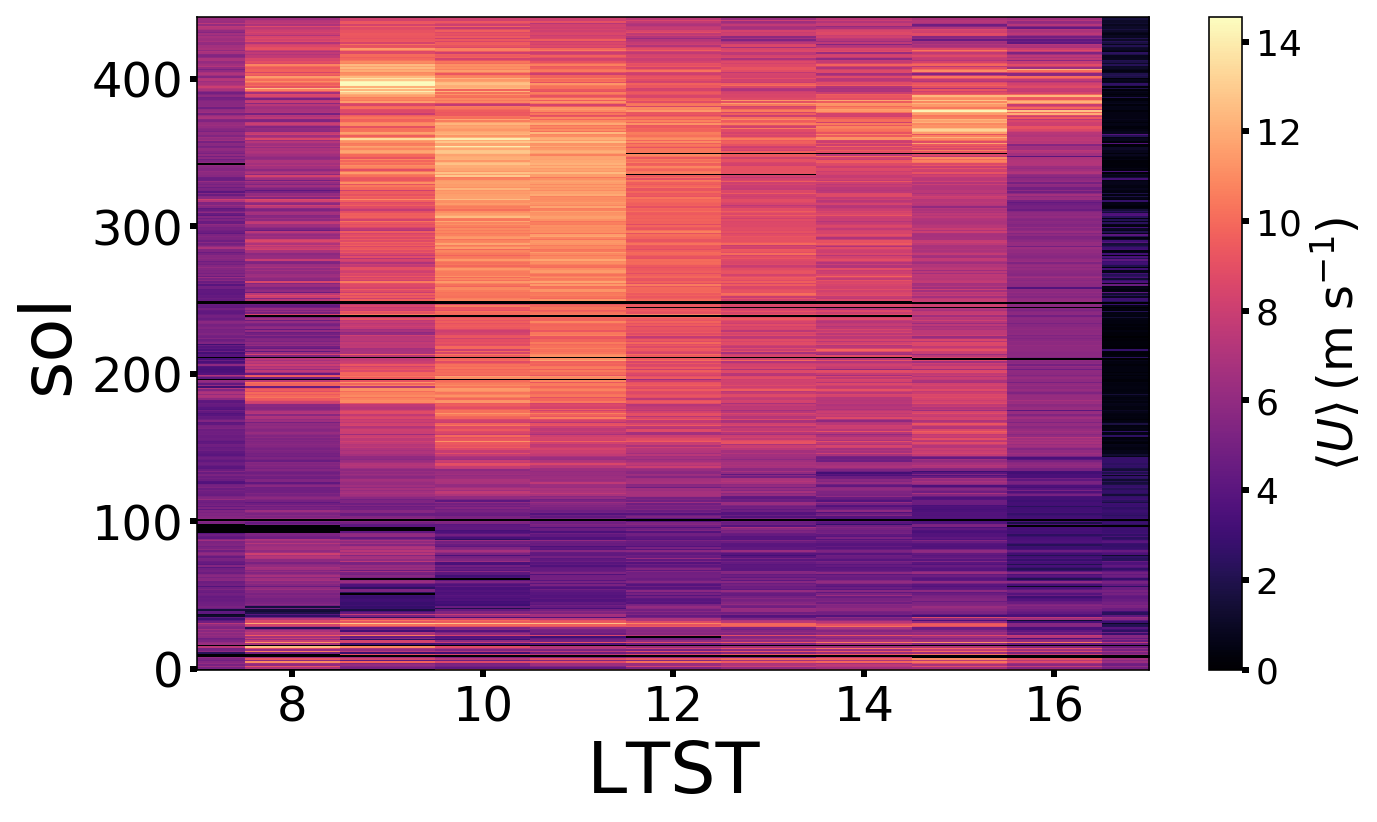

In [9]:
fig = plt.figure(figsize=(6*aspect_ratio, 6))

winds_filename = "sols_hour_median_winds.csv"
winds_data = np.genfromtxt(winds_filename, dtype=None, delimiter=',', names=True)
LTST = np.arange(0, 24)
sols = winds_data['sol']

# print(winds_data['0_median_wind'][100])

# names = winds_data.dtype.names
# print(winds_data.dtype.names)
#('sol', 'median_wind', '0_median_wind', '0_hour_fraction', '1_median_wind', '1_hour_fraction', 
#'2_median_wind', '2_hour_fraction', '3_median_wind', '3_hour_fraction', '4_median_wind', '4_hour_fraction', '5_median_wind', '5_hour_fraction', '6_median_wind', '6_hour_fraction', '7_median_wind', '7_hour_fraction', '8_median_wind', '8_hour_fraction', '9_median_wind', '9_hour_fraction', '10_median_wind', '10_hour_fraction', '11_median_wind', '11_hour_fraction', '12_median_wind', '12_hour_fraction', '13_median_wind', '13_hour_fraction', '14_median_wind', '14_hour_fraction', '15_median_wind', '15_hour_fraction', '16_median_wind', '16_hour_fraction', '17_median_wind', '17_hour_fraction', '18_median_wind', '18_hour_fraction', '19_median_wind', '19_hour_fraction', '20_median_wind', '20_hour_fraction', '21_median_wind', '21_hour_fraction', '22_median_wind', '22_hour_fraction', '23_median_wind', '23_hour_fraction')

x = np.zeros([len(sols), len(LTST)])
y = np.zeros([len(sols), len(LTST)])
z = np.zeros([len(sols), len(LTST)])

for i in range(len(sols)):
    for j in range(len(LTST)):
        winds_name = str(LTST[j]) + "_median_wind"
        sol_ind = winds_data['sol'] == sols[i]
        
        x[i,j] = sols[i]
        y[i,j] = LTST[j]
        z[i,j] = winds_data[winds_name][sol_ind]
        
plt.imshow(z, aspect='auto', origin='lower', cmap='magma')
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22])
plt.xlim([7, 17])
cbar = plt.colorbar()
cbar.set_label(r'$\langle U \rangle \,\left({\rm m\ s^{-1}}\right)$', size=24)
cbar.ax.tick_params(labelsize=18) 

plt.xlabel("LTST", fontsize=36)
plt.ylabel("sol", fontsize=36)
plt.tick_params(labelsize=24)

fig.savefig("../figures/advective_speeds.png", dpi=500, bbox_inches="tight")

[46.27234608  3.01602836  1.35877388  0.18294835  0.08948295  0.15149483
  0.34774898  0.12859126  0.13556827         inf]
0.37511069010206943
0.7427191664020977

0.012201334053985794 0.8134222702657197
0.012201334053985794 0.41081932841703006


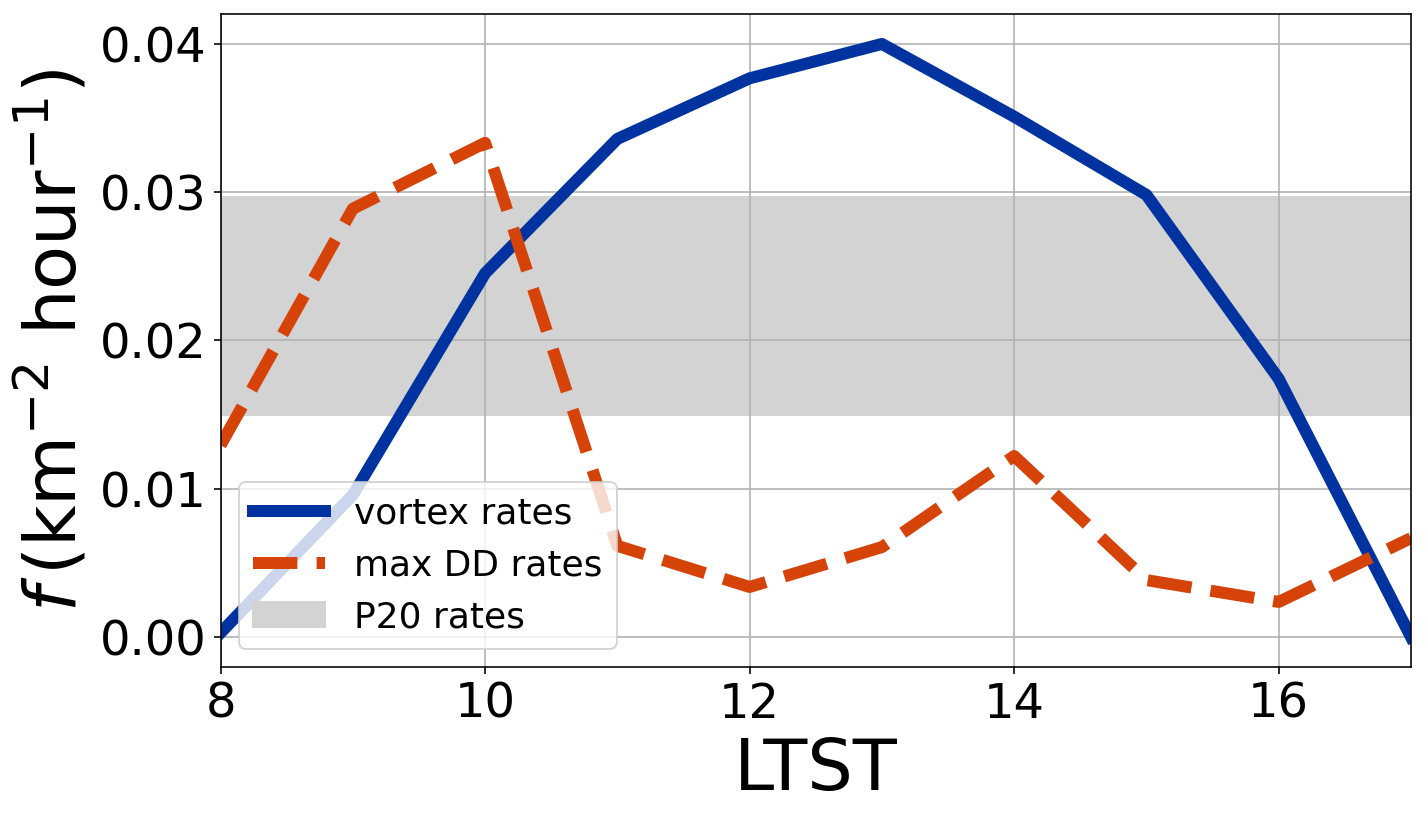

In [3]:
# 2021 Feb 11 - Calculating population average
def product(Dact, Pact, Pmin=0.1):
    return Dact*np.sqrt(Pact/Pmin - 1.)

# 2021 Feb 23 - Experimenting with areal density calculation
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

seconds_in_martian_hour = 3697.

# areal occurrence rate from meteorological time-series analysis

filename = "all_vortices_with_diameters_and_actual_values.csv"
data = np.genfromtxt(filename, delimiter=',', names=True, dtype=None)
ind = (np.abs(data['full_b']/data['full_Dact']) <= max_b_over_Dact) &\
    (data['full_Vobs_sigma'] >= min_full_Vobs_sigma) &\
    (np.isfinite(data['full_Pact_unc']) & np.isfinite(data['full_Dact_unc']))

winds_filename = "sols_hour_median_winds.csv"
winds_data = np.genfromtxt(winds_filename, dtype=None, delimiter=',', names=True)

products = product(data['full_Dact'][ind], data['full_Pact'][ind])
mn_prod = np.min(products)
med_prod = np.median(products)
mean_prod = np.mean(products)
mx_prod = np.max(products)

areal_density_by_hour = np.array([])
for i in range(len(TOD_bins)):
    winds_name = str(int(np.floor(TOD_bins[i]))) + "_median_wind"
    
    cur_U = np.mean(winds_data[winds_name])
    
    areal_density_by_hour = np.append(areal_density_by_hour,
        TOD_hst[i]/seconds_in_martian_hour/cur_U/med_prod)

# per hour per square km
ax.plot(TOD_bins, areal_density_by_hour*1e6, lw=6, color=BoiseState_blue, 
            label="vortex rates")

# areal occurrence rate from image analysis
filename = "Insight_Combined_Analysis.csv"
data = np.genfromtxt(filename, delimiter=",", names=True)
hours = np.floor(24.*data['LTST'])

winds_filename = "sols_hour_median_winds.csv"
winds_data = np.genfromtxt(winds_filename, dtype=None, delimiter=',', names=True)

L = 2400. # m
FOV = 124. # degrees
W = 0.5*np.pi*(FOV/180.)*L
seconds_per_sol = 24*3600. + 39.*60 + 35.244
seconds_per_hour = 61*3600. + 36.968

max_areal_ocurrence_rate = np.zeros_like(TOD_bins)
for i in range(len(TOD_hst)):
    winds_name = str(int(TOD_hst[i])) + "_median_wind"       
    median_U = np.nanmedian(winds_data[winds_name][:])
    crossing_time = L/median_U
    num_obs = len(hours[hours == TOD_bins[i]])
    tau = crossing_time*num_obs/seconds_in_martian_hour
    
    max_areal_ocurrence_rate[i] = 1./L/W/tau
    
ax.plot(TOD_bins, max_areal_ocurrence_rate*1e6, lw=6, ls='--', color=BoiseState_orange, 
            label="max DD rates") #convert to per square km

# Perrin's numbers - 0.03/km^2/sol
# Dust devils are only active for about 9 Mars hours each sol -> 9/24 sols
hours_active = np.max(TOD_bins) - np.min(TOD_bins)
Perrin_min = 0.04*(hours_active/24) # per square km per hour - multiply by sols per hour that vortices are active
Perrin_max = 0.0792*(hours_active/24) # per square km per hour

ax.fill_between(TOD_bins, y1=np.ones_like(TOD_bins)*Perrin_min, y2=np.ones_like(TOD_bins)*Perrin_max, 
                color='lightgrey', zorder=-1, label="P20 rates")

# ax.axhline(Perrin_min, lw=6, ls='-.', color='green', zorder=-1, label="P20 rates")
# ax.text(np.min(TOD_bins), Perrin_min*1.3, r'$%.1g\, {\rm km^{-2}\ hour^{-1}}$' %\
#         (Perrin_min/(hours_active/24)), fontsize=24)
# ax.axhline(Perrin_max, lw=6, ls='-.', color='green', zorder=-1)
# ax.text(np.min(TOD_bins), Perrin_max*1.3, r'$%.1g\, {\rm km^{-2}\ hour^{-1}}$' %\
#         (Perrin_max/(hours_active/24)), fontsize=24)

ax.grid(True)
ax.set_xlabel("LTST", fontsize=36)
ax.set_ylabel(r'$f\,\left({\rm km^{-2}\ hour^{-1}}\right)$', fontsize=36)
ax.tick_params(labelsize=24)
ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22])
ax.set_xlim([np.min(TOD_bins), np.max(TOD_bins)])
# ax.set_ylim([2e-3, 5e-2])

ax.legend(loc="lower left", fontsize=18)

print(max_areal_ocurrence_rate/areal_density_by_hour)
print(Perrin_min/(areal_density_by_hour[5]*1e6))
print(Perrin_max/(areal_density_by_hour[5]*1e6))

print()

print(max_areal_ocurrence_rate[6]*1e6, max_areal_ocurrence_rate[6]*1e6/Perrin_min)
print(max_areal_ocurrence_rate[6]*1e6, max_areal_ocurrence_rate[6]*1e6/Perrin_max)

# fig.savefig("../figures/areal_occurrence_rate.png", dpi=500, bbox_inches="tight")

In [18]:
# 2021 Mar 2 - Comparing to Lorenz's detections (https://ui.adsabs.harvard.edu/abs/2021Icar..35514119L/abstract)

seconds_in_martian_hour = 3697.
seconds_in_martian_sol = 24*3600. + 39*60. + 35.

# Lorenz calculates an areal fraction by comparing the total duration of vortex events 
# to the total duration of possible dust devil activity
Lorenz_area_fraction = 6000./8e6
print(Lorenz_area_fraction)

# Taking the same tact for our detections gives the following:
filename = "all_vortices.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)

total_duration_vortex_encounters = np.sum(data['Gamma'][ind])
total_observational_period = (np.max(TOD_bins) - np.min(TOD_bins))*seconds_in_martian_hour*\
    (np.max(data['sol'][ind]) - np.min(data['sol'][ind]))
print(total_duration_vortex_encounters/total_observational_period)

0.00075
0.0007685324620029787


In [11]:
filename = "all_vortices.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)

print(len(data['DeltaP'][ind])/477.)
# Spiga's encounter rate
print(6000./400.)

2.0754716981132075
15.0


In [24]:
# 2021 Mar 6 - Calculating total duration for Ellehoj+ (2010)
seconds_in_martian_sol = 24*3600. + 39*60. + 35.
observation_duration = 151.*seconds_in_martian_sol

filename = "Ellehoj2010_Table1.txt"
data = np.genfromtxt(filename, names=True, dtype=None, delimiter=",")
print(np.sum(data['Gamma'])/observation_duration)

0.00013379385715431343
